# Derive metallicity maps in souce plane

Lines used: OII, Hgamma,  Hbeta, OIII4959, OIII5007,

 - Produce a signal to noise image in source plane
 - Bin it (voronoi)
 - Lense to image plane each bin individually and colvolve by the psf
 - Measure the flux in each bin by sum(flux_map * bin_source_plane) / sum(bin_source_plane)
 - Check the S/N ratio of the bins. Group bins together if the signal is too high


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve
from astropy import units as u
from astropy.nddata.utils import Cutout2D
from astropy import wcs
from astropy.stats import sigma_clip,sigma_clipped_stats
from astropy.table import Table
import glob
from reproject import reproject_interp, reproject_exact
# Cosmology
from astropy.cosmology import WMAP9 as cosmo

# Redshift of A370
z = 0.725

### Make Hgamma narrow band image

Hgamma is the faintes of the lines to be used. However, for now I'm binning in OII

<IPython.core.display.Javascript object>


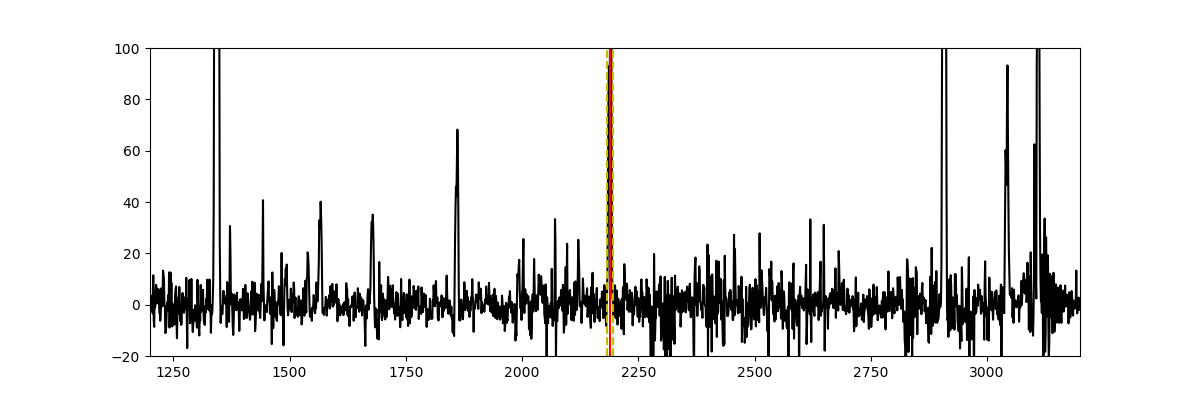

<IPython.core.display.Javascript object>


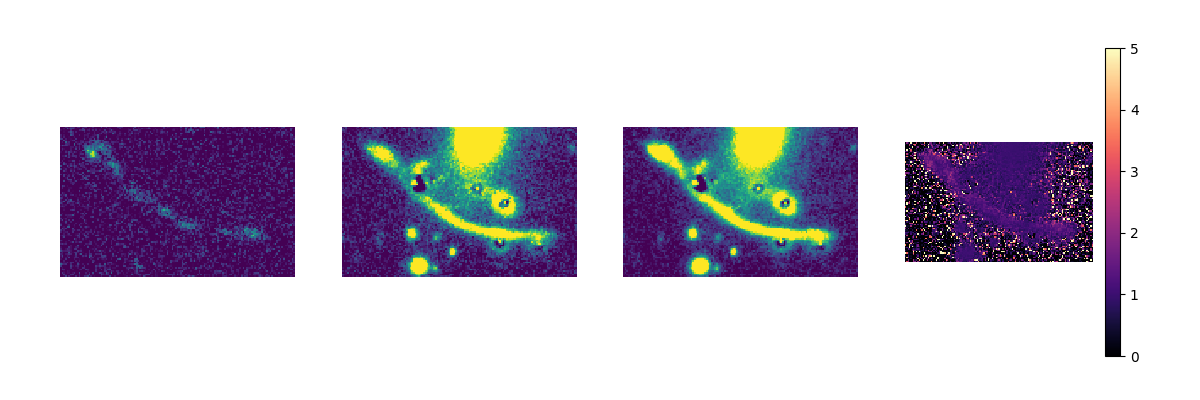

In [2]:
# Make narrow band image --> Use 3 sigma from Ha and subtract continuum
cube = fits.getdata('../../Data/Cubes/SmallCube_A370_mosaic_CMSub.fits')
spectra = fits.getdata('../../Data/Spectra/P18_spectra/Spectrum_A370_ContSub_pPXF.fits')
header = fits.getheader('../../Data/Cubes/SmallCube_A370_mosaic_CMSub.fits',ext=1)
wave = [header['CRVAL3']+i*header['CD3_3'] for i in range(header['NAXIS3'])] 

def make_nb(cube,center,width,red=None,blue=None):
    """Makes a narrow band around pixel "center" and width 6*"width", subtracting the
    continuum extrapolated from red_cont and blue_cont"""
    
    if red is None:
        red = center+4*width, center+6*width
    if blue is None:
        blue = center-6*width, center-4*width
    imblue = np.nanmean(cube[blue[0]:blue[1]],axis=0)
    imred = np.nanmean(cube[red[0]:red[1]],axis=0)
    m = (imred - imblue)/((red[0]+red[1])/2 - (blue[0]+blue[1])/2)
    a = imred - m*(red[0]+red[1])/2
    dummy = np.empty_like(cube)
    for k in range(center-3*width,center+3*width+1):
        dummy[k,:,:] = cube[k,:,:] - (m*k + a)

    return np.nanmean(dummy[center-3*width:center+3*width],axis=0)*(wave[1]-wave[0]),imred*(wave[1]-wave[0])

center = 2189
sigma = 2

nb,cont = make_nb(cube,center,sigma)
nb_with_continuum = np.nanmean(cube[center-3*sigma:center+3*sigma],axis=0)*(wave[1]-wave[0])

fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(spectra,color='k')
ax.axvline(center,color='r')
ax.axvline(center-3*sigma,color='y',linestyle='--')
ax.axvline(center+3*sigma,color='y',linestyle='--')
ax.set_xlim(1200,3200)
ax.set_ylim(-20,100)

fig, ax = plt.subplots(1,4,figsize=(12,4))
fig.subplots_adjust(left=0.05,right=0.95)

ax[0].imshow(nb,origin='lower',vmin=0,vmax=5)
ax[1].imshow(cont,origin='lower',vmin=0,vmax=5)
ax[2].imshow(nb_with_continuum,origin='lower',vmin=0,vmax=5)
cax = ax[3].imshow(nb_with_continuum/cont,origin='lower',vmin=0,vmax=5,cmap=plt.cm.magma)
plt.colorbar(cax,ax=ax[3])

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')

## Save images
header_im = fits.getheader('../../Data/Images/A370_camel/A370_flux_indep_OII3726.fits')
fits.writeto('Image_A370_Hgamma.fits',data=nb_with_continuum,header=header_im,overwrite=True)
fits.writeto('Image_A370_Hgamma_cont.fits',data=cont,header=header_im,overwrite=True)

## Bin data in signal to noise (using OII)

<IPython.core.display.Javascript object>


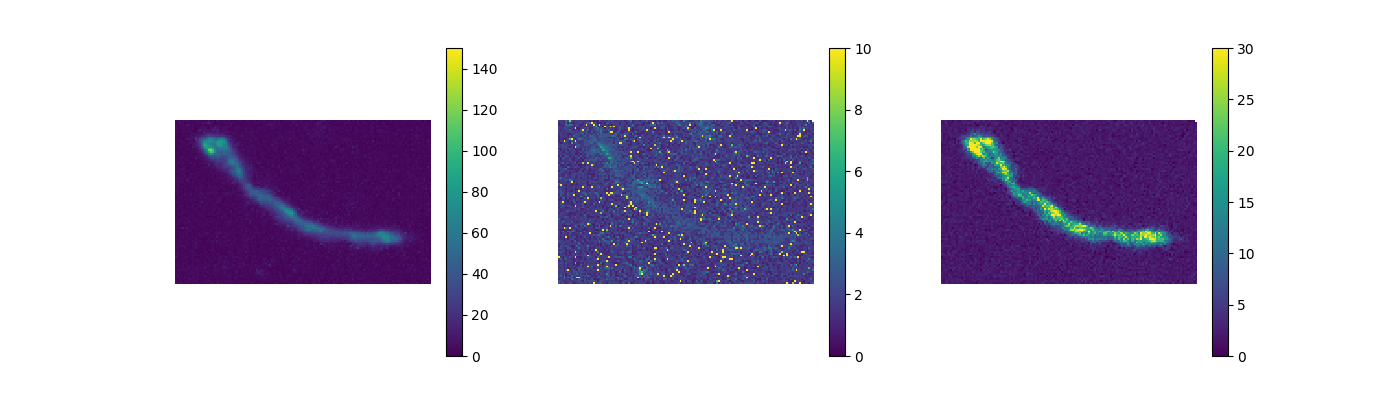

<IPython.core.display.Javascript object>


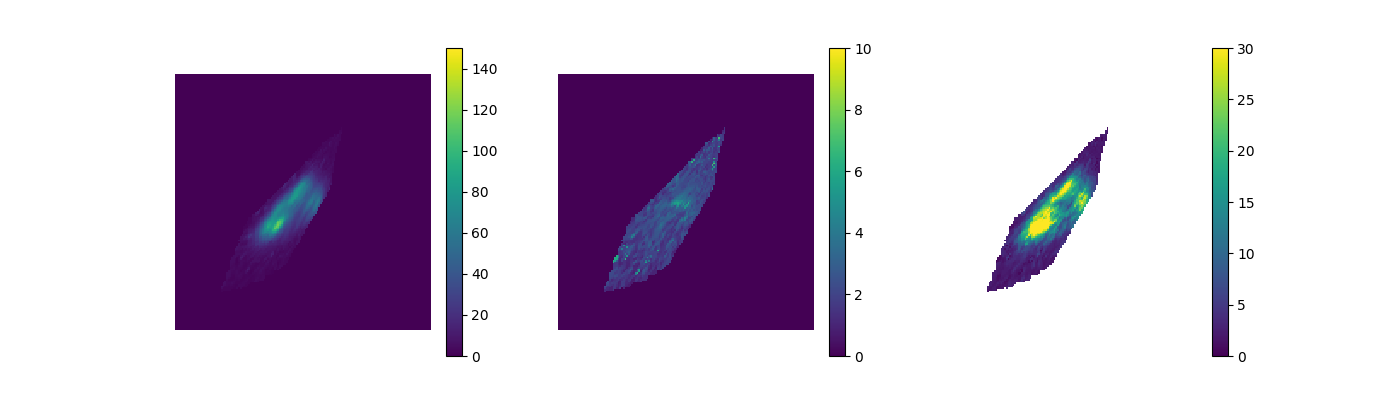

In [3]:
signal = fits.getdata('../../Data/Images/A370_camel/A370_flux_indep_OII3726.fits')
err = fits.getdata('../../Data/Images/A370_camel/A370_eflux_indep_OII3726.fits')

fig, ax = plt.subplots(1,3,figsize=(14,4))
[x.axis('off') for x in ax]

cax0 = ax[0].imshow(signal,origin='lower',vmin=0,vmax=150)
cax1 = ax[1].imshow(err,origin='lower',vmin=0,vmax=10)
cax2 = ax[2].imshow(signal/err,origin='lower',vmin=0,vmax=30)
for e,c in enumerate((cax0,cax1,cax2)):
    plt.colorbar(c,ax=ax[e])
    
    
signal = fits.getdata('../../Data/LensingModels/A370/SourcePlane_A370_OII.fits')
err = fits.getdata('../../Data/LensingModels/A370/SourcePlane_A370_OII_err.fits')

err = sigma_clip(err,sigma=10) # some outliers cause problems with voronoi binning
err.data[np.where(err.mask == True)] = sigma_clipped_stats(err,mask_value=0)[0]
err = err.data

fig, ax = plt.subplots(1,3,figsize=(14,4))
[x.axis('off') for x in ax]

cax0 = ax[0].imshow(signal,origin='lower',vmin=0,vmax=150)
cax1 = ax[1].imshow(err,origin='lower',vmin=0,vmax=10)
cax2 = ax[2].imshow(signal/err,origin='lower',vmin=0,vmax=30)
for e,c in enumerate((cax0,cax1,cax2)):
    plt.colorbar(c,ax=ax[e])

2.0695756810811536


<IPython.core.display.Javascript object>


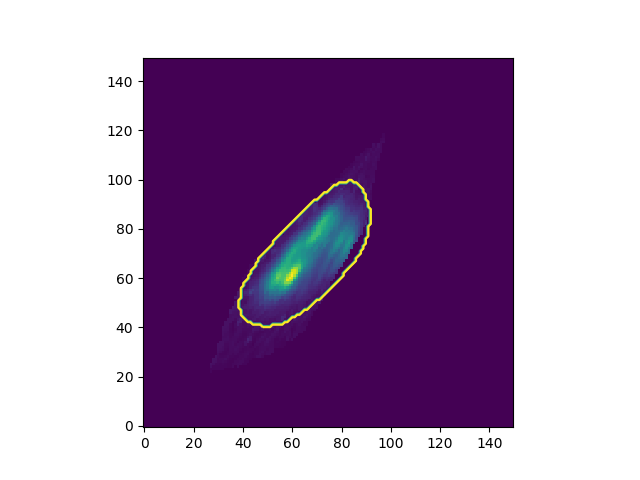

In [4]:
from resolved_maps_tools import make_voronoi_tessalation_input,voronoi_tessalation

print(sigma_clipped_stats(err,mask_value=0)[0])
mask = np.zeros_like(signal)
smooth_signal = convolve(signal,Gaussian2DKernel(3))
mask[np.where(smooth_signal <= 6)] = 1

fig, ax = plt.subplots(1,1)
ax.imshow(signal,origin='lower')
ax.contour(mask,level=1,color='r')

make_voronoi_tessalation_input(signal=signal,noise=err,mask=mask, out_name='A370_oii_source_plane')

<IPython.core.display.Javascript object>


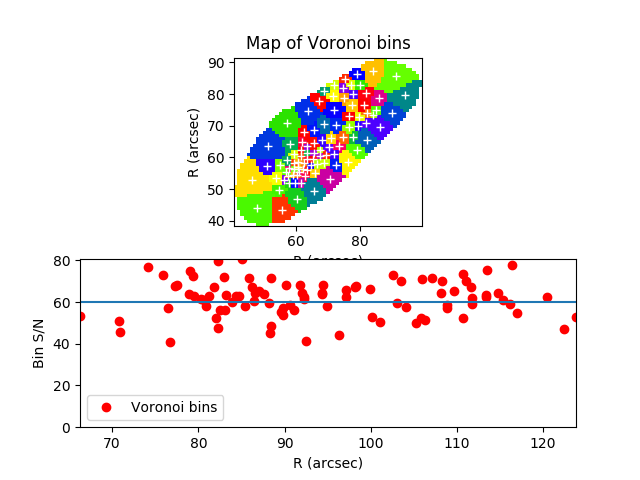

Tessalating  Signal_and_noise_A370_oii_source_plane.txt
Bin-accretion...
141  initial bins.
Reassign bad bins...
94  good bins.
Modified Lloyd algorithm...
11  iterations.
Unbinned pixels:  0  /  1619
Fractional S/N scatter (%): 14.267257625072766
Elapsed time: 0.26 seconds


In [5]:
plt.figure()
voronoi_tessalation(input_files='Signal_and_noise_A370_oii_source_plane.txt',targetSN = 60.0)

<IPython.core.display.Javascript object>


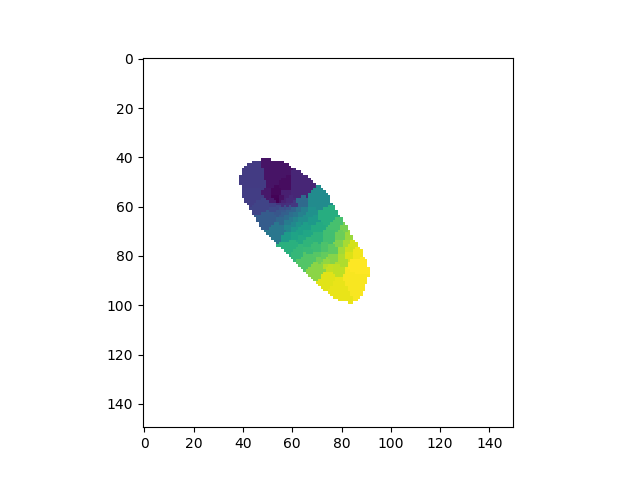

In [9]:
# Make map
header = fits.getheader('../../Data/LensingModels/A370/SourcePlane_A370_OII.fits')
vbin_map = np.zeros_like(signal)
vbin_map[:,:] = np.nan

p, q, binNum = np.loadtxt('vor_SN_60.0_A370_oii_source_plane.txt', unpack=True,  
                          dtype={'names': ('p', 'q', 'binNum'),'formats': ('int16', 'int16', 'int16')})

for vbin in range(np.max(binNum)+1):
    temp_map = np.zeros_like(signal)
    pix = np.where(binNum==vbin)
    temp_map[[p[pix],q[pix]]] = 1
    vbin_map[[p[pix],q[pix]]] = vbin
    fits.writeto('a370_SN_sourceplane/lenstool_files/bin_%d.fits'%vbin,data=temp_map,header=header)
    
plt.figure()
plt.imshow(vbin_map)
fits.writeto('a370_SN_sourceplane/lenstool_files/full_bins.fits',data=vbin_map,header=header)

## Lenstool 

prepare input files and run lenstool

In [18]:
# Lense all maps
par_file = open('../../Data/LensingModels/A370/A370_simul.par')
lines = par_file.readlines()

files = glob.glob('a370_SN_sourceplane/lenstool_files/*fits')
for f in files:
    f = f.split('a370_SN_sourceplane/lenstool_files/')[1]
    lines[18] = '\tpixel 2 500 ' + 'ImagePlane_' + f  +'\n'
    lines[33] = '\tsframe ' + f +'\n'

    outfile = open('a370_SN_sourceplane/lenstool_files/'+f.replace('.fits','.par'),'w')
    for l in lines:
            outfile.write("%s" % l)
    outfile.close()

In [19]:
par_files = files = glob.glob('a370_SN_sourceplane/lenstool_files/*par')
outfile = open('a370_SN_sourceplane/lenstool_files/run_list','w')

for p in par_files:
    p.replace('a370_SN_sourceplane/lenstool_files/','')
    outfile.write('/home/jrichard/soft/lenstool/src/lenstool '+p+' -n\n')
outfile.close()

## Regrid to MUSE and convolve the image plane grid with the PSF

A370 psf: 0.70" FWHM --> 0.2972399151

Image plane images resolution: 1.66833500166834E-05 deg/pix --> 0.06006006006 "/pix

PSF in pixels: 0.2972399151/0.2 = 1.4861995755 pix -->1.5

In [20]:
muse_header = fits.getheader('/Users/vera/Arcs/A370/ExtractedData/Im_A370_mosaic_OII_ContSub_CMSub.fits',ext=1) 
image_plane = glob.glob('a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_*.fits')
header = fits.getheader('a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_0.fits')
kernel = Gaussian2DKernel(stddev=1.5)

for name in image_plane:
    print('Image',name,'of',len(image_plane))
    im = fits.open(name)
    im_aligned, footprint = reproject_interp(im, muse_header)
    conv_im = convolve(im_aligned, kernel)
    fits.writeto(name.replace('.fits','_convolved.fits'),data=conv_im,header=muse_header)

('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_8.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_87.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_68.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_29.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_91.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_52.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_44.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_13.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_64.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_4.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_33.fits', 'of', 94)
('Image', 'a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_25

In [21]:
# For image with all bins
im = fits.open('a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_full_bins.fits')
im_aligned, footprint = reproject_interp(im, muse_header)
conv_im = convolve(im_aligned, kernel)
fits.writeto("a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_full_bins_convolved.fits",data=conv_im,header=muse_header)

### Some plots and align with MUSE data

## Extract spectra in the apertures (weighed by seeing)

We save them in rest-frame to use ALFA and pPXF without worring about the redshift too much.

In [22]:
## Extract spectra in the cube
aperture_list = glob.glob("a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_*_convolved.fits")
cube = fits.getdata('../../Data/Cubes/SmallCube_A370_mosaic_CMSub.fits')
cube_header = fits.getheader('../../Data/Cubes/SmallCube_A370_mosaic_CMSub.fits',ext=1)

# prepare header
prihdr_MUSE = fits.Header()
prihdr_MUSE['NAXIS1']=  cube_header['NAXIS3']
prihdr_MUSE['CRVAL1'] = cube_header['CRVAL3']/(z+1)
prihdr_MUSE['CRPIX1'] = 1
prihdr_MUSE['CDELT1'] = cube_header['CD3_3']/(z+1)
prihdr_MUSE['CUNIT1']= 'Angstrom'

for f in aperture_list:
    print(f)
    aperture = fits.getdata(f)
    weighted_cube = cube*aperture
    sp = np.sum(weighted_cube,axis=(1,2))
    fits.writeto(f.replace('ImagePlaneAperture/ImagePlane','Spectra/Spectra'),data=sp*(z+1),header=prihdr_MUSE,output_verify='fix')

a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_66_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_73_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_17_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_91_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_84_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_74_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_61_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_10_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_18_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_83_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_69_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_82_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_19_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_68_convolv

# Fit with pPXF

This is a simple fit, only to remove the continuum, not to actually measure the properties of the continuum. ALFA also fits the continuum, so pPXF is mainly used to remove the balmer absoptions


PREPARE YOURSELVES FOR SOME UGLY CODE!

In [23]:
import ppxf_util 

def prepare_stellar_libraries(dummyfile='a370_SN_sourceplane/Spectra/Spectra_bin_0_convolved.fits'):
    
    ## Observed Spectrum
    h1 = fits.getheader(dummyfile)
    gal_lin = fits.getdata(dummyfile)
    lamRange_gal = h1['CRVAL1'] + np.array([0.,h1['CDELT1']*(h1['NAXIS1']-1)])
    FWHM_gal = 2.5/(1+0.725) ## In Angstrom

    ## Convert to logscale
    galaxy, logLam_gal, velscale = ppxf_util.log_rebin(lamRange_gal, gal_lin)

    ## Template library : Indo-US
    temp_list = '/Users/vera/SpectralLibraries/Indo-US/TEXT/INDO-US_model_list_no_gaps.txt'
    temp_dir = '/Users/vera/SpectralLibraries/Indo-US/TEXT/'
    (models,met,age) = np.loadtxt(temp_list,skiprows=1,unpack=True,\
                    dtype=[('file','S30'),('FeH','f4'),('Teff','f4')])
    FWHM_temp = 1.35 # template resolution 
    (lbd,star_spec) = np.loadtxt(temp_dir+models[0],skiprows=31,unpack=True)
    lamRange_temp = [lbd[0],lbd[-1]]
    starNew, logLam_temp, velscale = ppxf_util .log_rebin(lamRange_temp, star_spec, velscale=velscale)
    if FWHM_gal > FWHM_temp:
        FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_temp**2)
        sigma = FWHM_dif/2.355/(lbd[1]-lbd[0]) # Sigma difference in pixels
    else:
        sigma = 1e-20
        print('Observation resolution higher than model')

    dv = (logLam_temp[0]-logLam_gal[0])*299792.458 # km/s
        
    star_temp = np.empty((starNew.size,len(models)))
    for j, file in enumerate(models):
            (lbd,spec) = np.loadtxt(temp_dir+file,skiprows=0,unpack=True)
            spec = ndimage.gaussian_filter1d(spec,sigma)
            sspNew, logLam_temp, velscale = ppxf_util.log_rebin(lamRange_temp, spec,velscale=velscale)
            star_temp[:,j] = sspNew/np.median(sspNew) # Normalizes templates

    ## Mask. Use ppxf routine to calculate good pixels')
    goodpixels = ppxf_util.determine_goodpixels(logLam_gal, lamRange_temp, 0)

    return star_temp, velscale, goodpixels, lamRange_gal, dv 

In [24]:
# Prepare spectral libraries
from ppxf import ppxf

star_temp, velscale, goodpixels, lamrange_gal, dv = prepare_stellar_libraries()
FWHM_gal = 2.5/(1+0.725) ## In Angstrom
h1 = fits.getheader('a370_SN_sourceplane/Spectra/Spectra_bin_0_convolved.fits')
wave_original = np.arange(h1['CRVAL1'],h1['CRVAL1']+h1['CDELT1']*h1['NAXIS1'],h1['CDELT1'])


for s in glob.glob('a370_SN_sourceplane/Spectra/Spectra_bin_*_convolved.fits'):
    
    print('Fitting: %s'%s)

    # Prepare input spectra
    h1= fits.getheader(s)
    gal_lin = fits.getdata(s)

    # Put in in logscale
    galaxy, logLam_gal, velscale = ppxf_util.log_rebin(lamrange_gal, gal_lin)
    norm = np.median(galaxy)
    galaxy /= norm # Normalize spectrum to avoid numerical issues
    noise = np.ones_like(galaxy)

    ## Fit
    start = [0,180]
    try:
        pp = ppxf(star_temp, galaxy, noise, velscale, start, goodpixels, vsyst=dv,clean=True,plot=False,quiet=True)
    except ValueError:
        print('Not fitted')
        pass
        
    print('Velocity and dispersion: %s'%pp.sol)
   
    ## Return the solution to the same wavelenght and flux as before
    wave = np.exp(logLam_gal)#This has a different step than the original
    wave_origin = np.arange(h1['CRVAL1'],h1['CRVAL1']+h1['CDELT1']*h1['NAXIS1'],h1['CDELT1'])
    continuum = pp.bestfit*norm
    
    ## Interpolate solution to be able to subtract it to the original spectrum
    continuum_interp = np.interp(wave_origin,wave,continuum,left=0,right=0)
    contsub = gal_lin - continuum_interp

    fits.writeto(s.replace('Spectra','SpectraContSub').replace('convolved','continuum_subtracted'),data=contsub,header = h1)

Fitting: a370_SN_sourceplane/Spectra/Spectra_bin_42_convolved.fits
Velocity and dispersion: [-88.81199136 337.89214873]
Fitting: a370_SN_sourceplane/Spectra/Spectra_bin_57_convolved.fits
Velocity and dispersion: [-88.12788028  82.79439284]
Fitting: a370_SN_sourceplane/Spectra/Spectra_bin_26_convolved.fits
Velocity and dispersion: [-68.53299914 433.56547803]
Fitting: a370_SN_sourceplane/Spectra/Spectra_bin_33_convolved.fits
Velocity and dispersion: [-73.63812588 397.55947806]
Fitting: a370_SN_sourceplane/Spectra/Spectra_bin_29_convolved.fits
Velocity and dispersion: [-60.35156083 424.83028905]
Fitting: a370_SN_sourceplane/Spectra/Spectra_bin_58_convolved.fits
Velocity and dispersion: [-48.52020562  91.33496385]
Fitting: a370_SN_sourceplane/Spectra/Spectra_bin_50_convolved.fits
Velocity and dispersion: [-108.74628333   73.19138109]
Fitting: a370_SN_sourceplane/Spectra/Spectra_bin_45_convolved.fits
Velocity and dispersion: [-98.90883056  66.3726084 ]
Fitting: a370_SN_sourceplane/Spectra/S

Fit with ALFA

## Print to pdf

a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_48_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


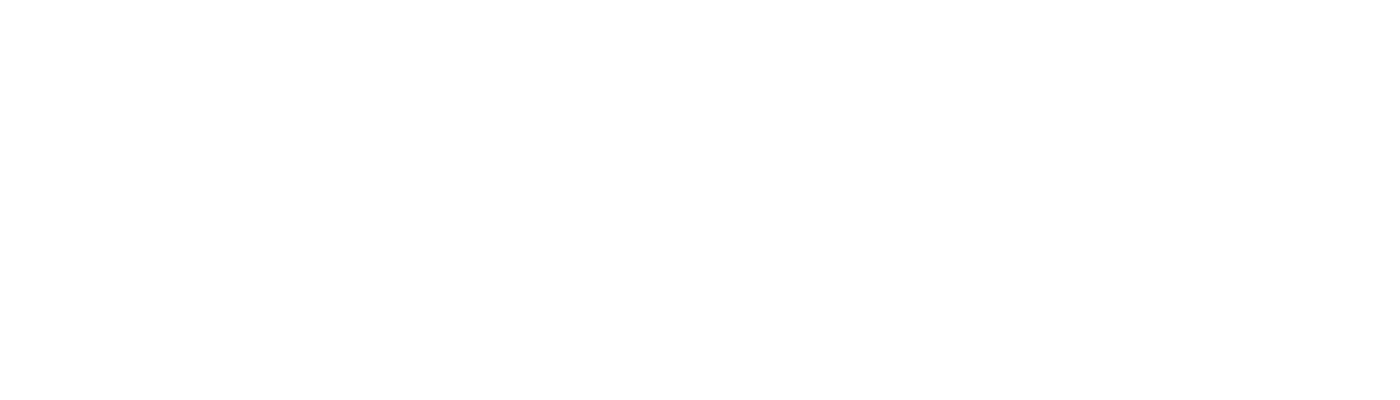

a370_SN_sourceplane/lenstool_files/bin_48.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_13_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


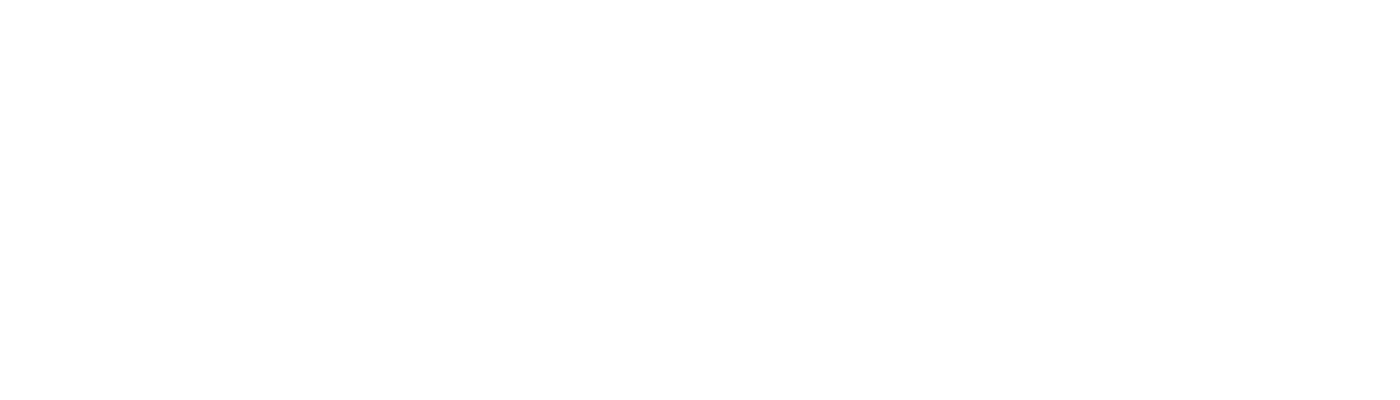

a370_SN_sourceplane/lenstool_files/bin_13.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_87_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


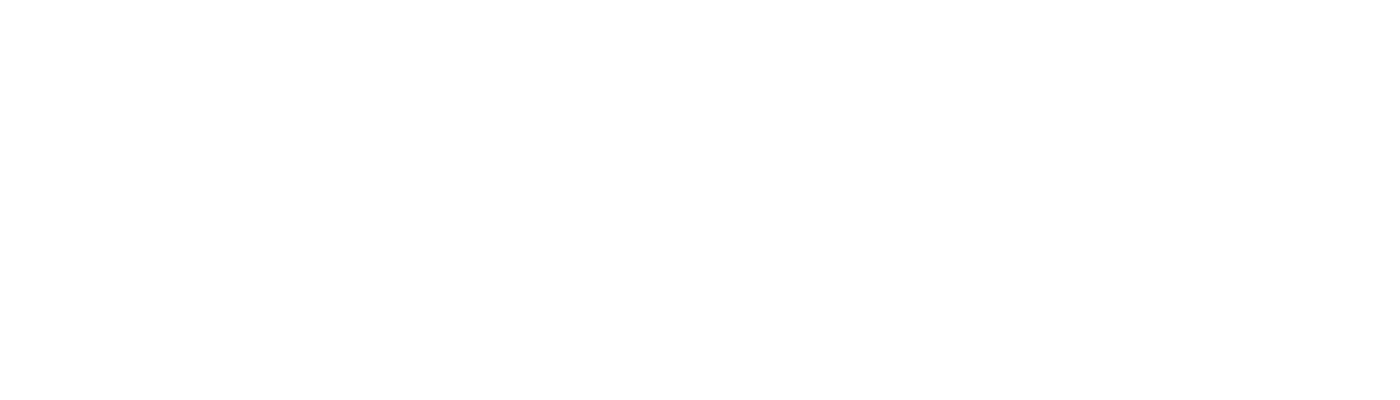

a370_SN_sourceplane/lenstool_files/bin_87.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_56_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


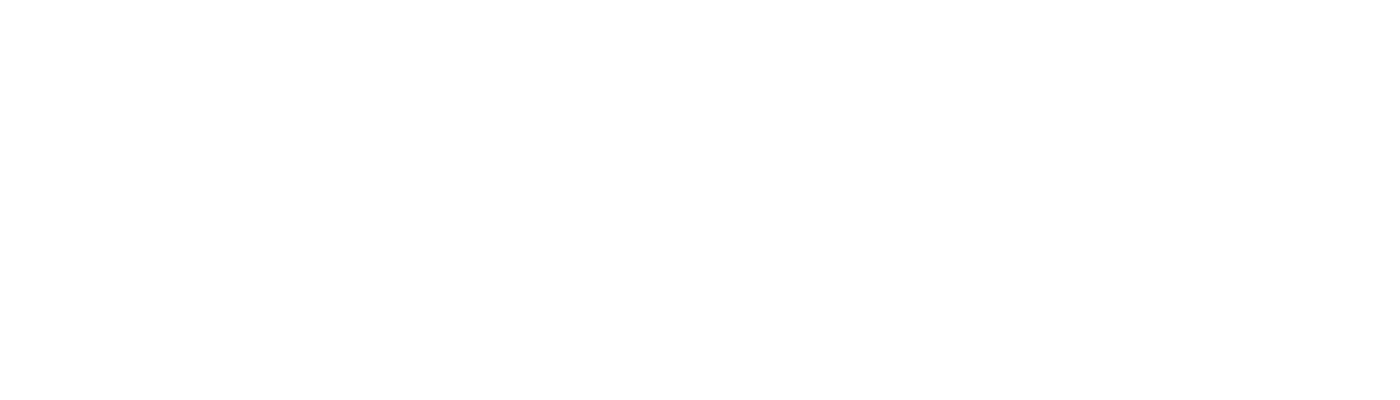

a370_SN_sourceplane/lenstool_files/bin_56.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_36_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


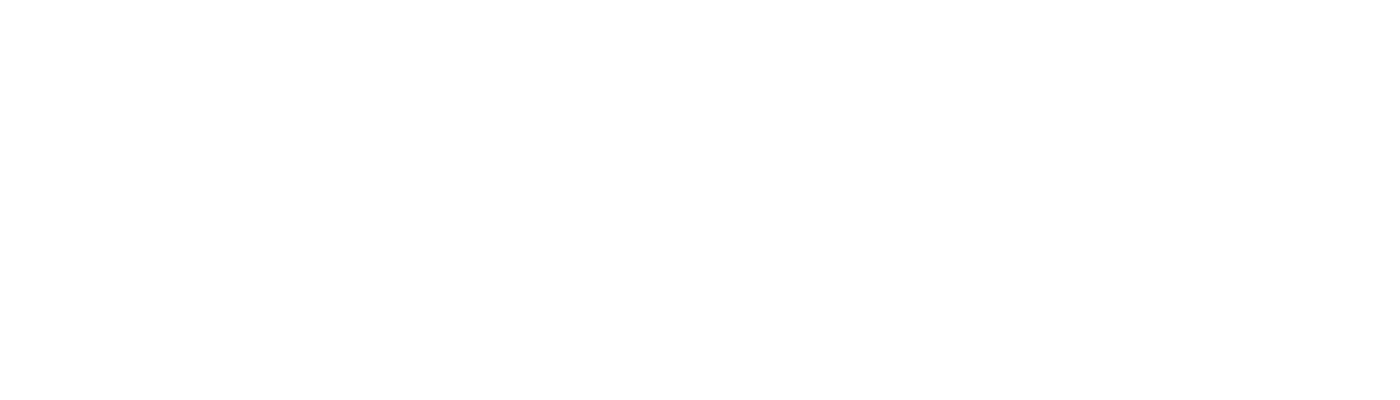

a370_SN_sourceplane/lenstool_files/bin_36.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_73_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


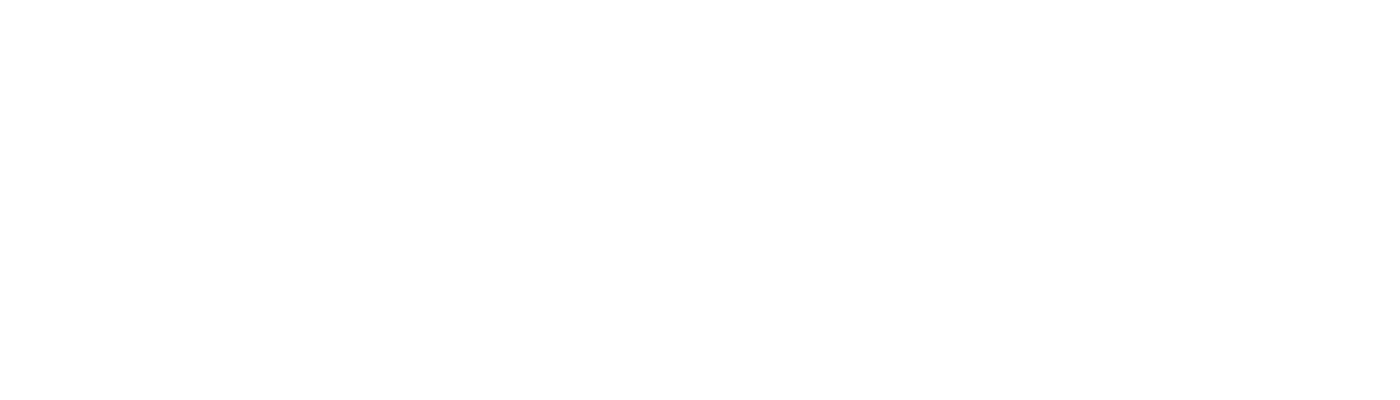

a370_SN_sourceplane/lenstool_files/bin_73.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_28_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


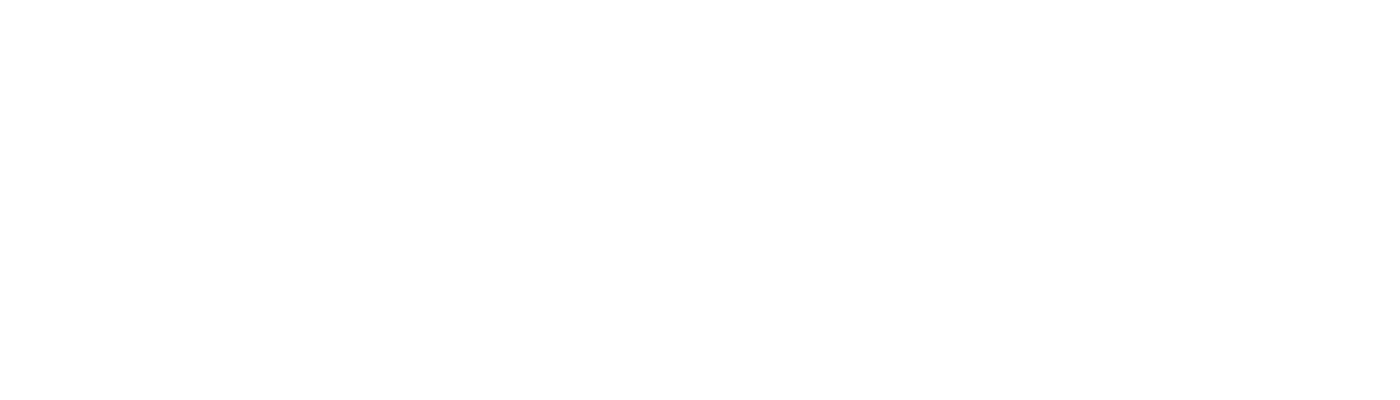

a370_SN_sourceplane/lenstool_files/bin_28.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_47_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


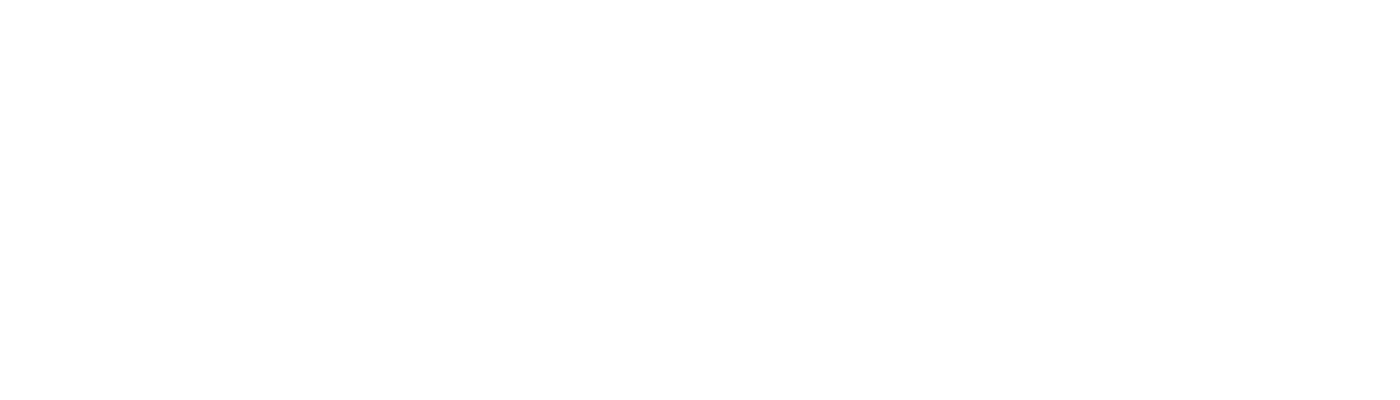

a370_SN_sourceplane/lenstool_files/bin_47.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_88_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


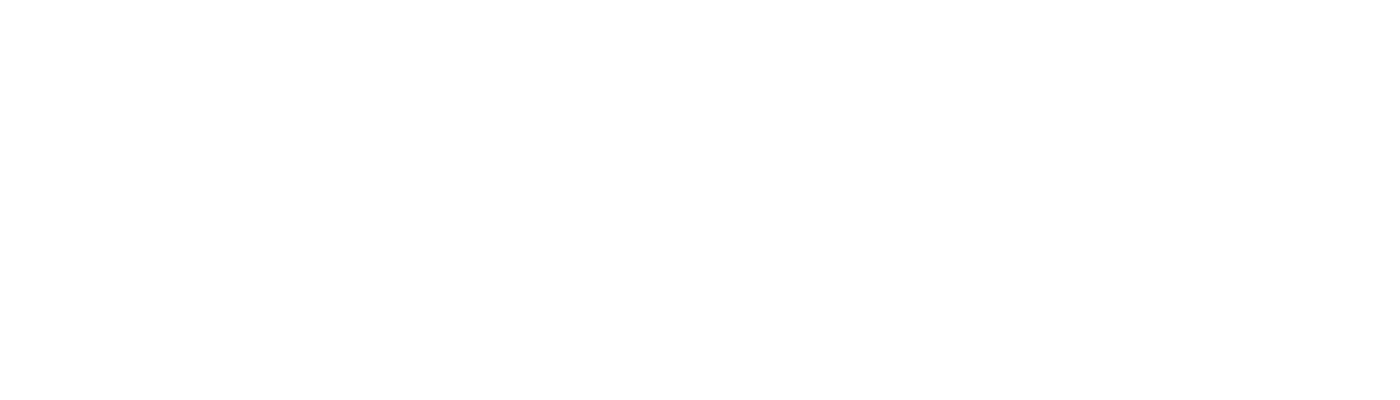

a370_SN_sourceplane/lenstool_files/bin_88.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_59_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


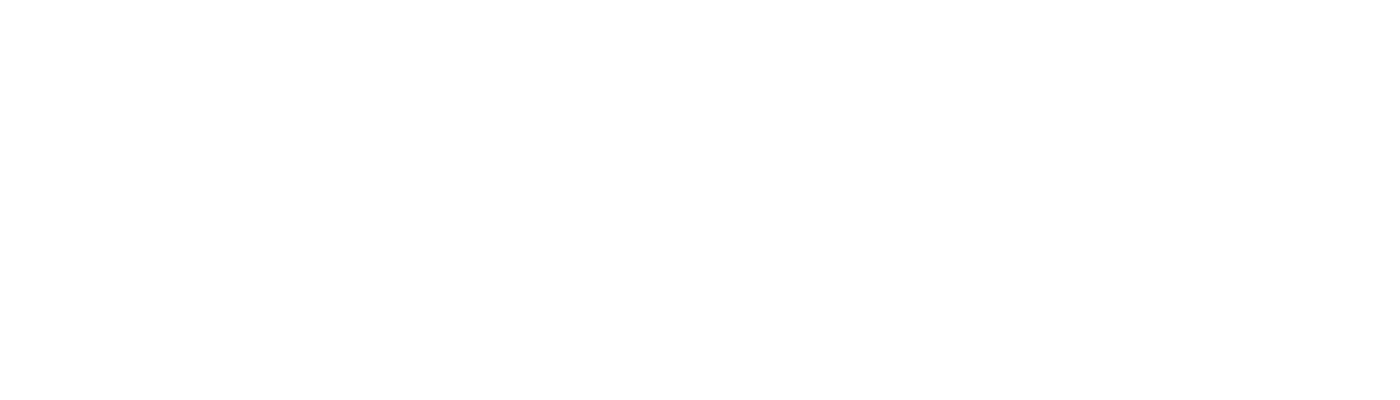

a370_SN_sourceplane/lenstool_files/bin_59.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_39_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


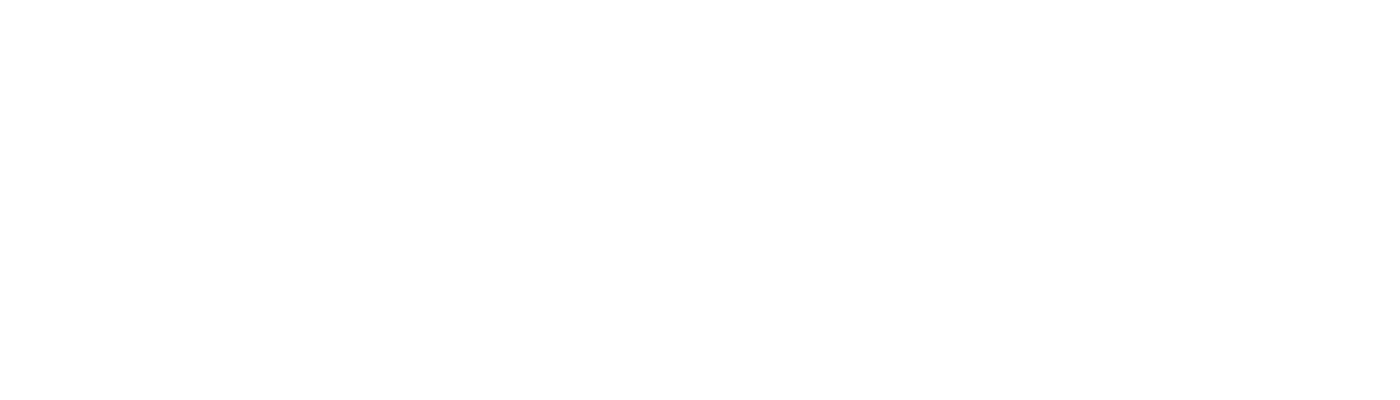

a370_SN_sourceplane/lenstool_files/bin_39.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_62_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


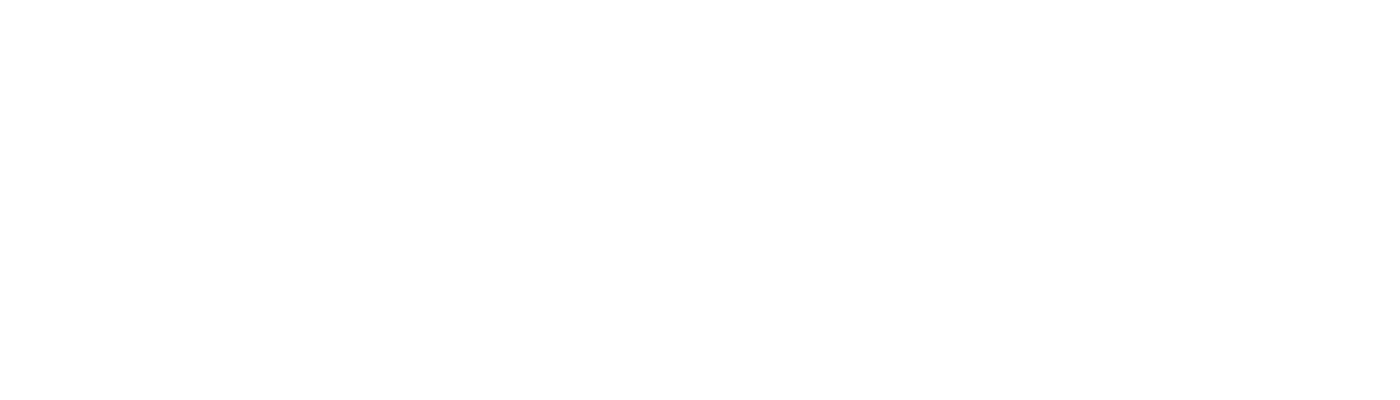

a370_SN_sourceplane/lenstool_files/bin_62.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_27_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


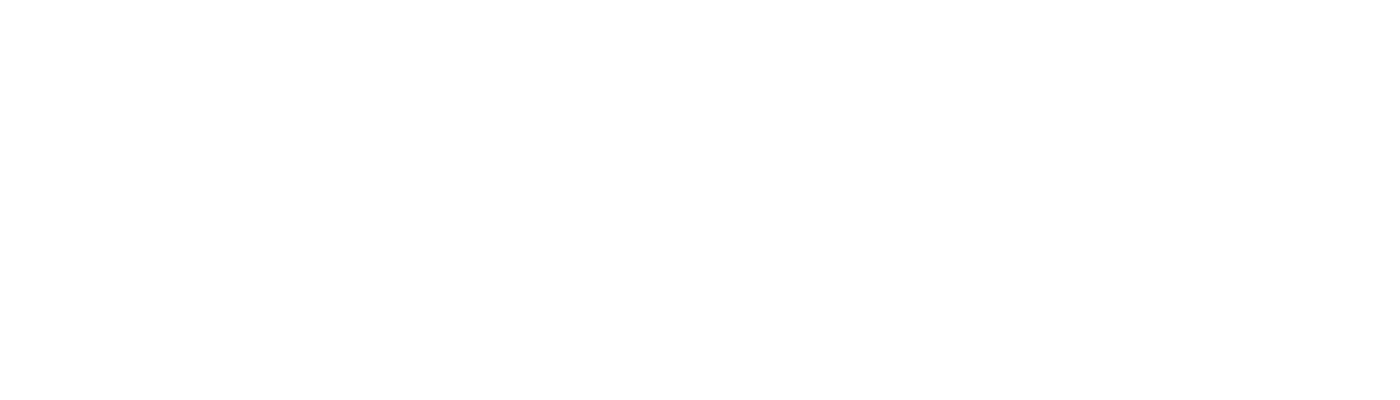

a370_SN_sourceplane/lenstool_files/bin_27.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_1_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


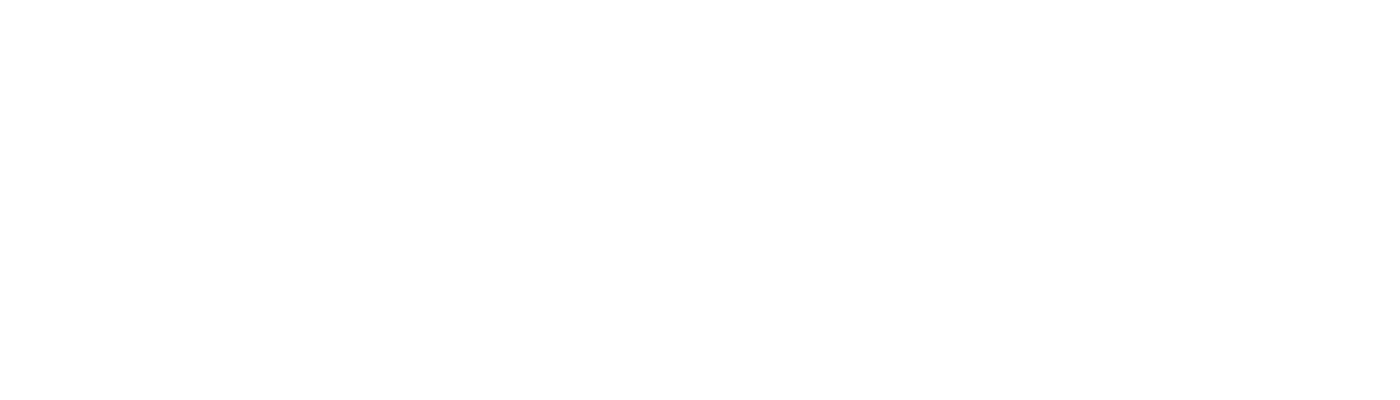

a370_SN_sourceplane/lenstool_files/bin_1.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_14_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


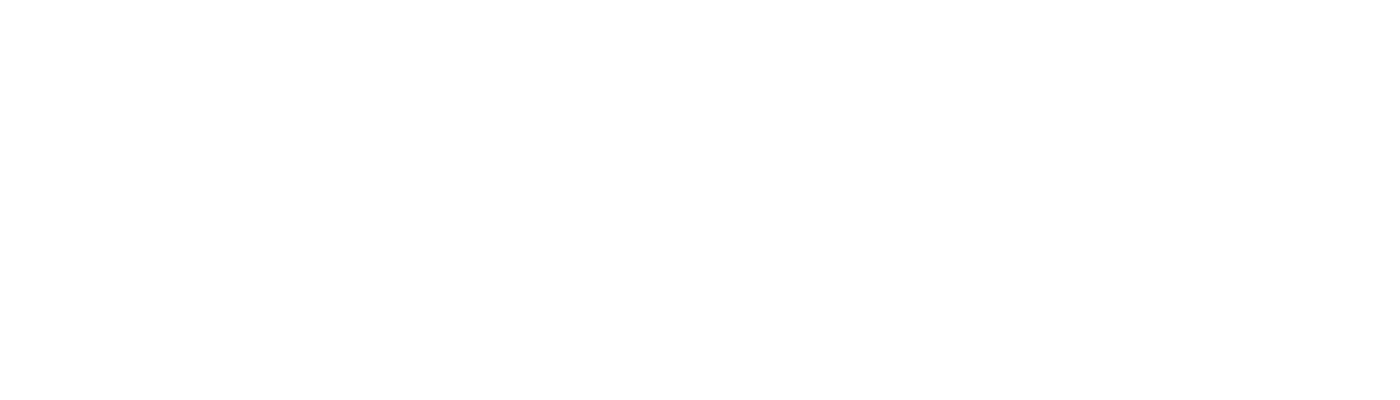

a370_SN_sourceplane/lenstool_files/bin_14.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_80_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


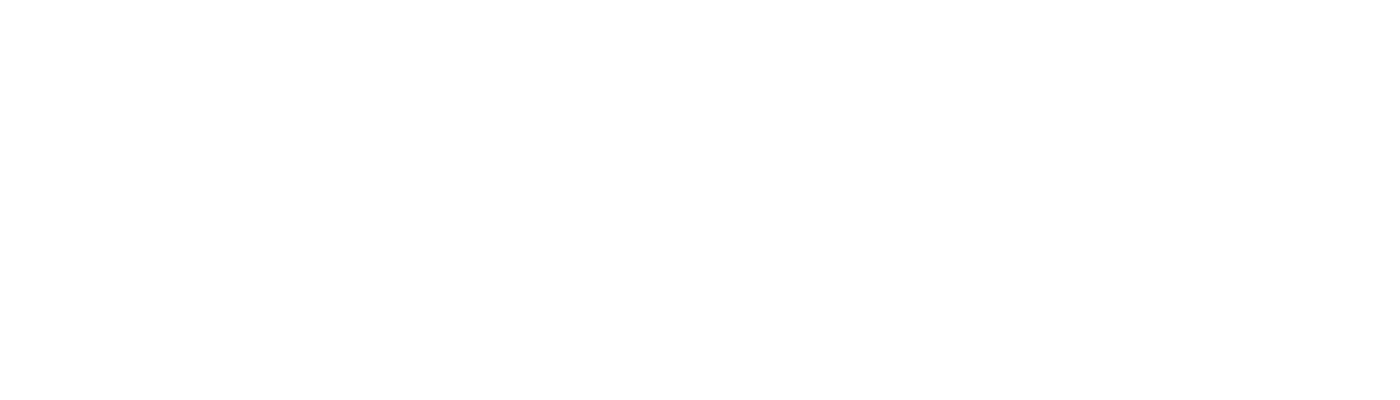

a370_SN_sourceplane/lenstool_files/bin_80.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_51_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


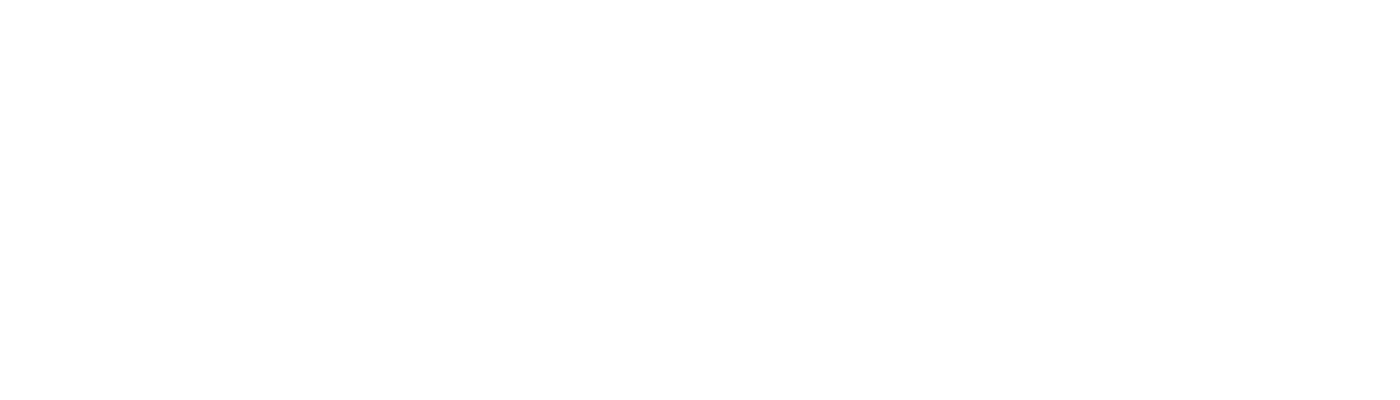

a370_SN_sourceplane/lenstool_files/bin_51.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_31_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


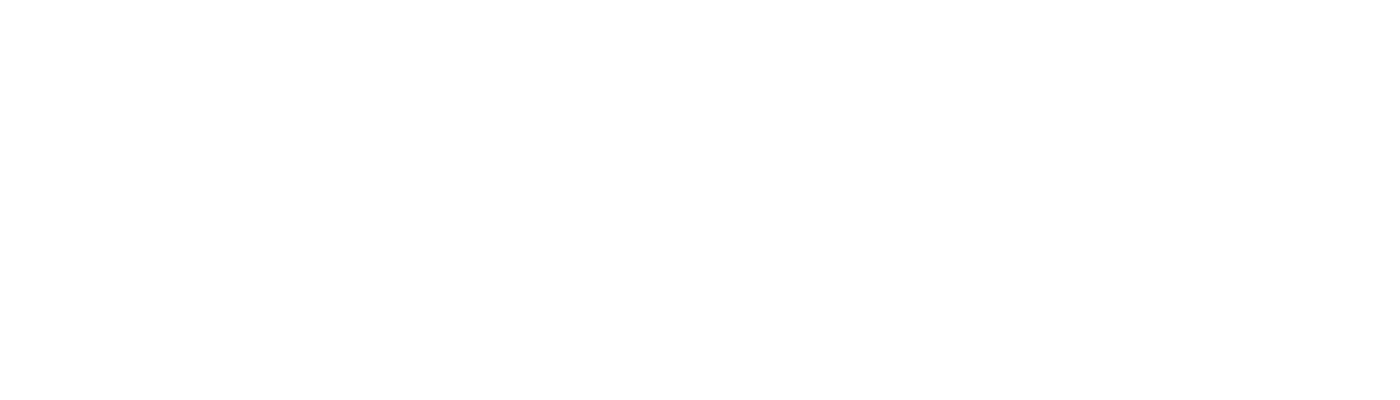

a370_SN_sourceplane/lenstool_files/bin_31.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_74_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


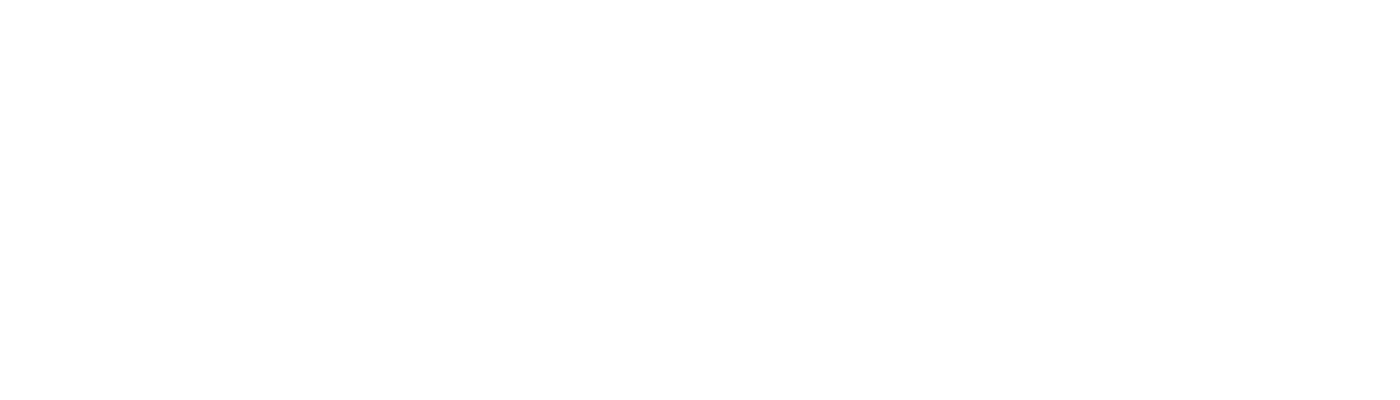

a370_SN_sourceplane/lenstool_files/bin_74.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_9_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


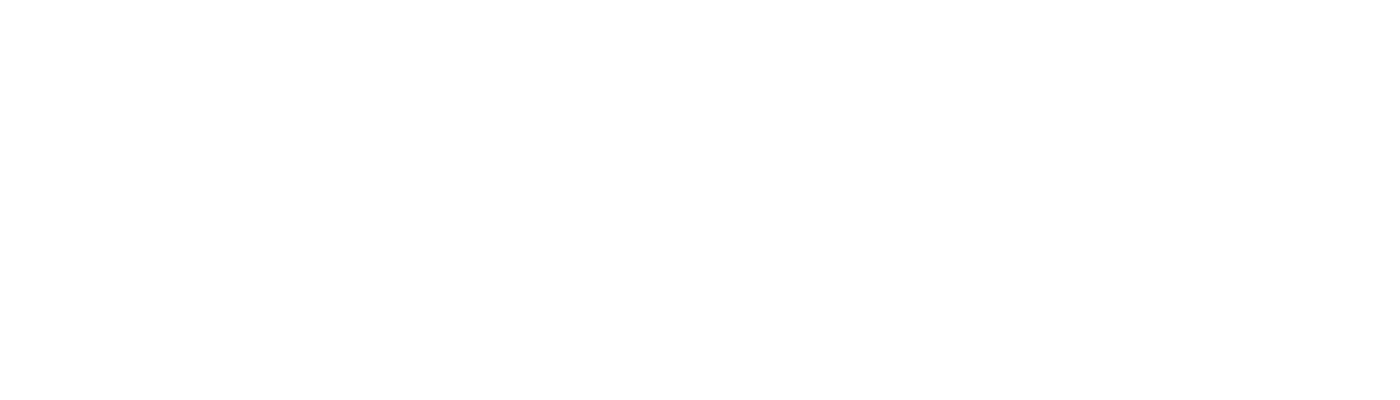

a370_SN_sourceplane/lenstool_files/bin_9.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_40_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


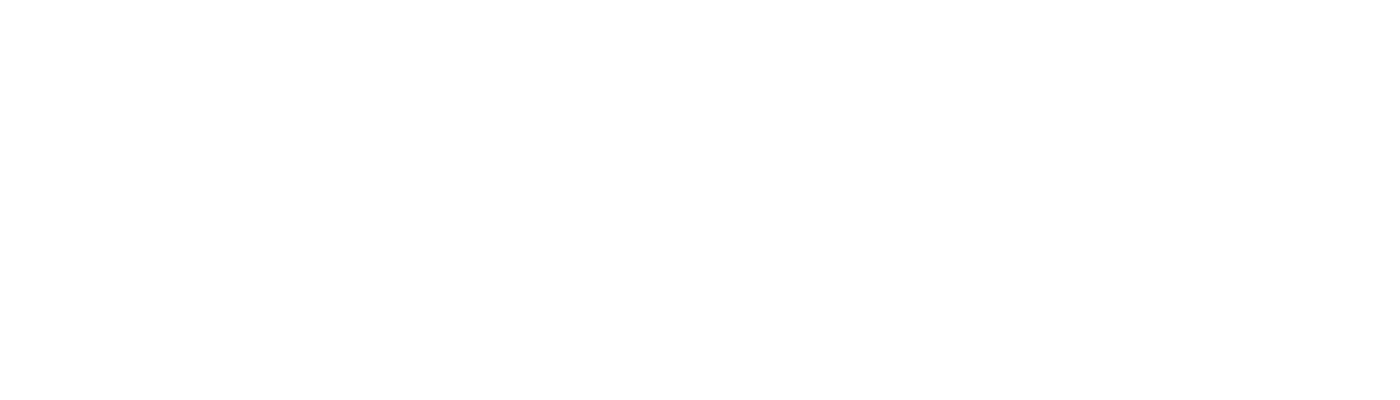

a370_SN_sourceplane/lenstool_files/bin_40.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_91_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


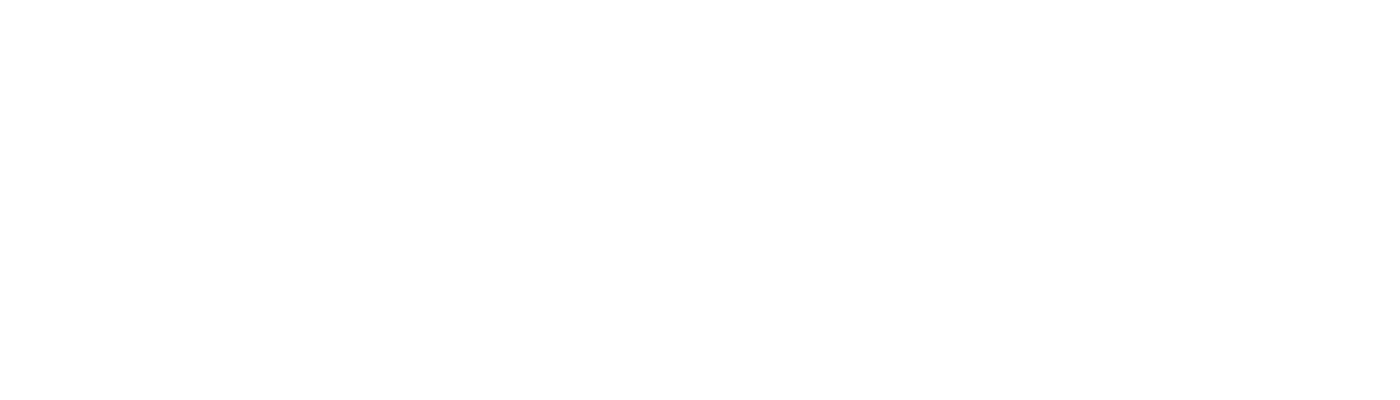

a370_SN_sourceplane/lenstool_files/bin_91.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_6_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


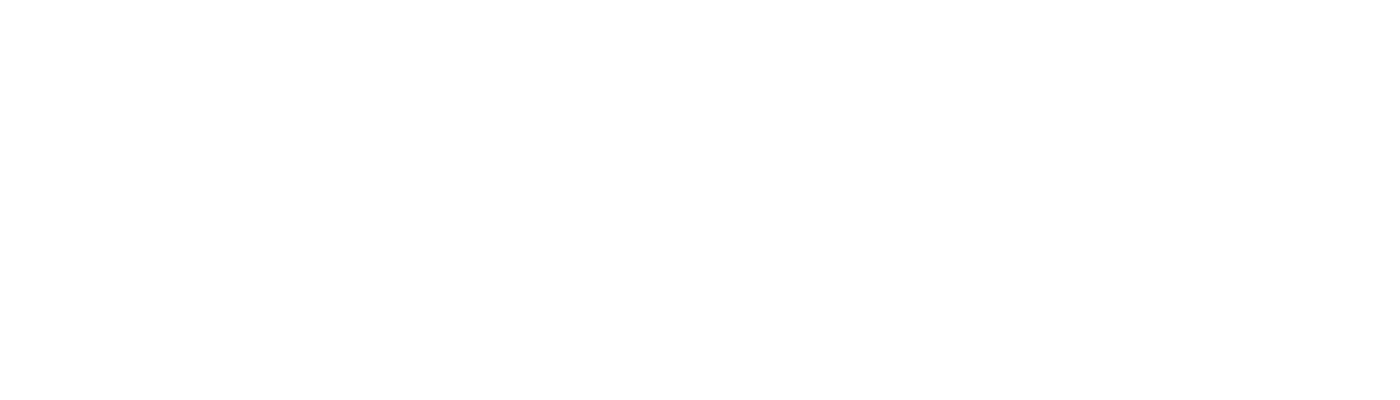

a370_SN_sourceplane/lenstool_files/bin_6.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_65_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


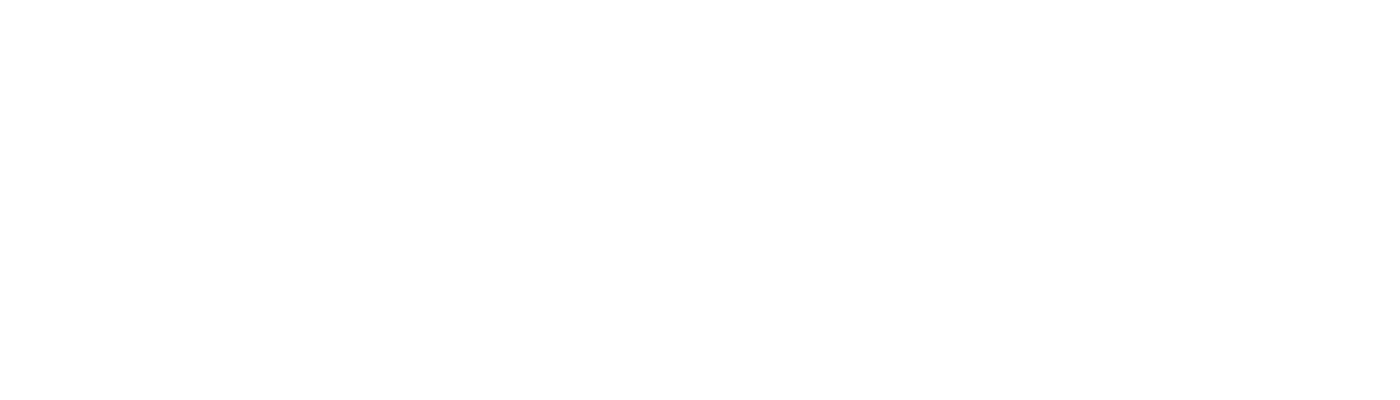

a370_SN_sourceplane/lenstool_files/bin_65.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_20_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


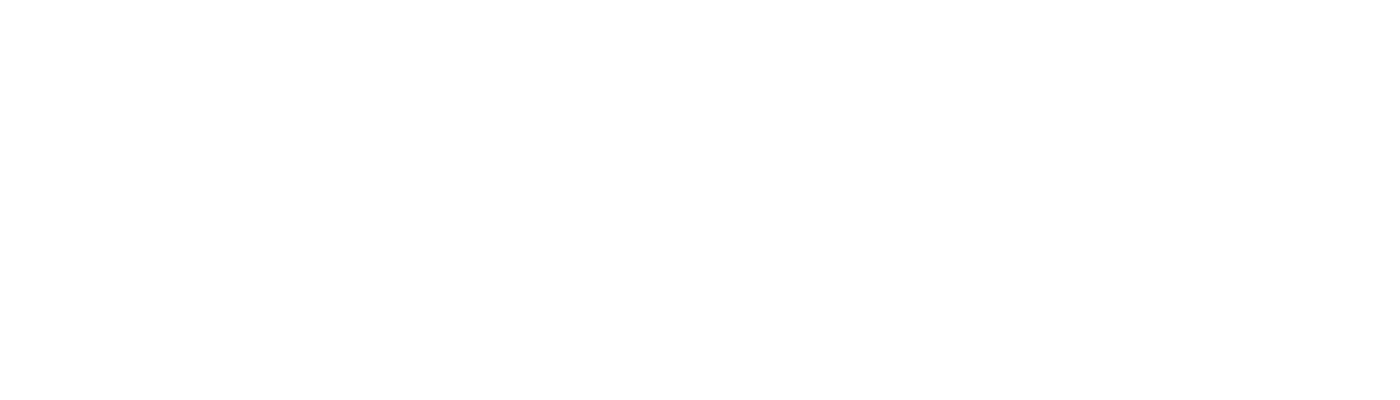

a370_SN_sourceplane/lenstool_files/bin_20.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_0_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


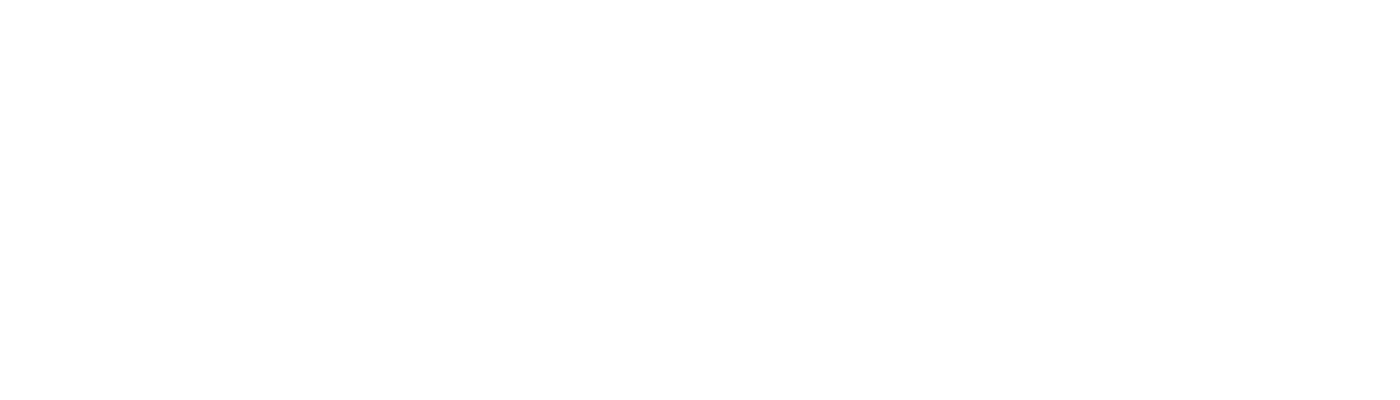

a370_SN_sourceplane/lenstool_files/bin_0.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_38_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


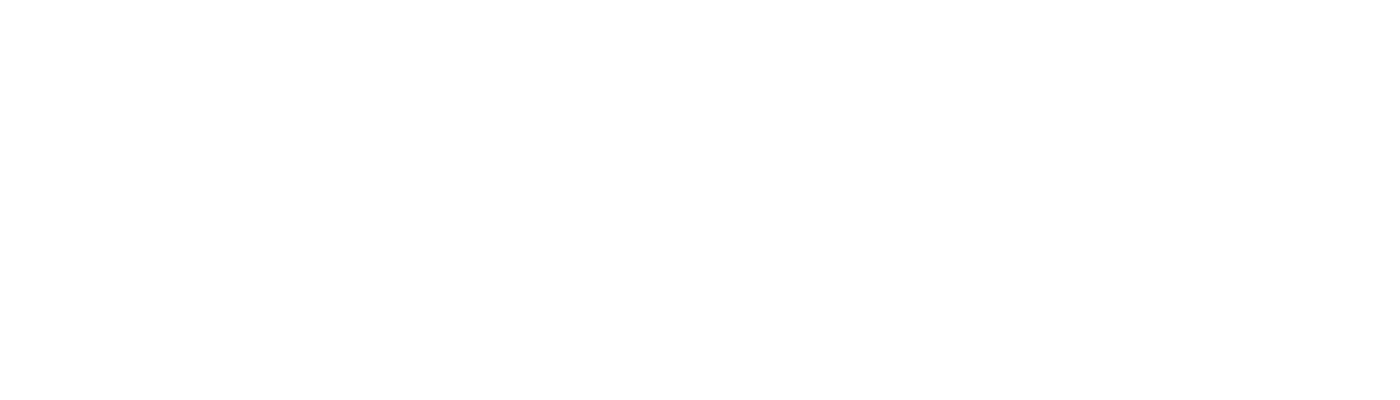

a370_SN_sourceplane/lenstool_files/bin_38.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_63_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


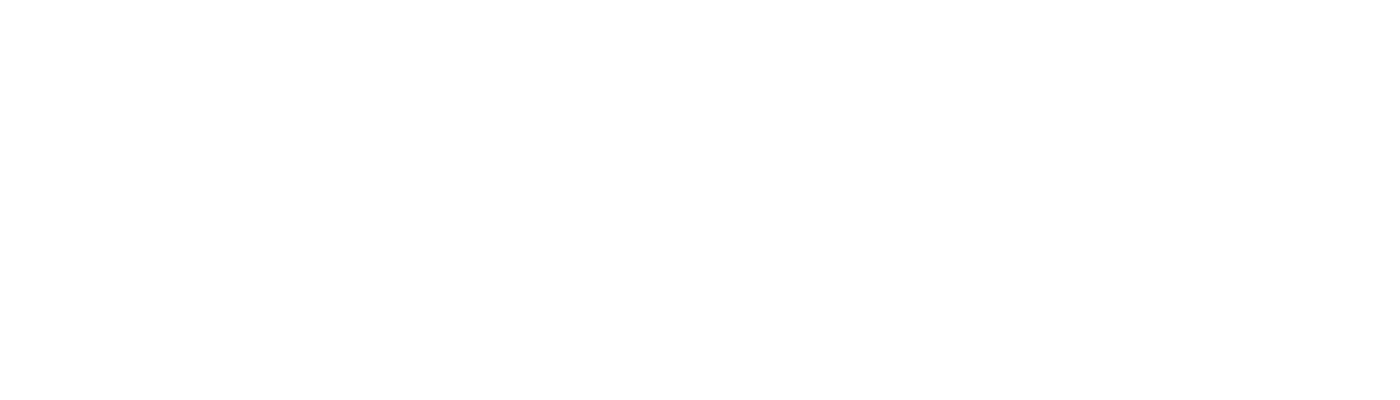

a370_SN_sourceplane/lenstool_files/bin_63.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_26_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


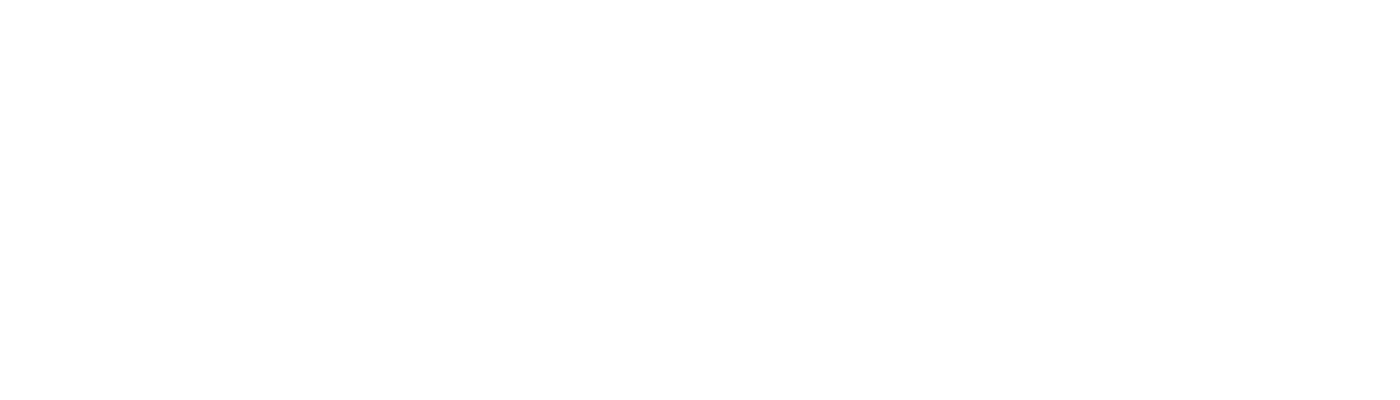

a370_SN_sourceplane/lenstool_files/bin_26.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_46_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


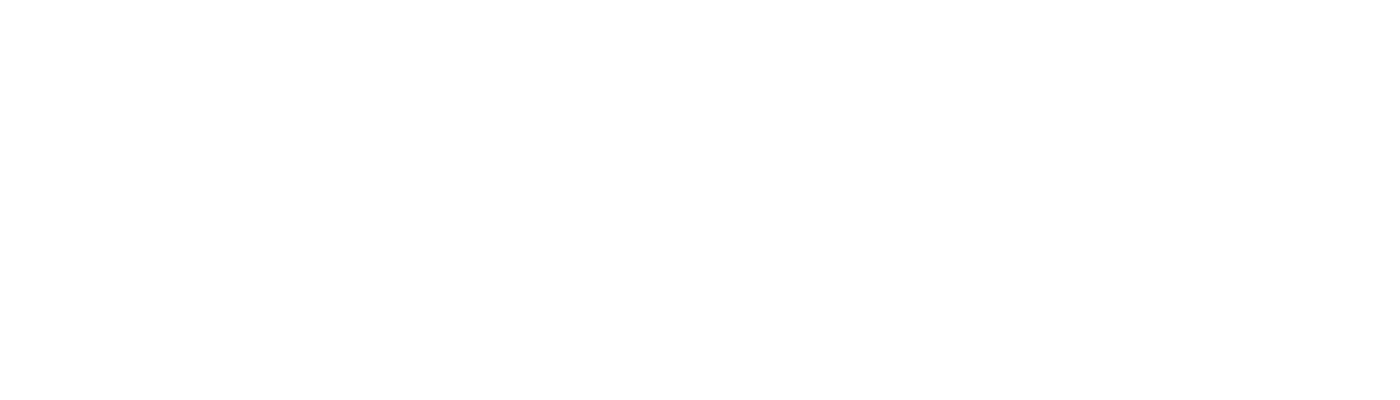

a370_SN_sourceplane/lenstool_files/bin_46.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_89_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


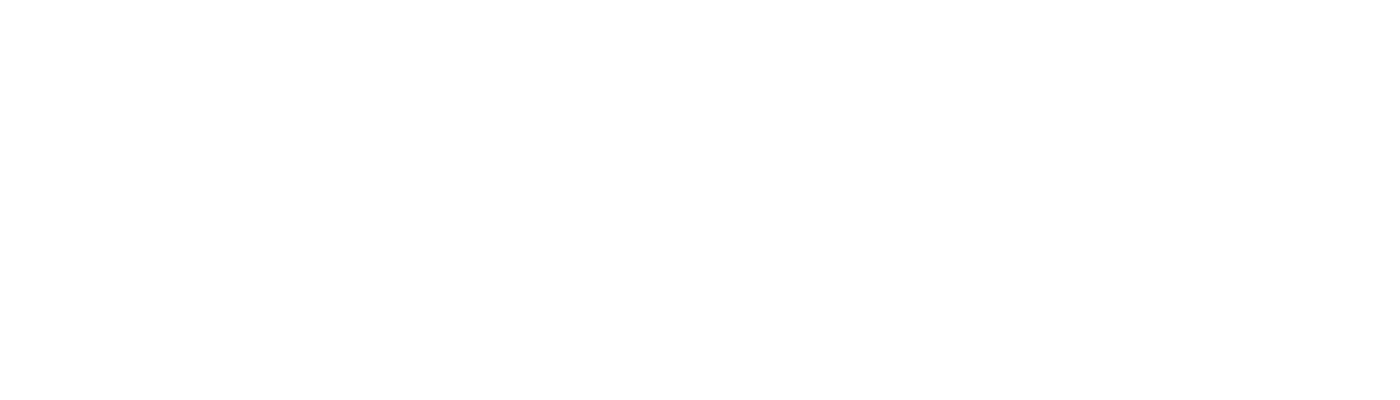

a370_SN_sourceplane/lenstool_files/bin_89.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_58_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


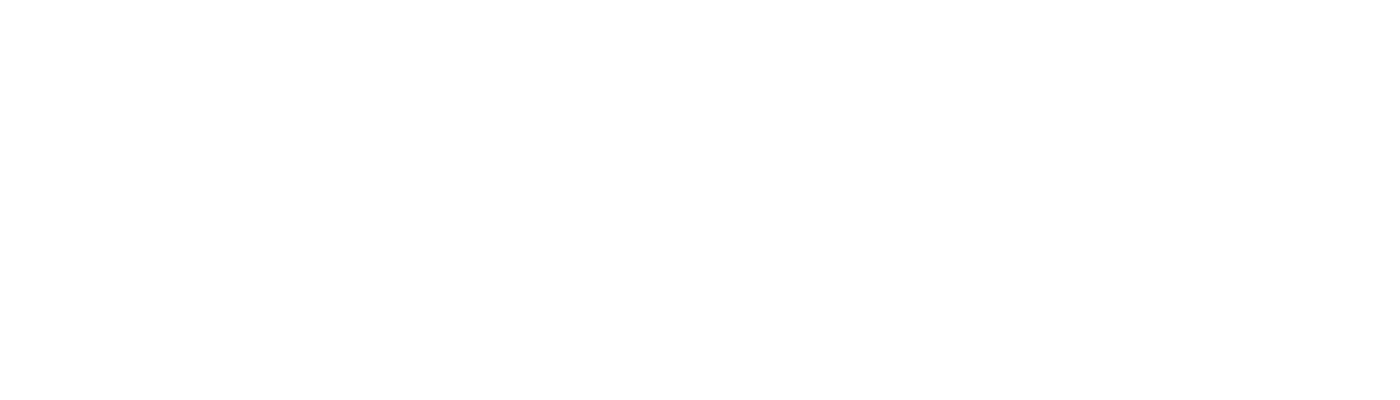

a370_SN_sourceplane/lenstool_files/bin_58.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_37_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


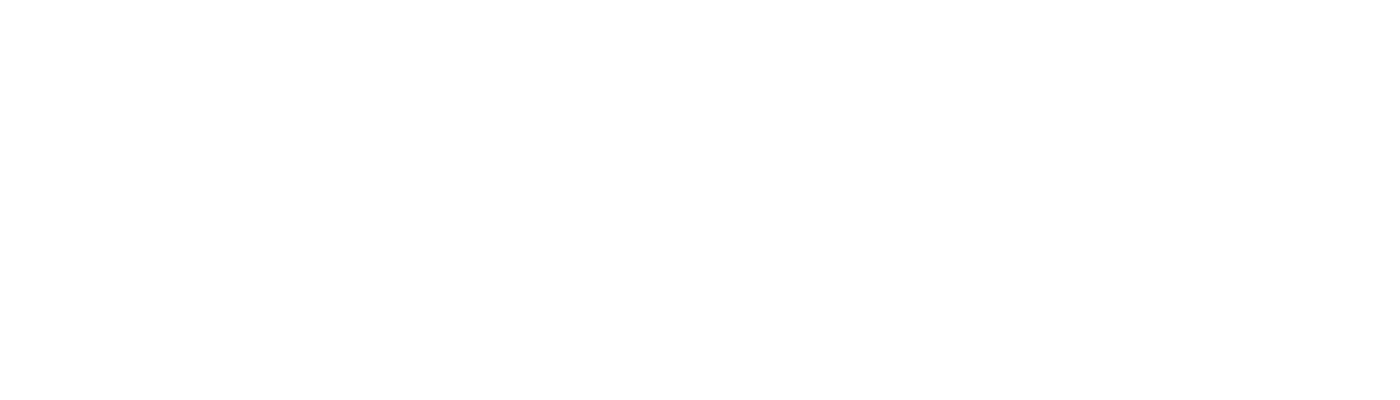

a370_SN_sourceplane/lenstool_files/bin_37.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_72_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


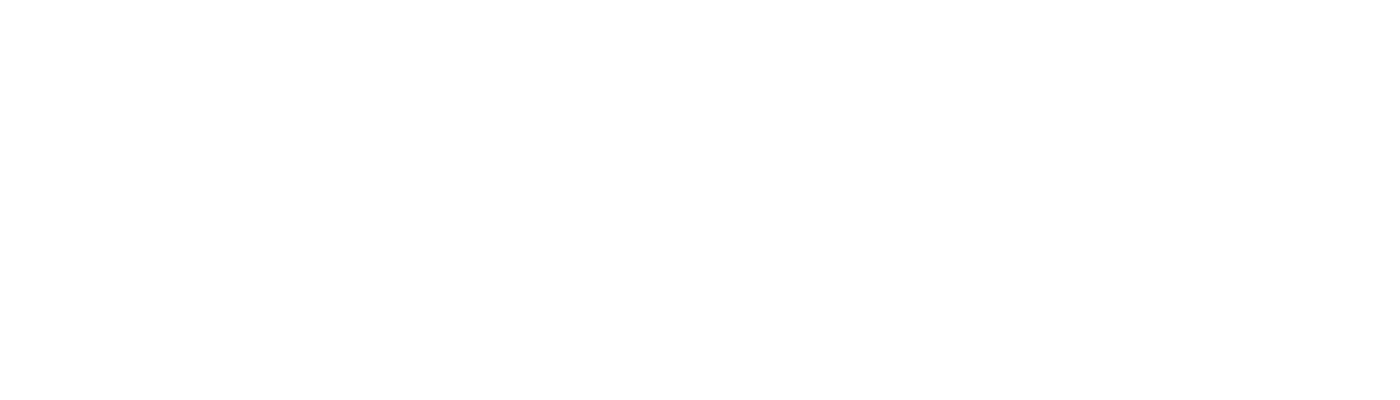

a370_SN_sourceplane/lenstool_files/bin_72.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_29_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


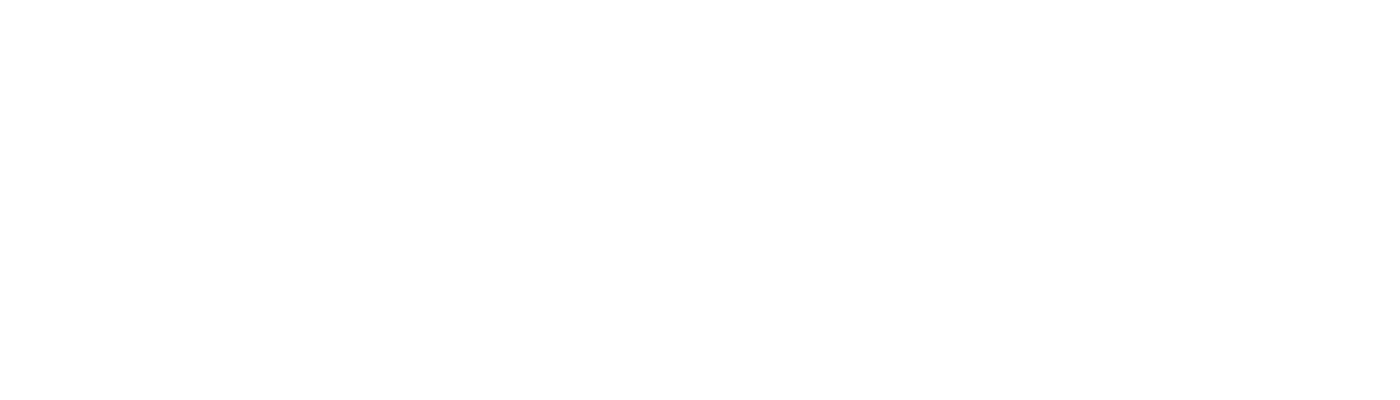

a370_SN_sourceplane/lenstool_files/bin_29.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_49_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


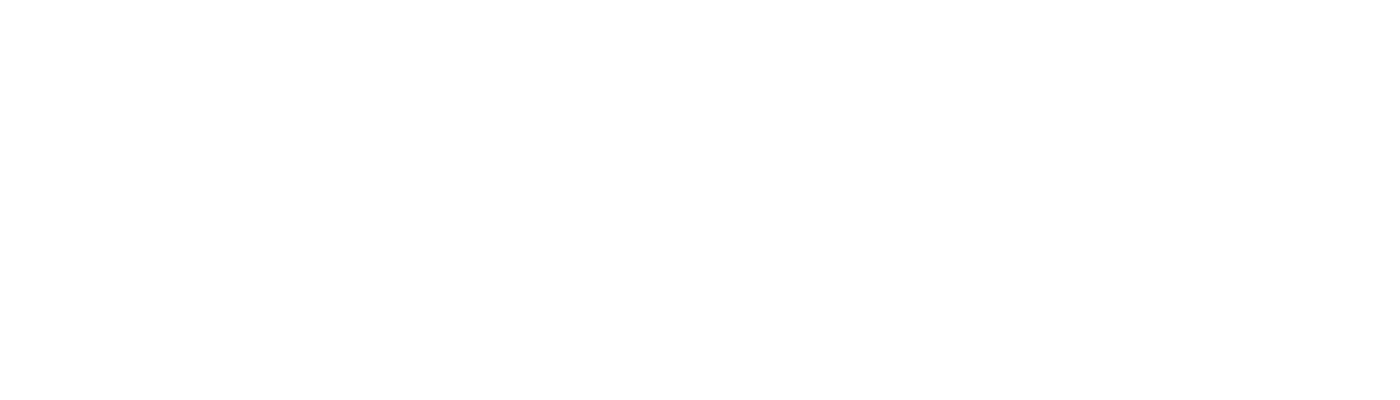

a370_SN_sourceplane/lenstool_files/bin_49.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_12_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


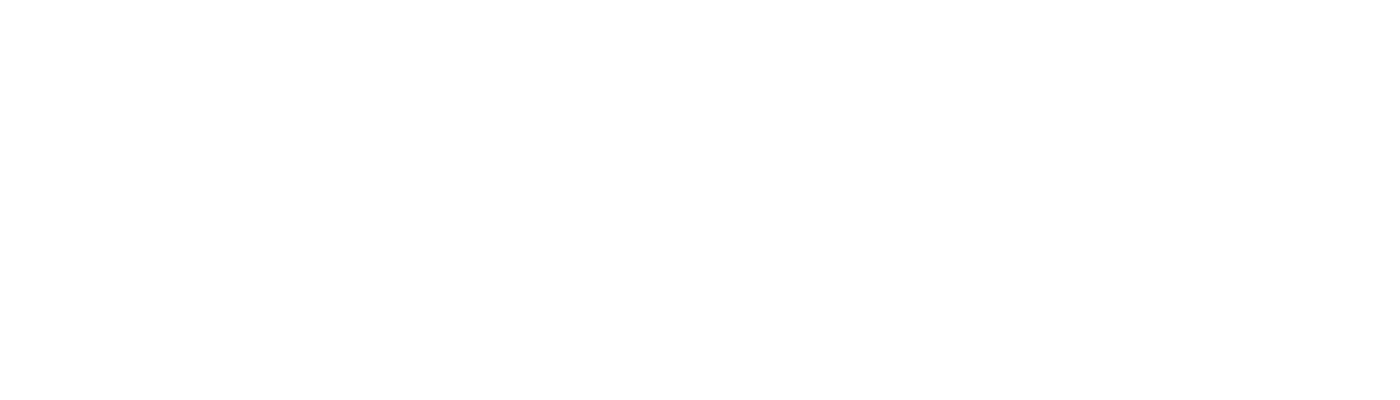

a370_SN_sourceplane/lenstool_files/bin_12.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_86_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


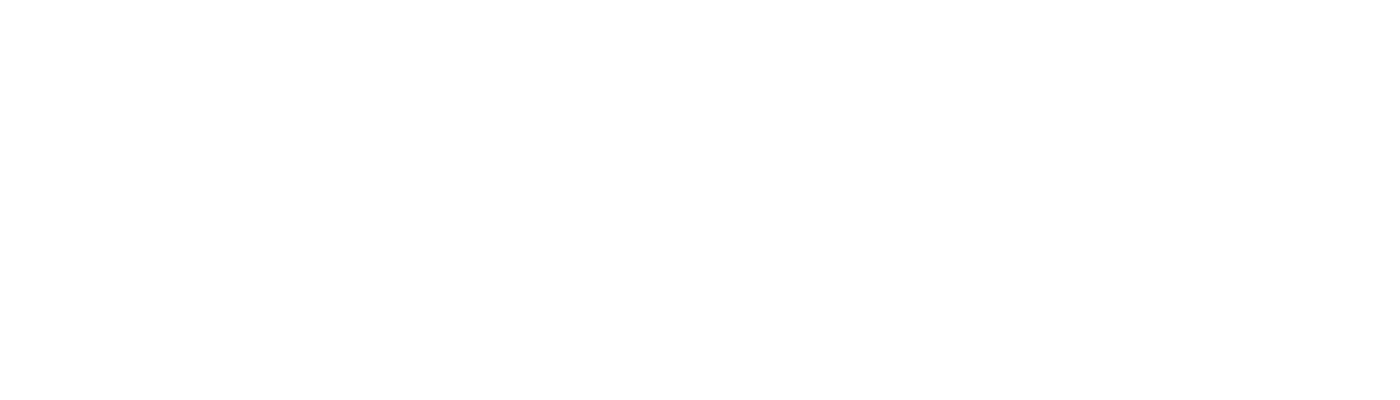

a370_SN_sourceplane/lenstool_files/bin_86.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_57_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


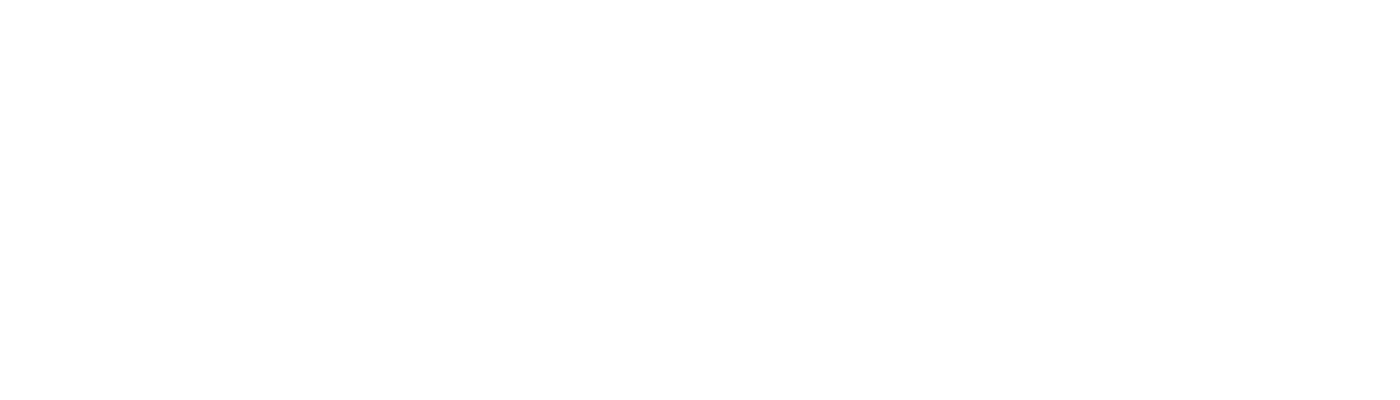

a370_SN_sourceplane/lenstool_files/bin_57.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_64_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


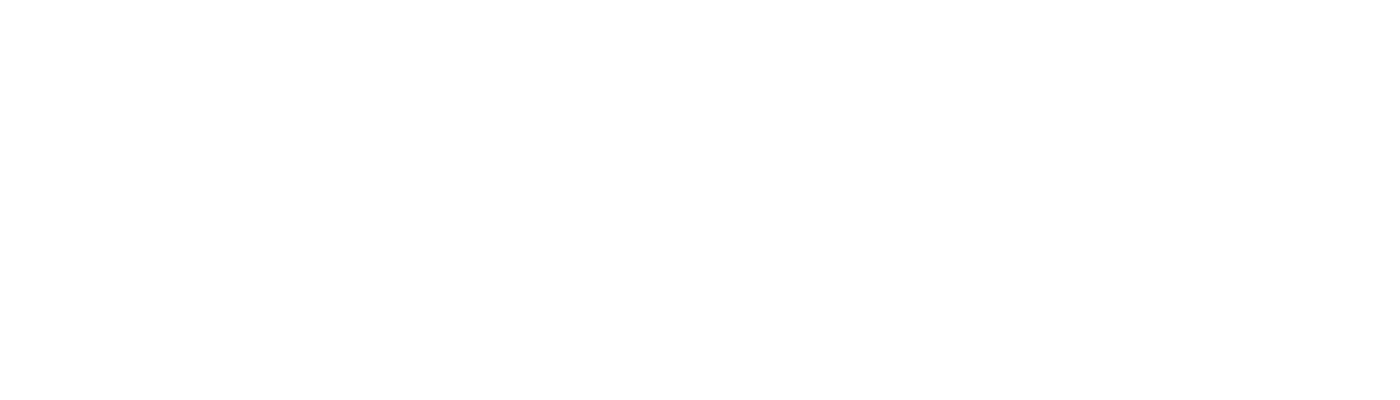

a370_SN_sourceplane/lenstool_files/bin_64.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_21_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


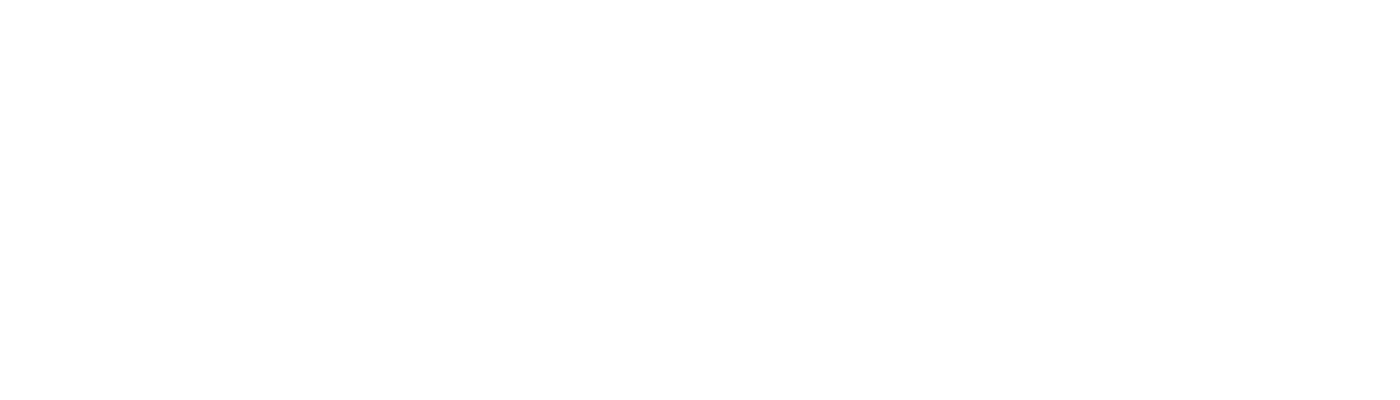

a370_SN_sourceplane/lenstool_files/bin_21.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_7_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


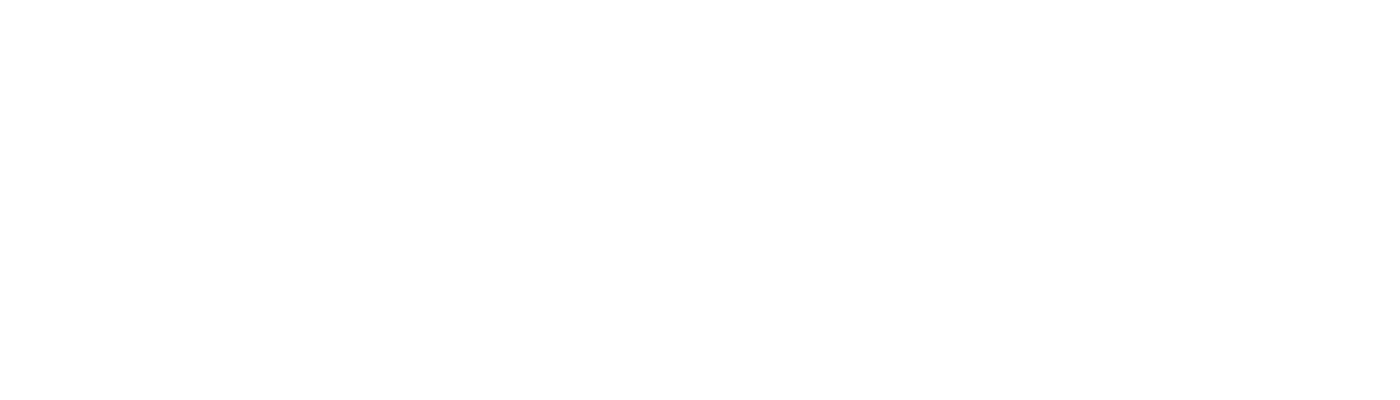

a370_SN_sourceplane/lenstool_files/bin_7.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_41_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


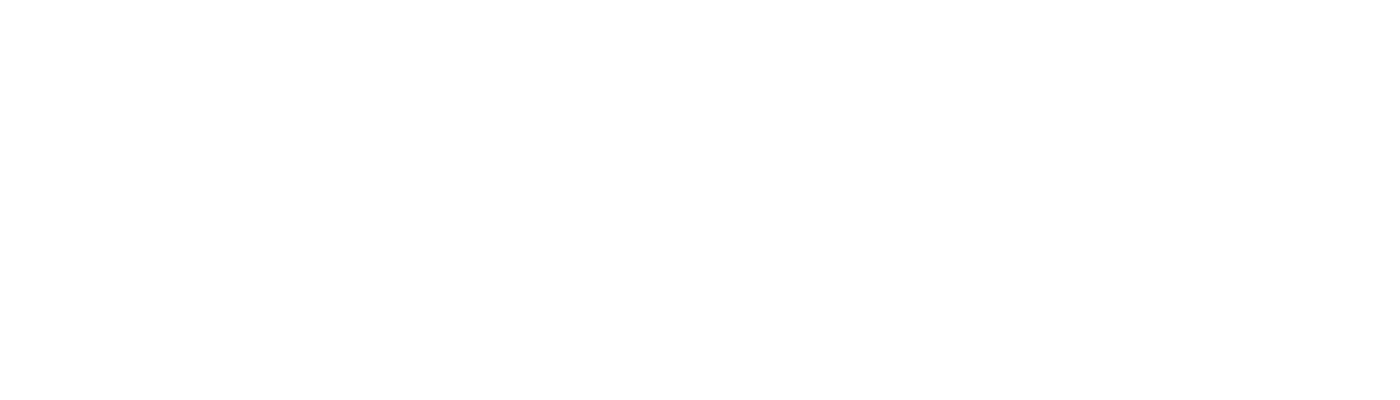

a370_SN_sourceplane/lenstool_files/bin_41.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_90_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


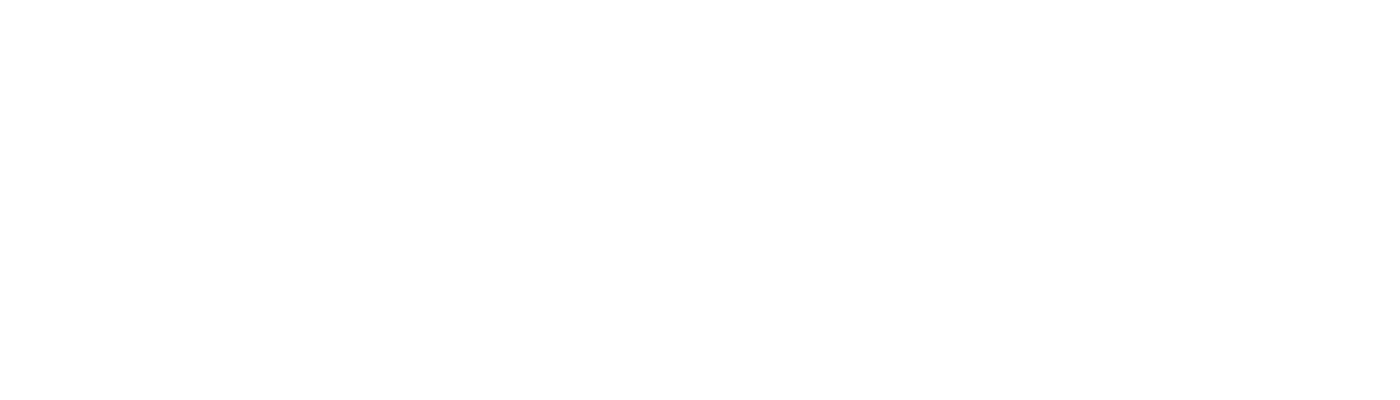

a370_SN_sourceplane/lenstool_files/bin_90.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_8_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


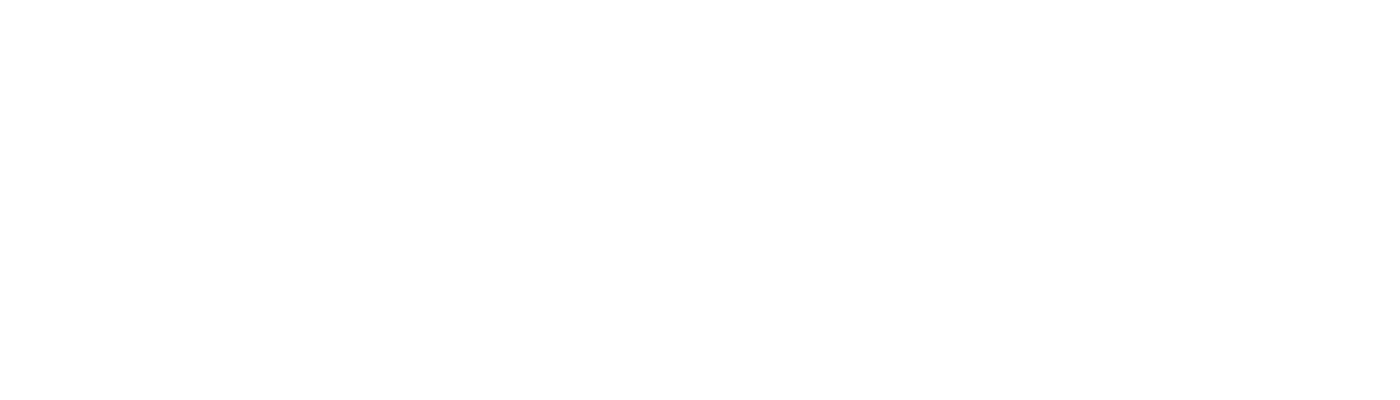

a370_SN_sourceplane/lenstool_files/bin_8.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_30_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


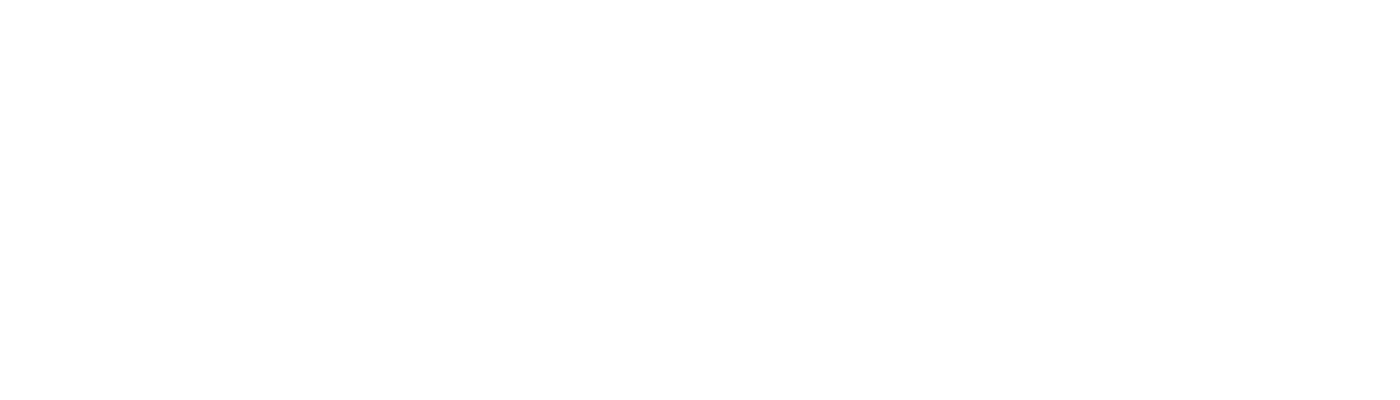

a370_SN_sourceplane/lenstool_files/bin_30.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_75_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


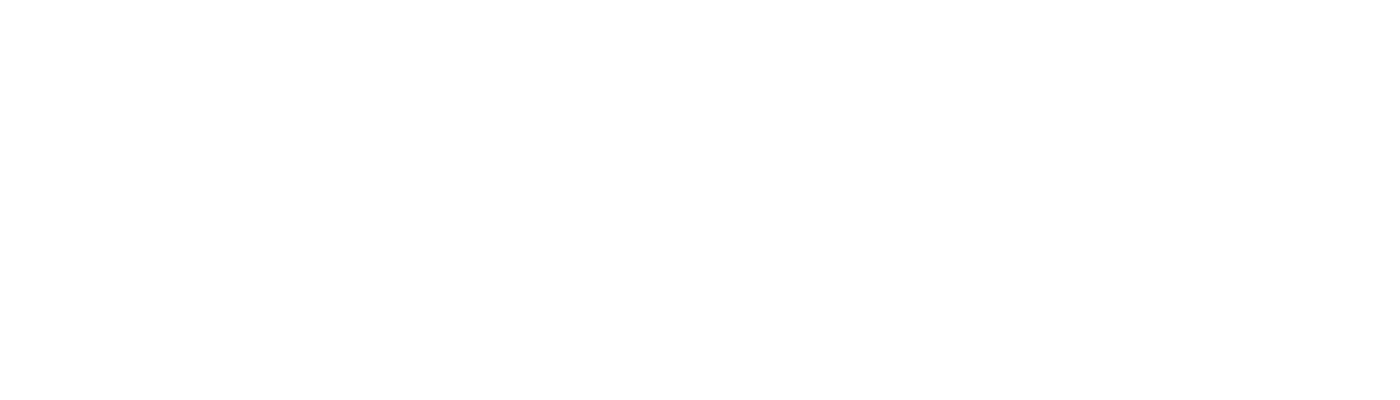

a370_SN_sourceplane/lenstool_files/bin_75.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_15_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


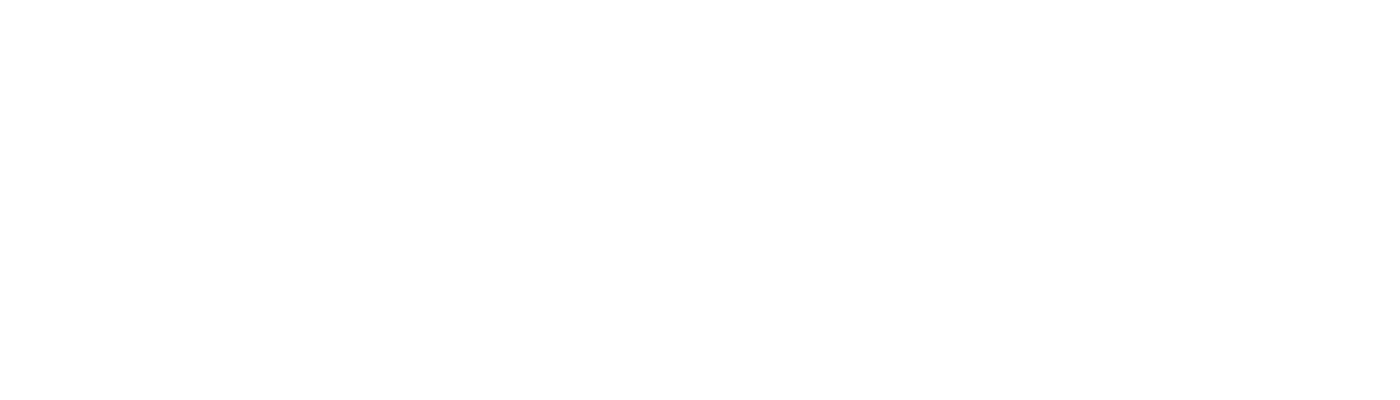

a370_SN_sourceplane/lenstool_files/bin_15.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_81_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


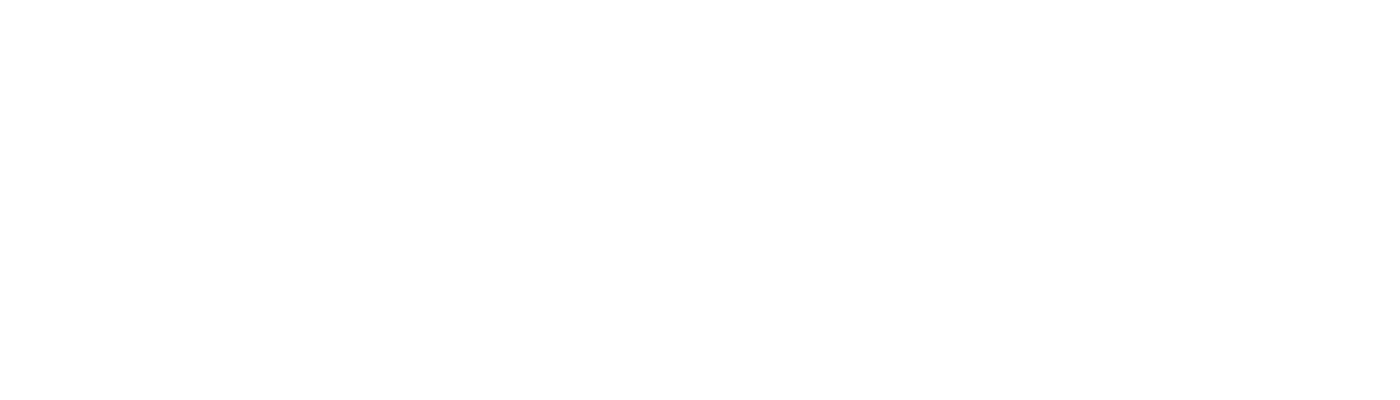

a370_SN_sourceplane/lenstool_files/bin_81.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_50_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


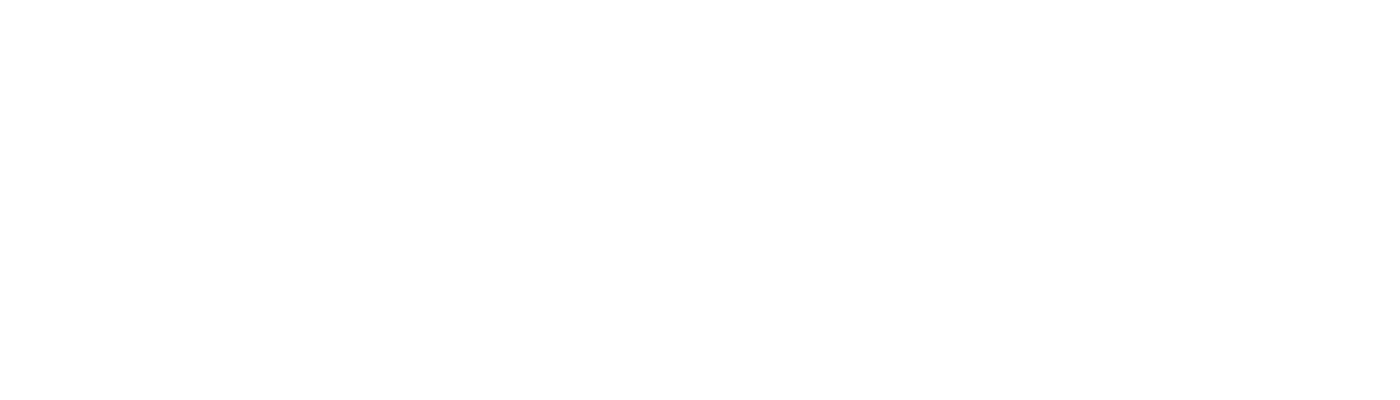

a370_SN_sourceplane/lenstool_files/bin_50.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_4_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


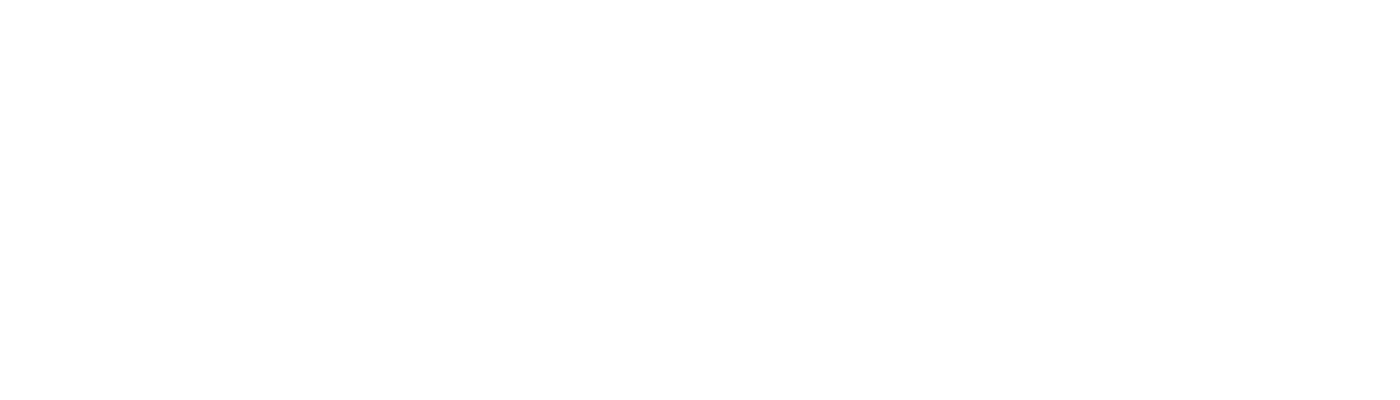

a370_SN_sourceplane/lenstool_files/bin_4.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_79_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


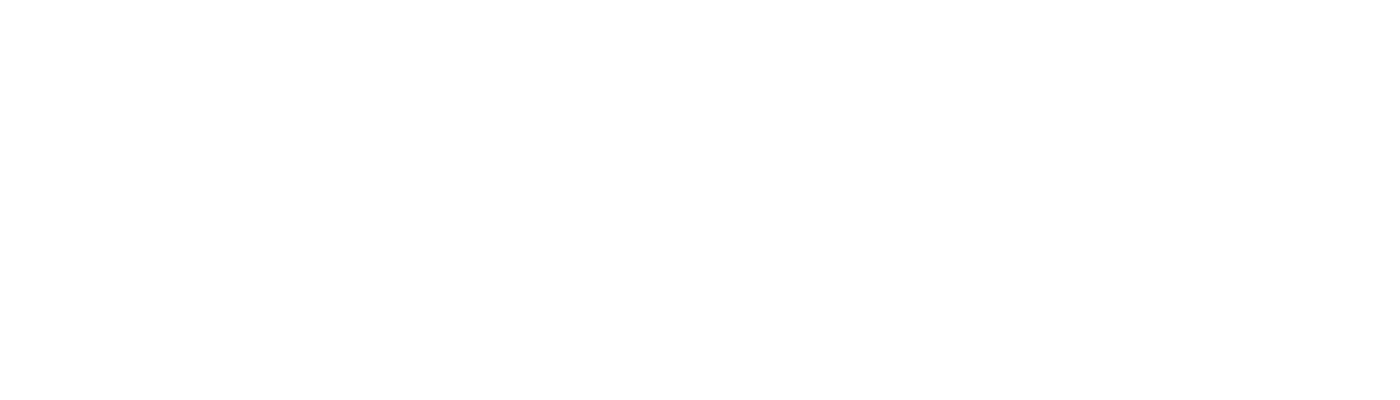

a370_SN_sourceplane/lenstool_files/bin_79.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_67_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


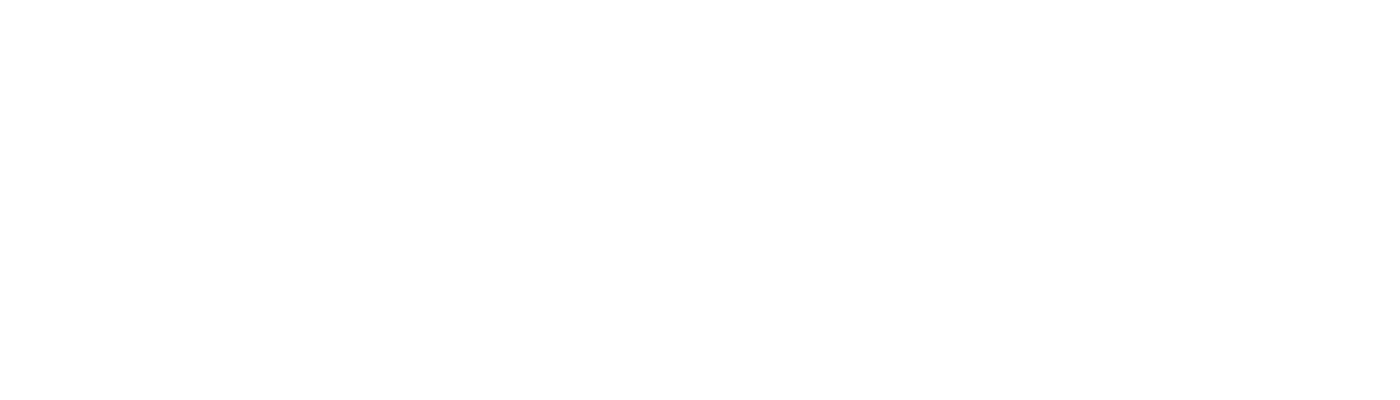

a370_SN_sourceplane/lenstool_files/bin_67.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_22_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


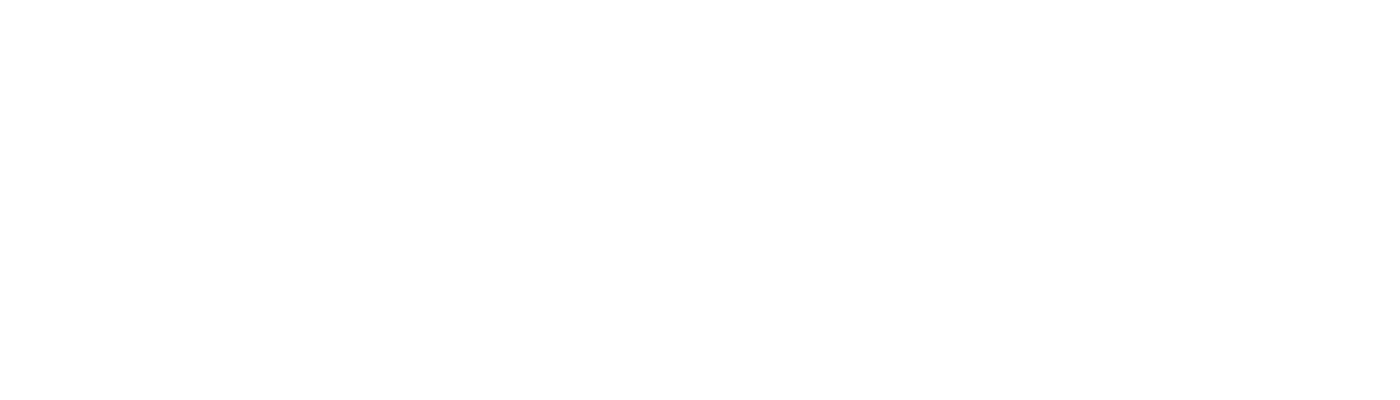

a370_SN_sourceplane/lenstool_files/bin_22.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_42_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


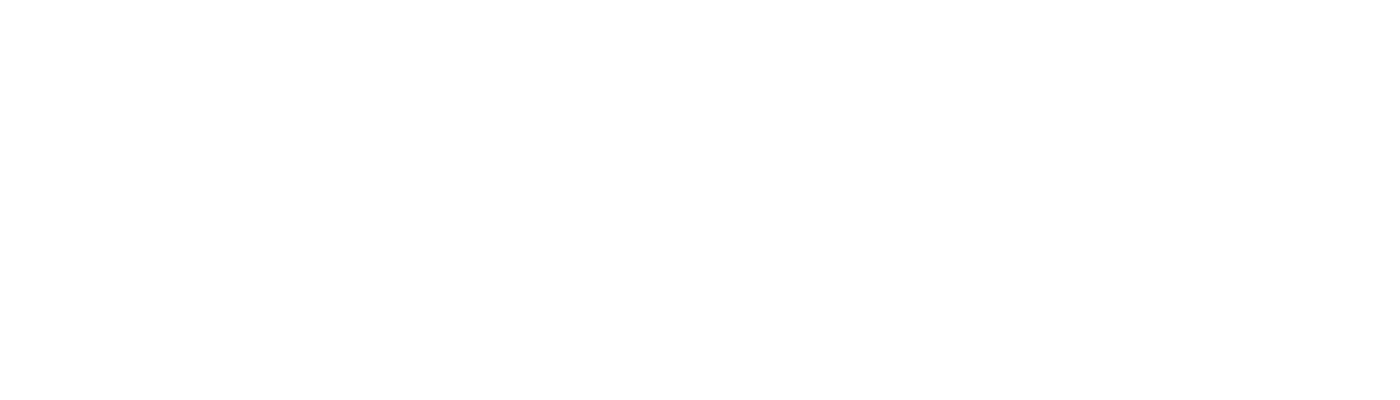

a370_SN_sourceplane/lenstool_files/bin_42.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_93_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


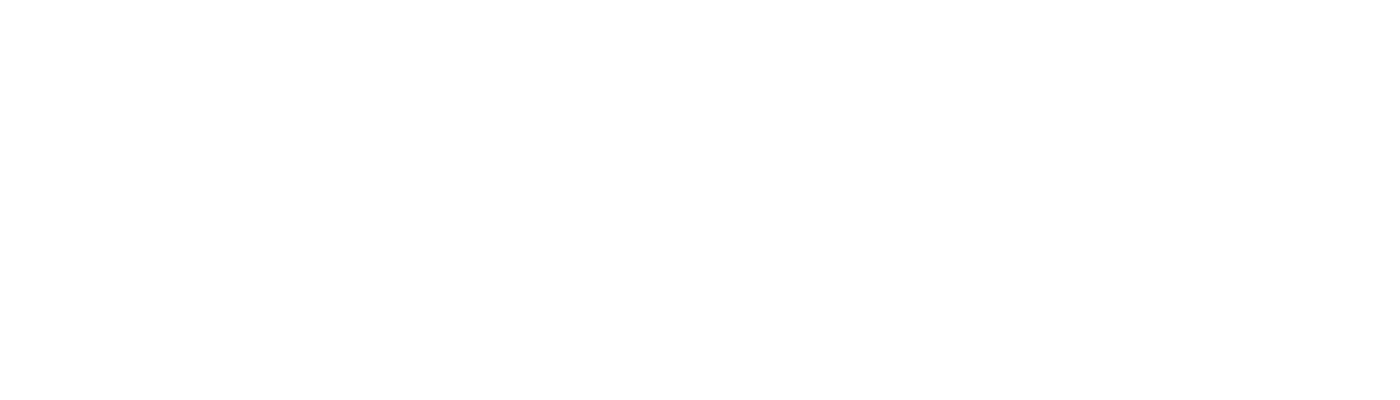

a370_SN_sourceplane/lenstool_files/bin_93.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_19_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


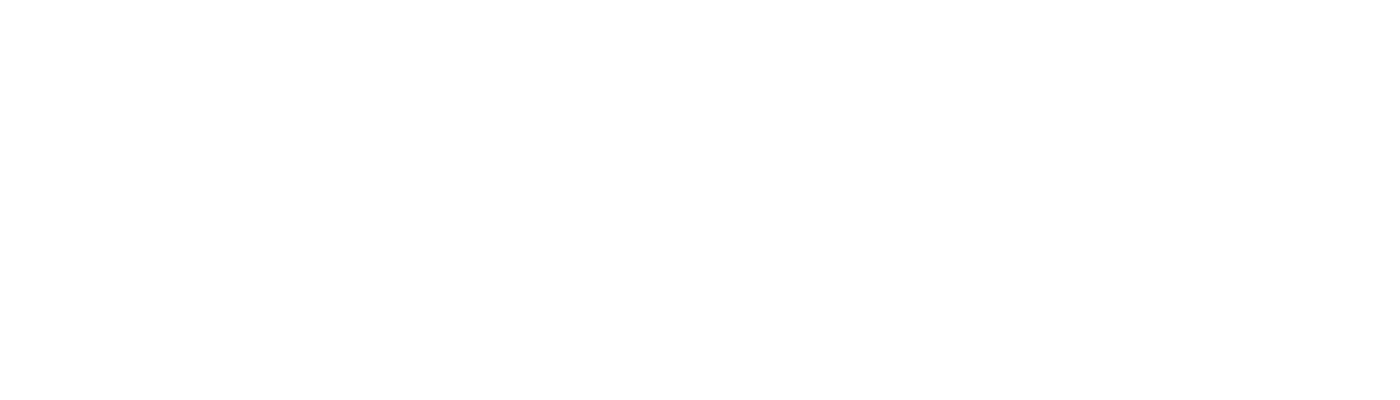

a370_SN_sourceplane/lenstool_files/bin_19.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_33_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


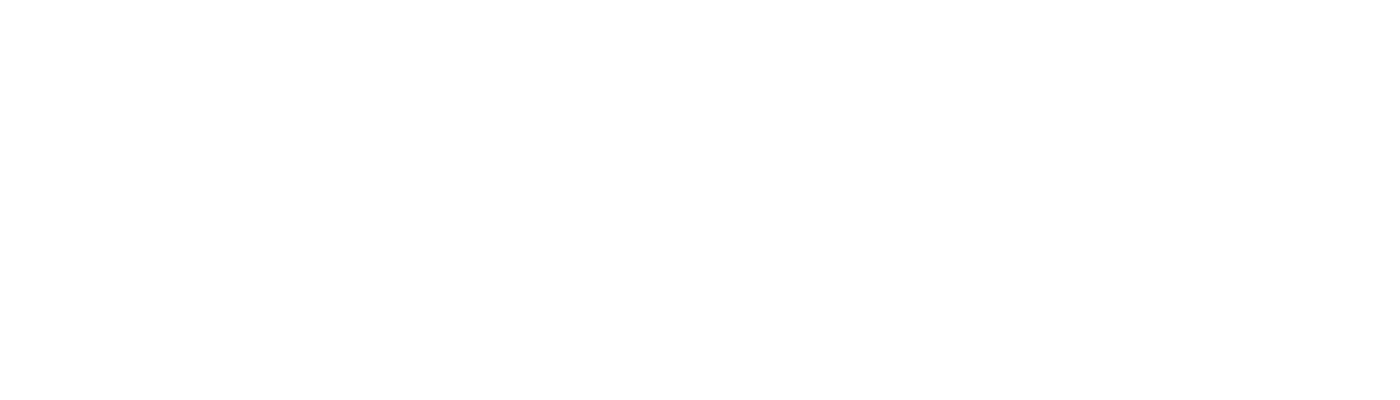

a370_SN_sourceplane/lenstool_files/bin_33.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_76_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


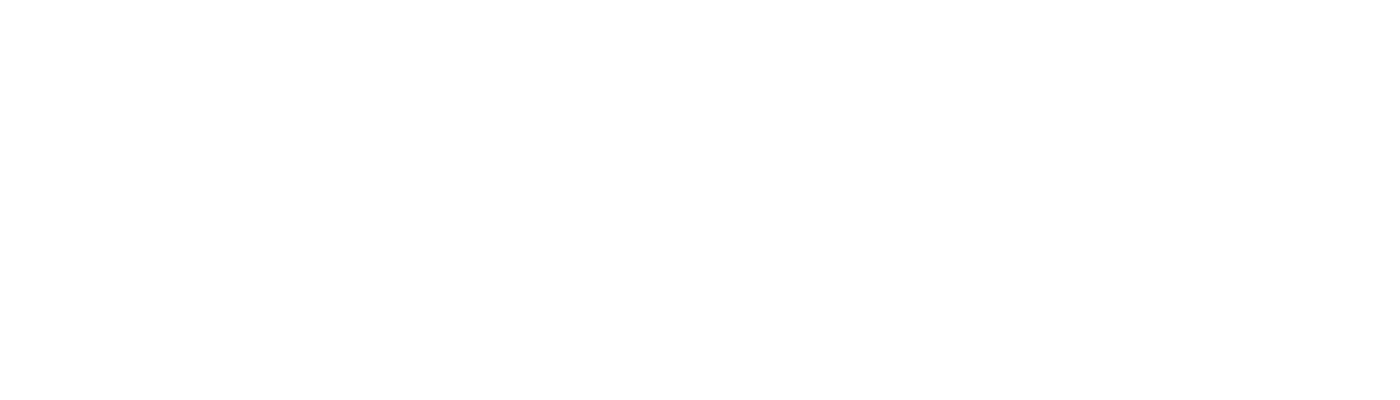

a370_SN_sourceplane/lenstool_files/bin_76.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_68_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


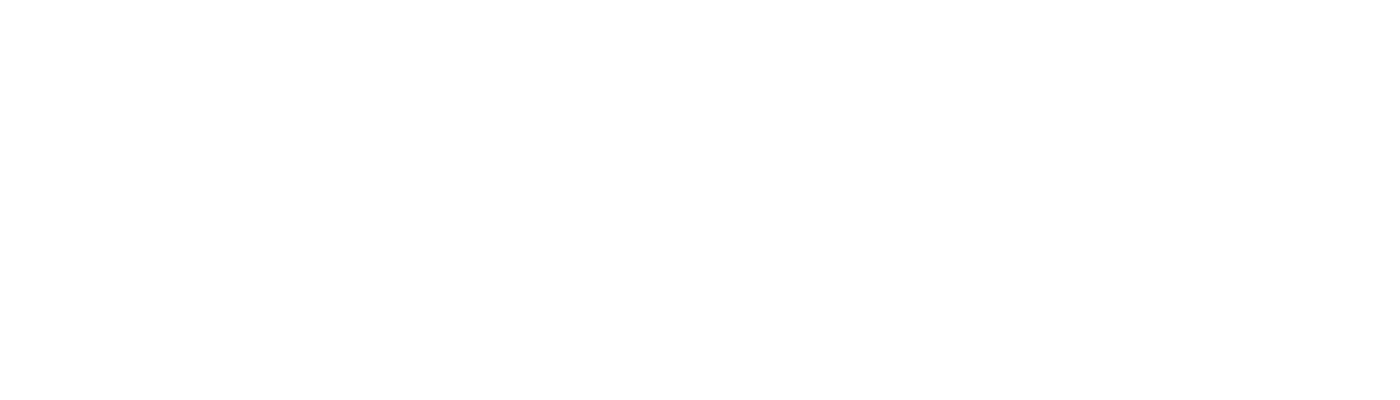

a370_SN_sourceplane/lenstool_files/bin_68.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_82_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


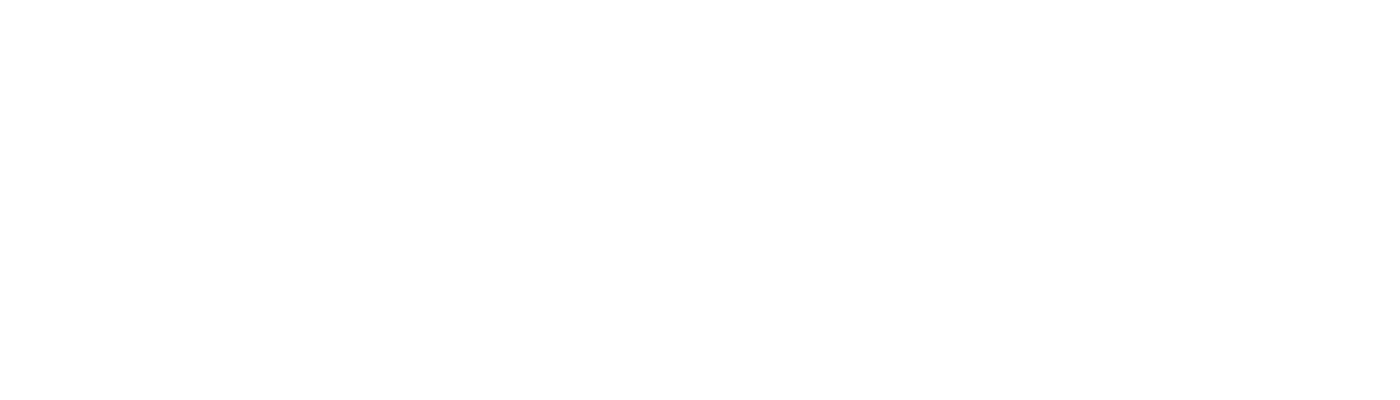

a370_SN_sourceplane/lenstool_files/bin_82.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_16_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


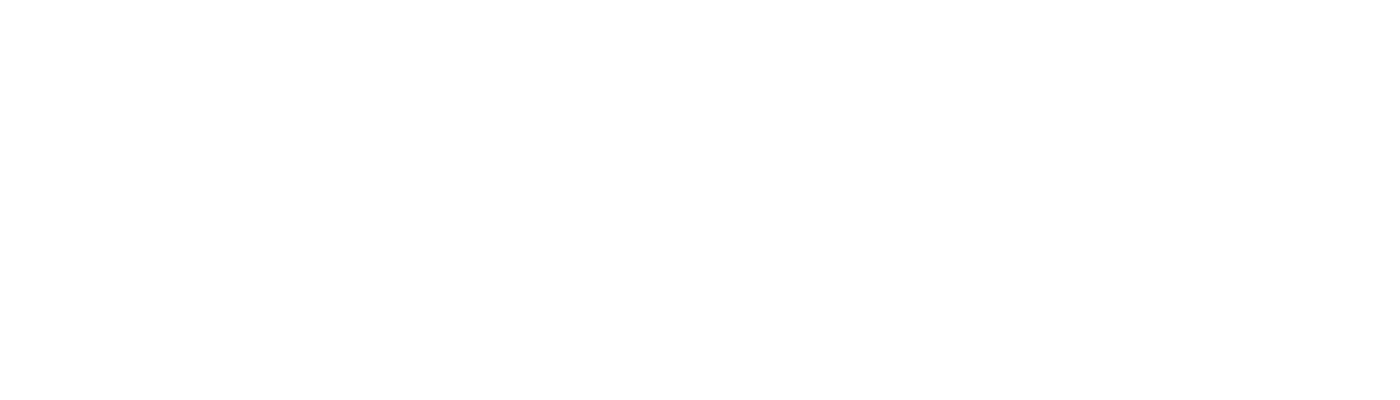

a370_SN_sourceplane/lenstool_files/bin_16.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_53_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


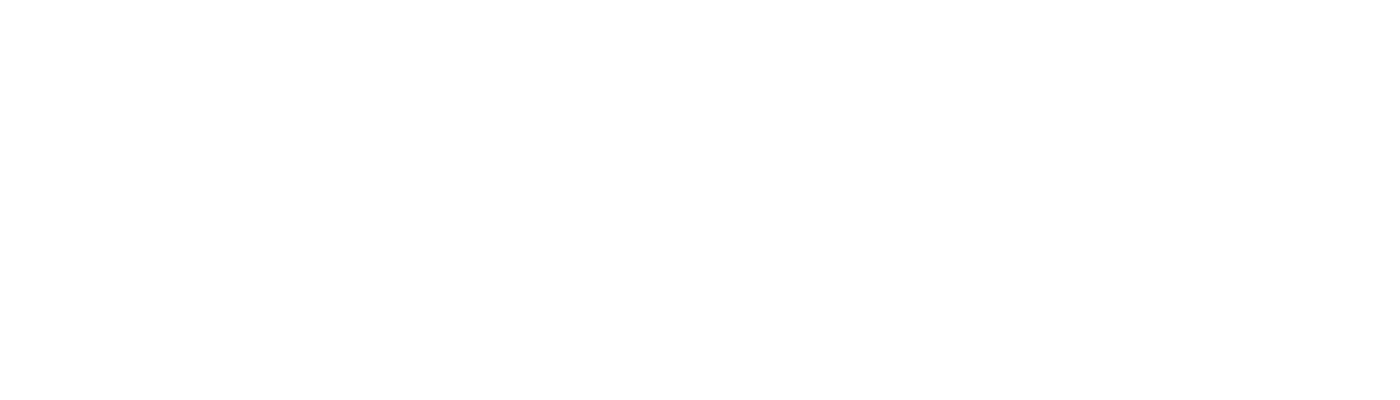

a370_SN_sourceplane/lenstool_files/bin_53.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_60_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


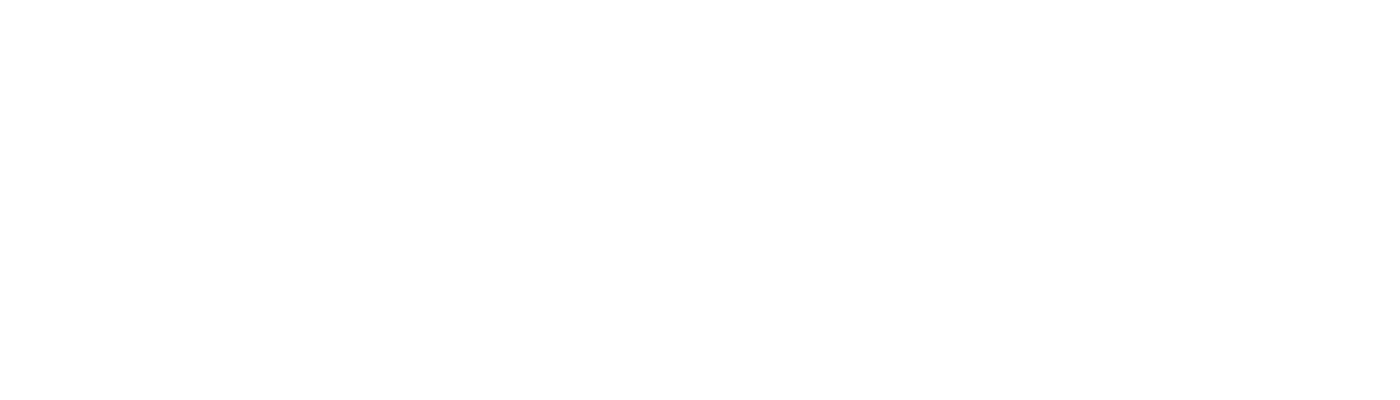

a370_SN_sourceplane/lenstool_files/bin_60.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_25_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


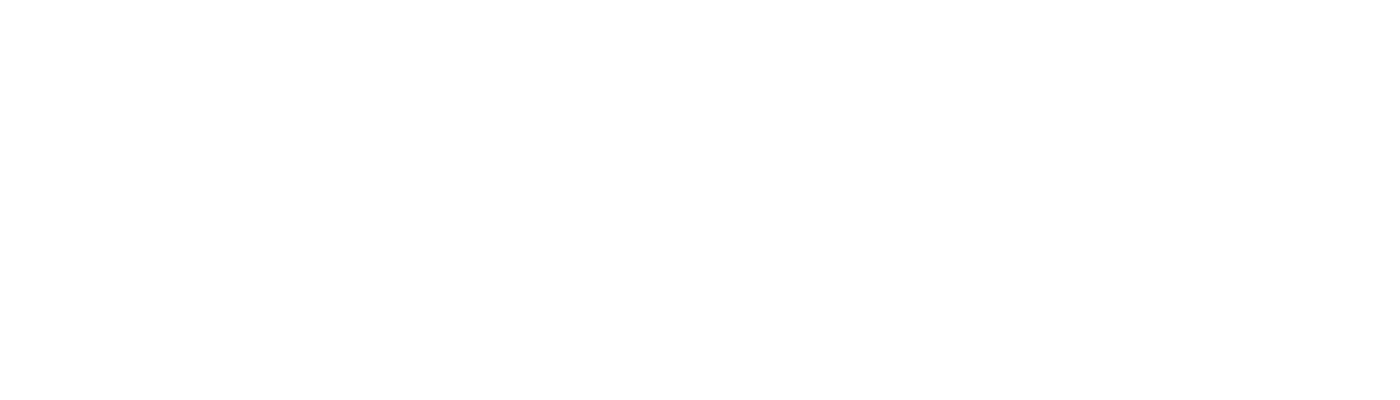

a370_SN_sourceplane/lenstool_files/bin_25.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_3_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


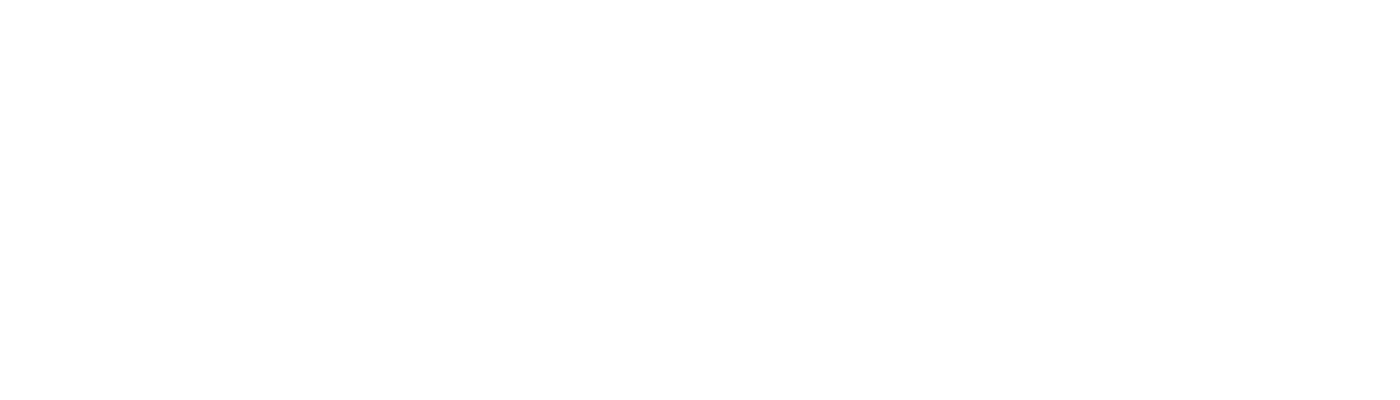

a370_SN_sourceplane/lenstool_files/bin_3.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_45_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


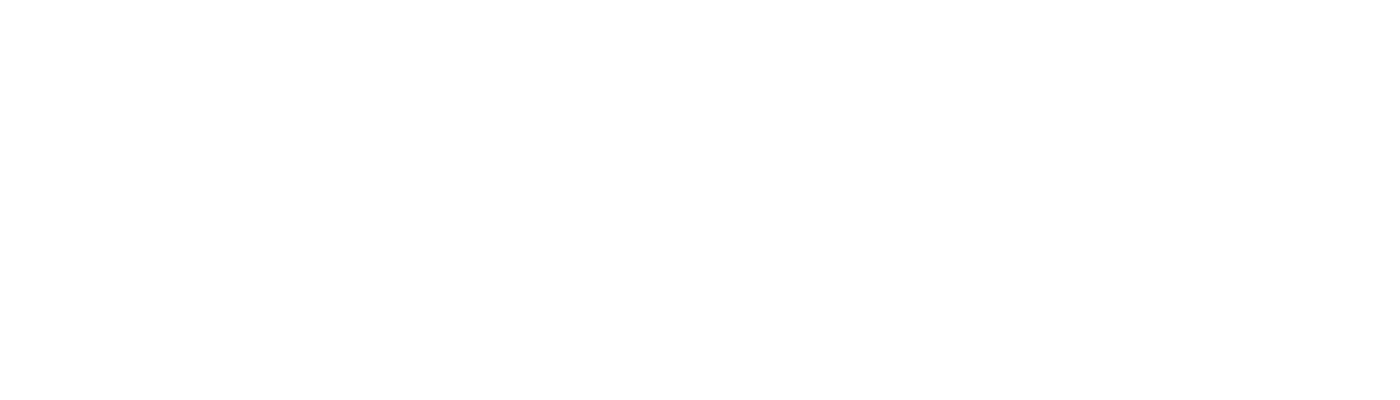

a370_SN_sourceplane/lenstool_files/bin_45.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_34_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


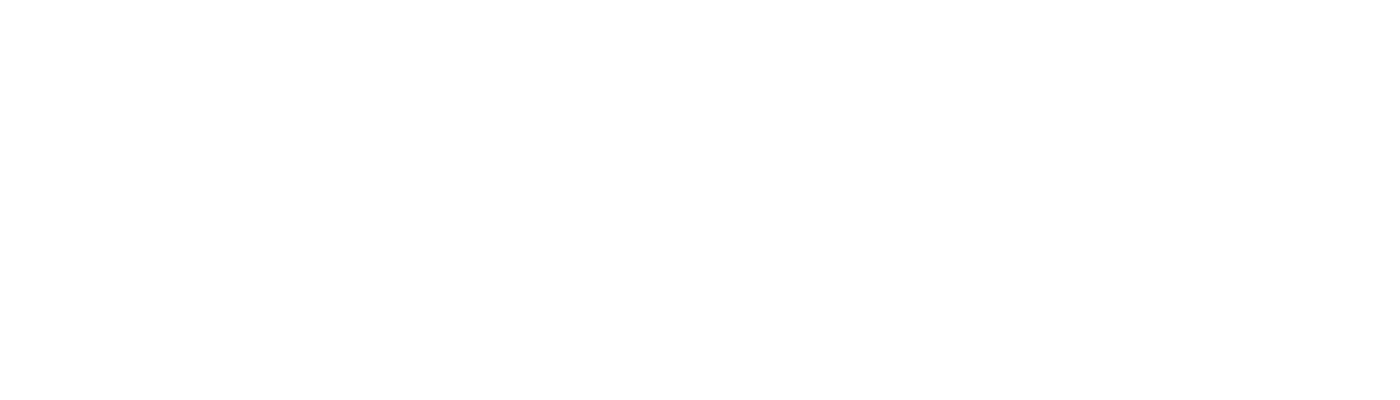

a370_SN_sourceplane/lenstool_files/bin_34.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_71_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


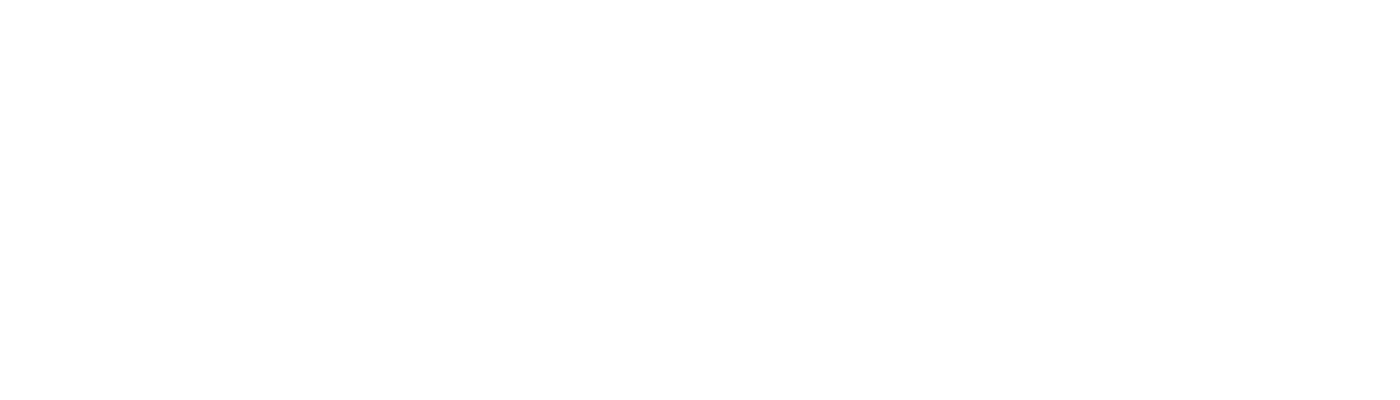

a370_SN_sourceplane/lenstool_files/bin_71.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_85_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


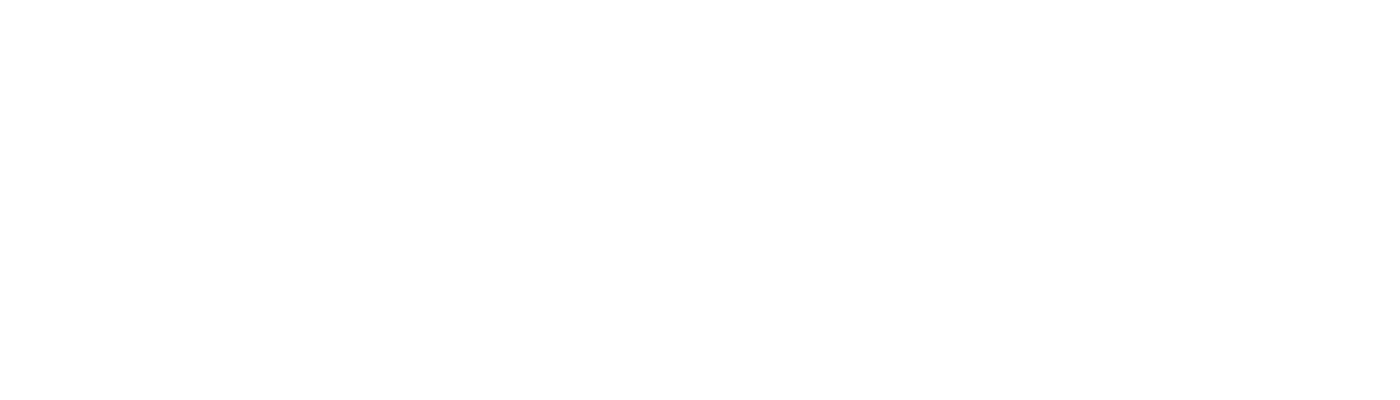

a370_SN_sourceplane/lenstool_files/bin_85.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_11_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


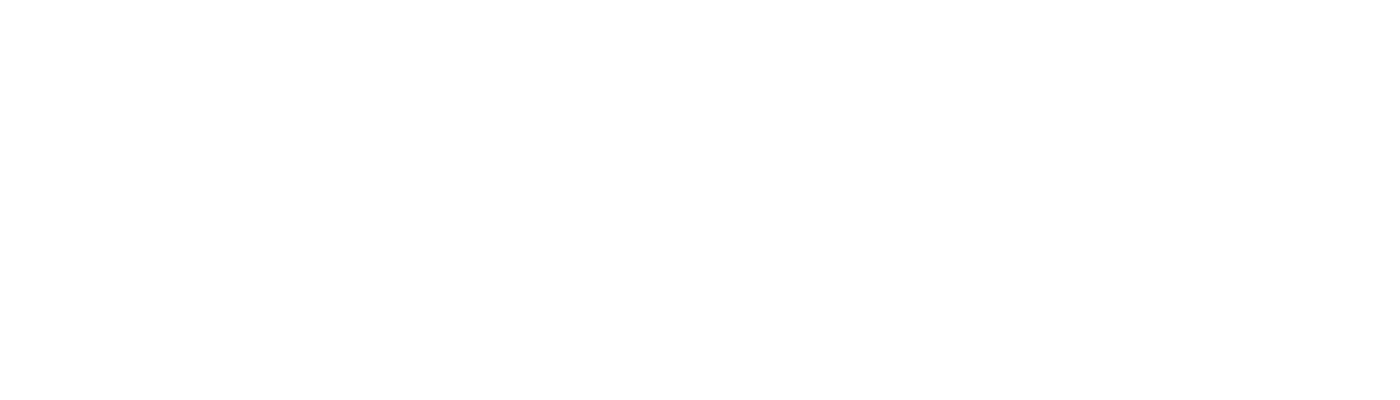

a370_SN_sourceplane/lenstool_files/bin_11.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_54_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


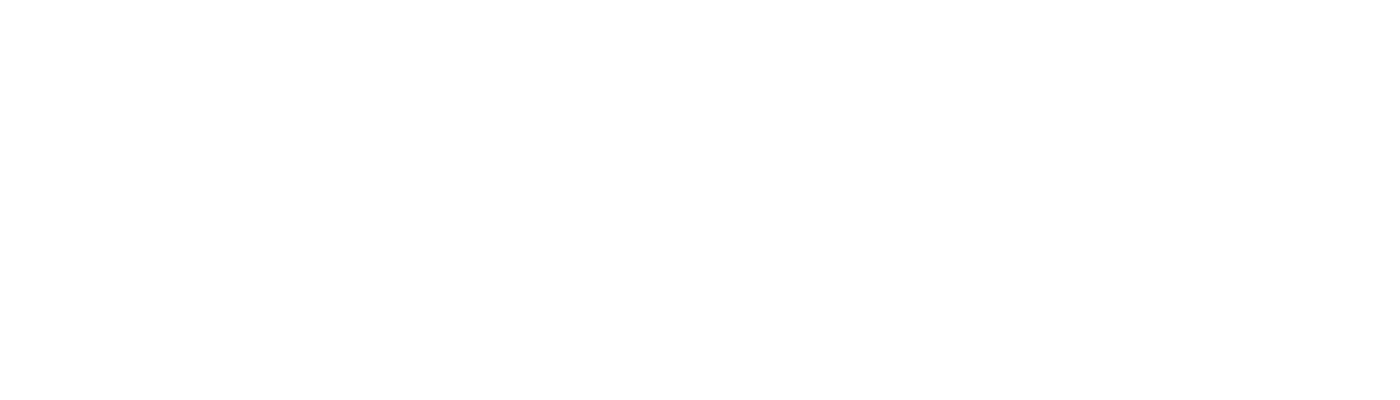

a370_SN_sourceplane/lenstool_files/bin_54.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_83_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


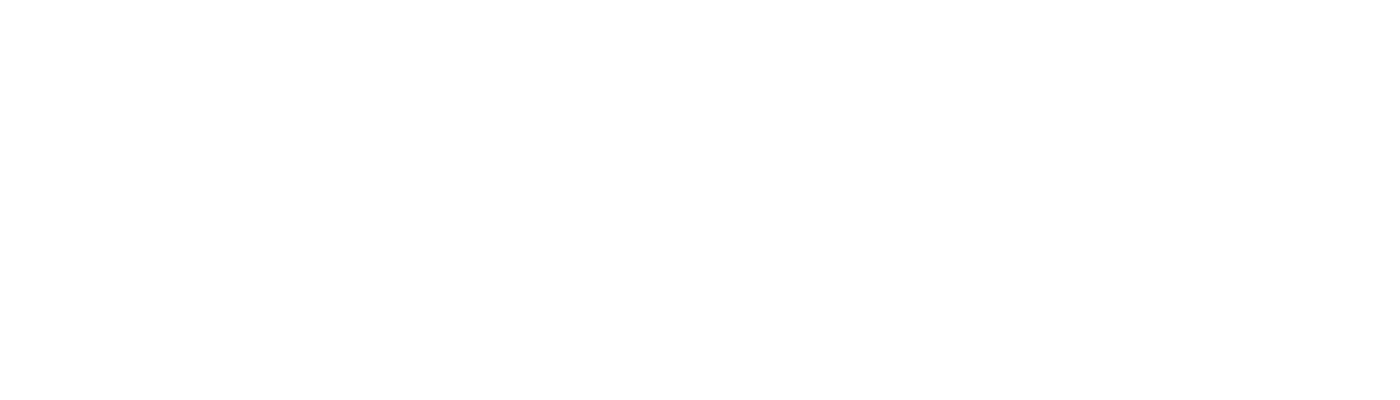

a370_SN_sourceplane/lenstool_files/bin_83.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_17_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


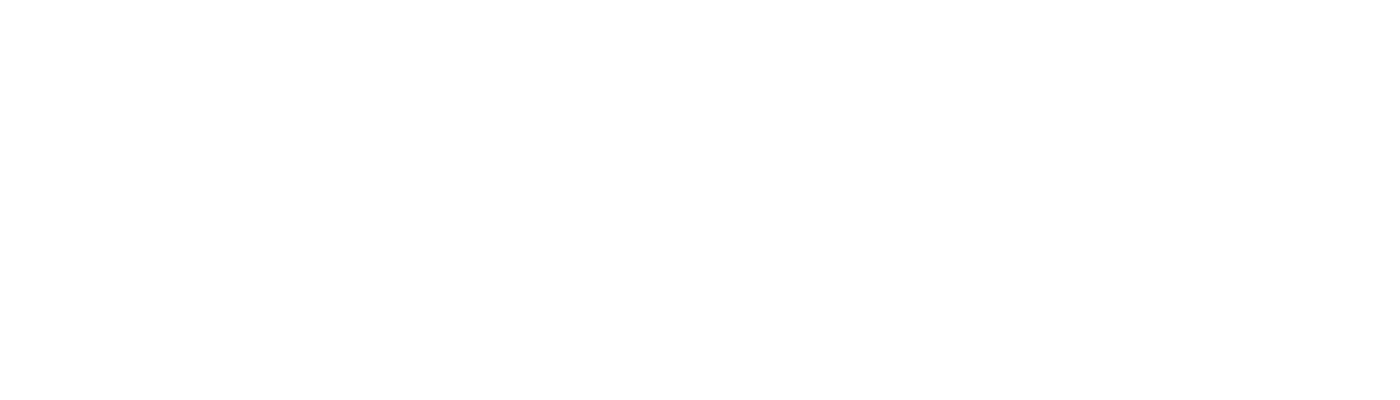

a370_SN_sourceplane/lenstool_files/bin_17.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_52_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


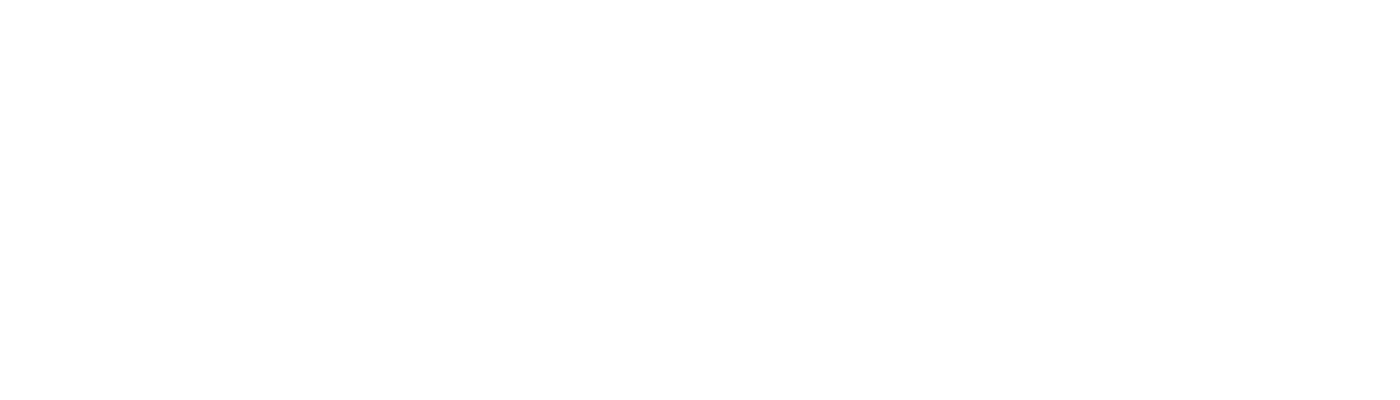

a370_SN_sourceplane/lenstool_files/bin_52.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_32_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


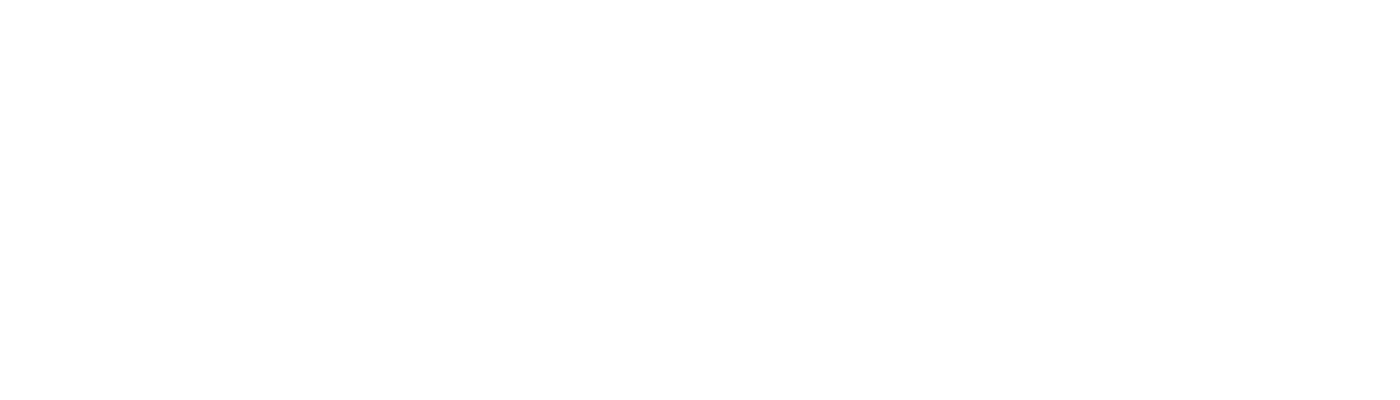

a370_SN_sourceplane/lenstool_files/bin_32.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_77_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


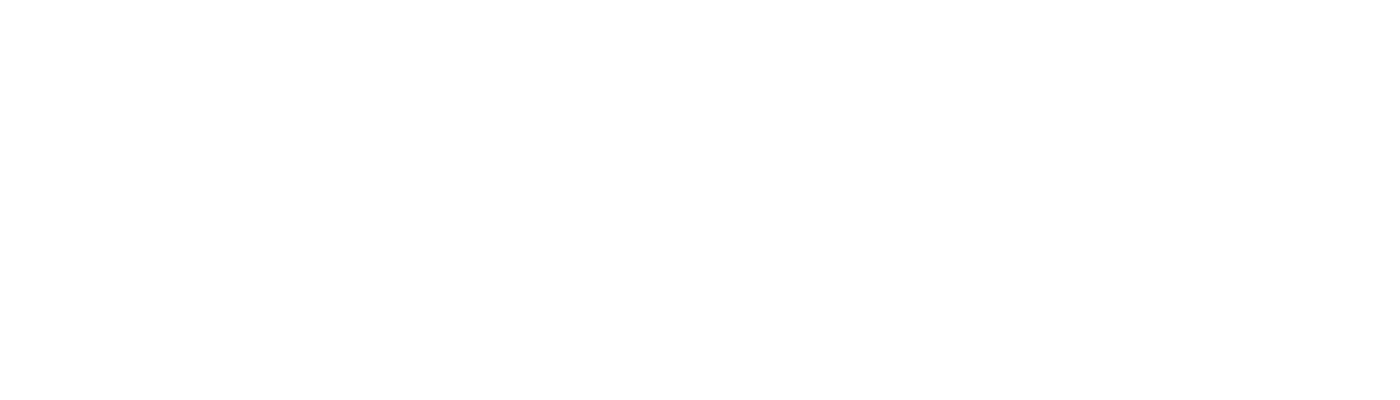

a370_SN_sourceplane/lenstool_files/bin_77.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_69_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


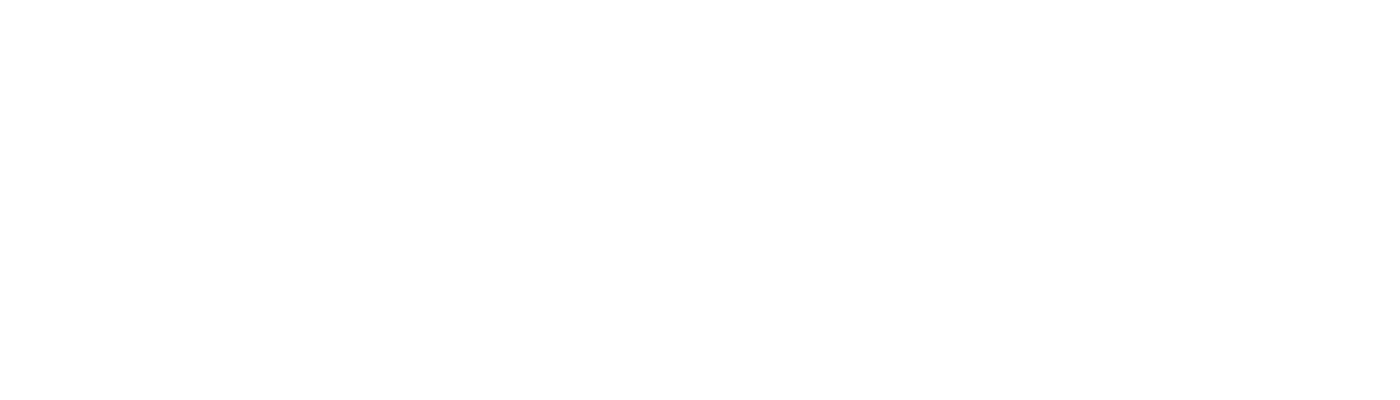

a370_SN_sourceplane/lenstool_files/bin_69.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_43_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


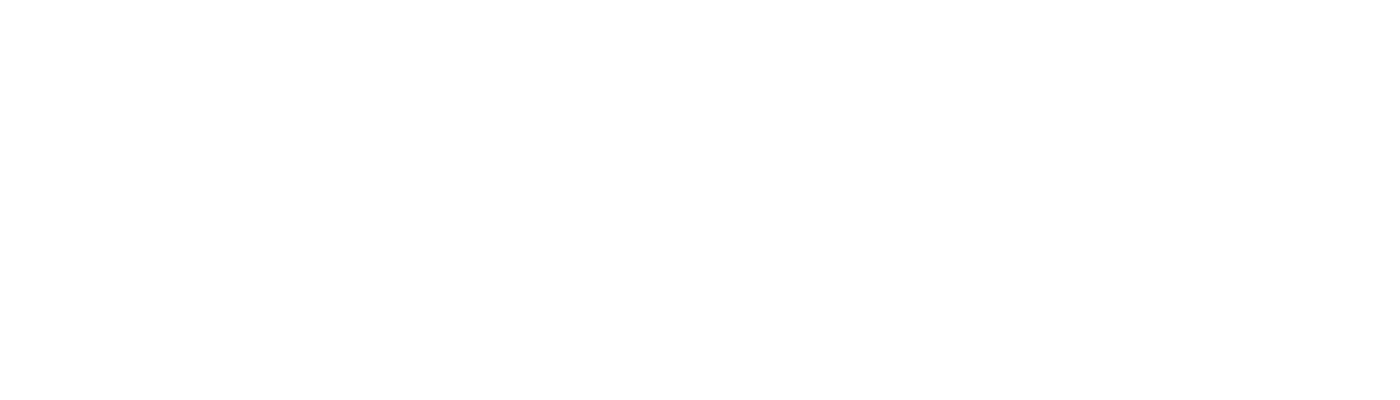

a370_SN_sourceplane/lenstool_files/bin_43.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_92_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


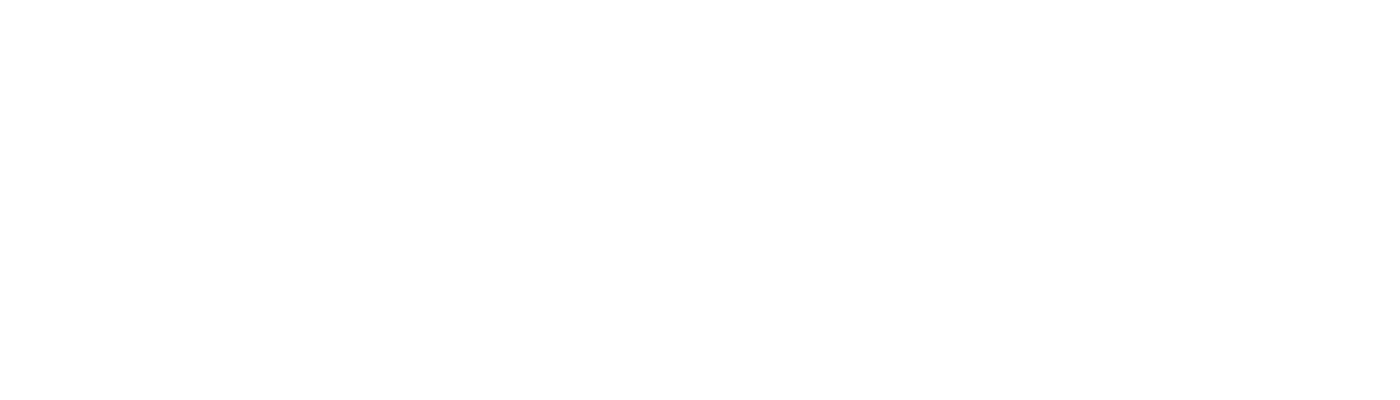

a370_SN_sourceplane/lenstool_files/bin_92.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_18_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


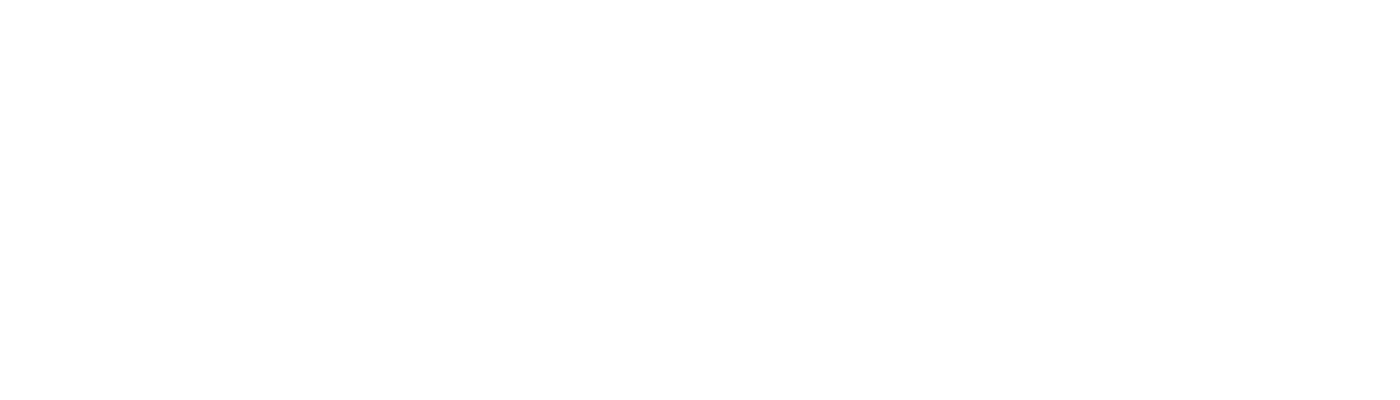

a370_SN_sourceplane/lenstool_files/bin_18.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_78_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


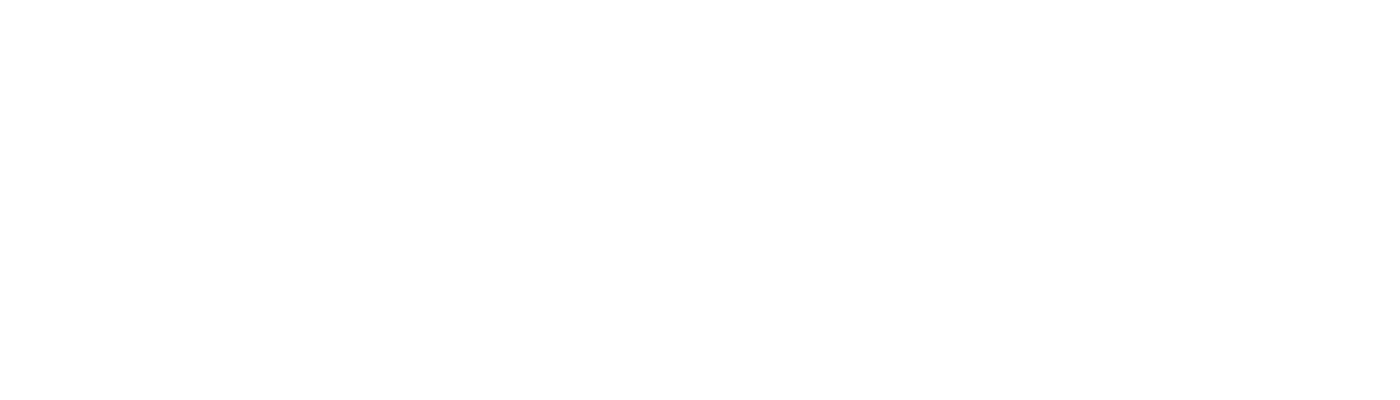

a370_SN_sourceplane/lenstool_files/bin_78.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_66_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


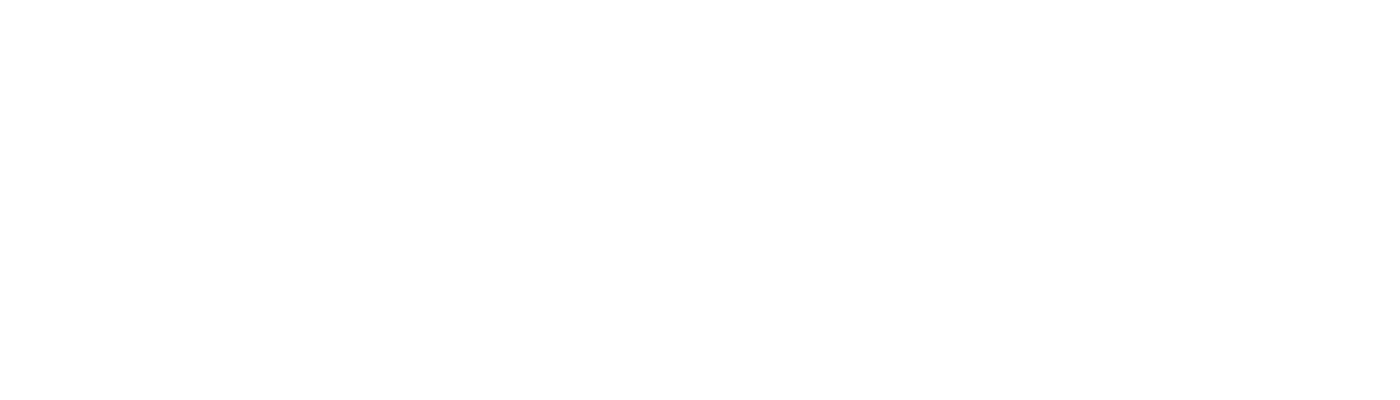

a370_SN_sourceplane/lenstool_files/bin_66.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_23_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


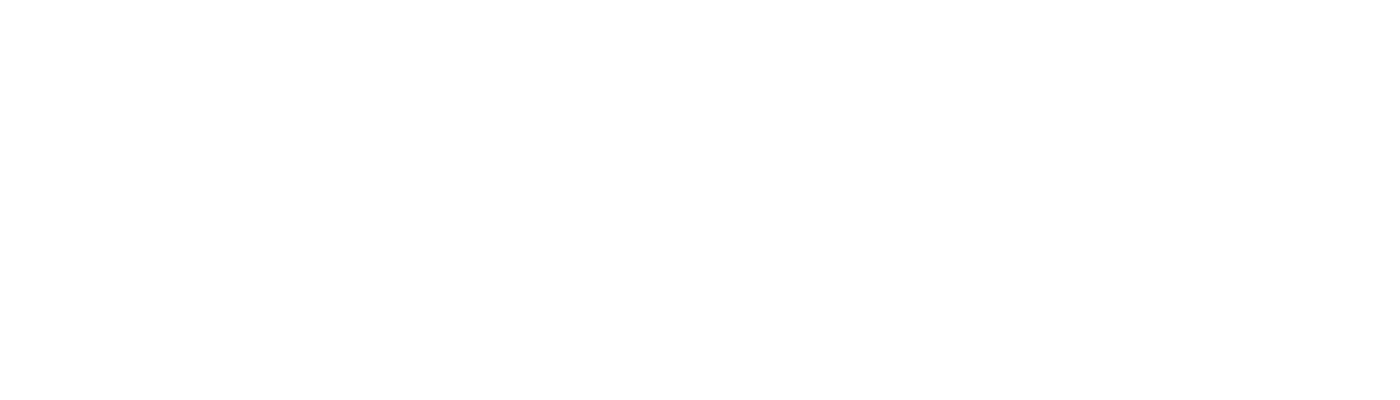

a370_SN_sourceplane/lenstool_files/bin_23.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_5_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


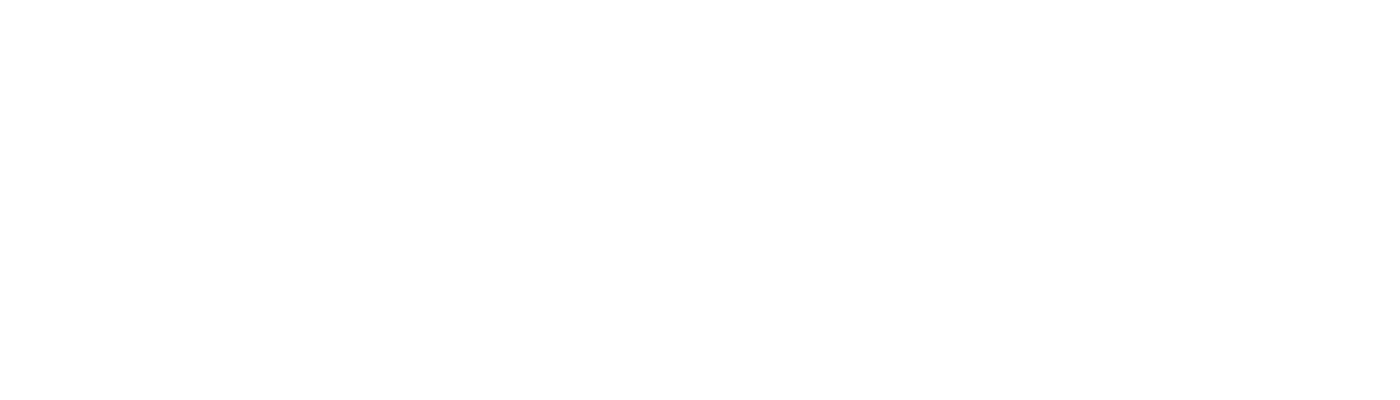

a370_SN_sourceplane/lenstool_files/bin_5.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_84_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


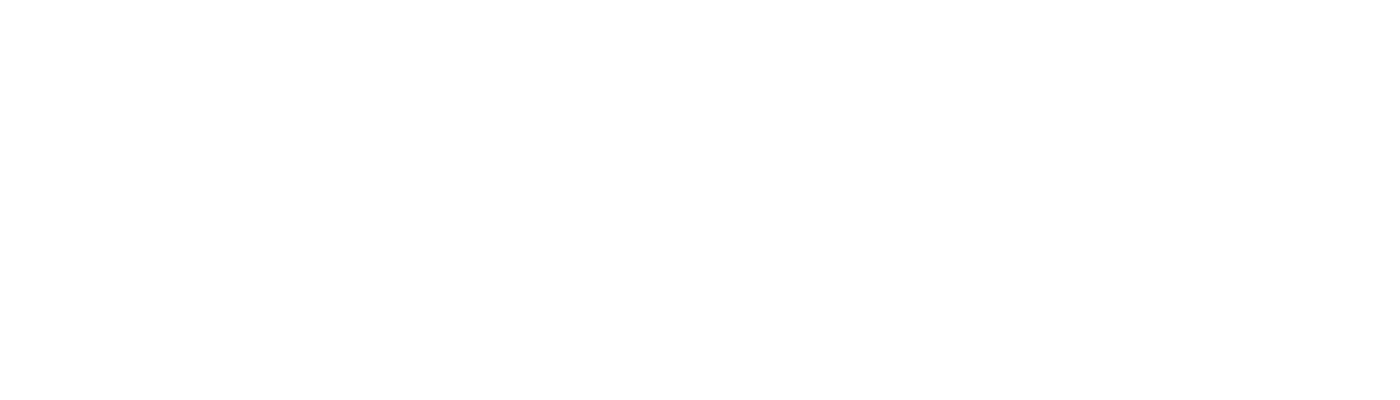

a370_SN_sourceplane/lenstool_files/bin_84.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_10_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


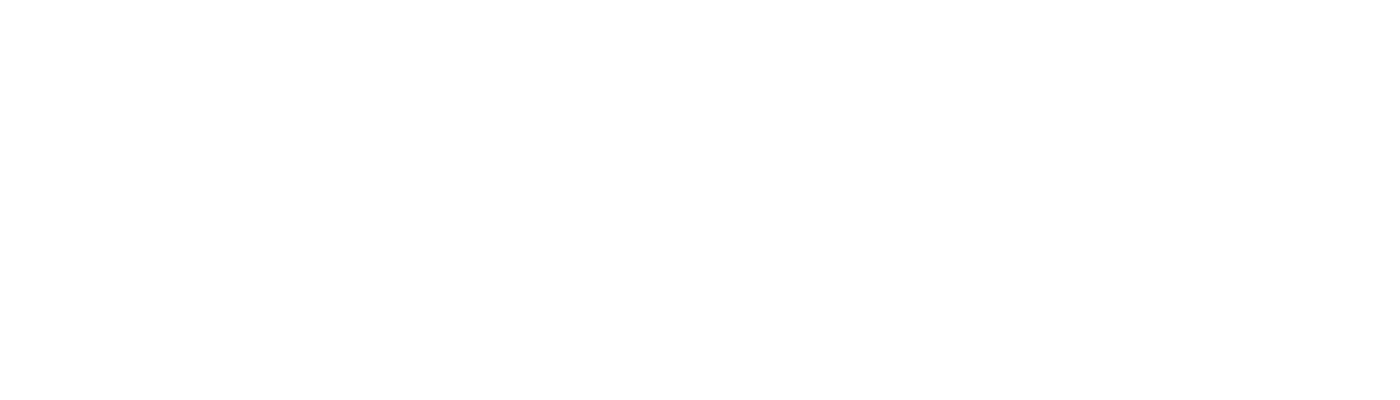

a370_SN_sourceplane/lenstool_files/bin_10.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_55_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


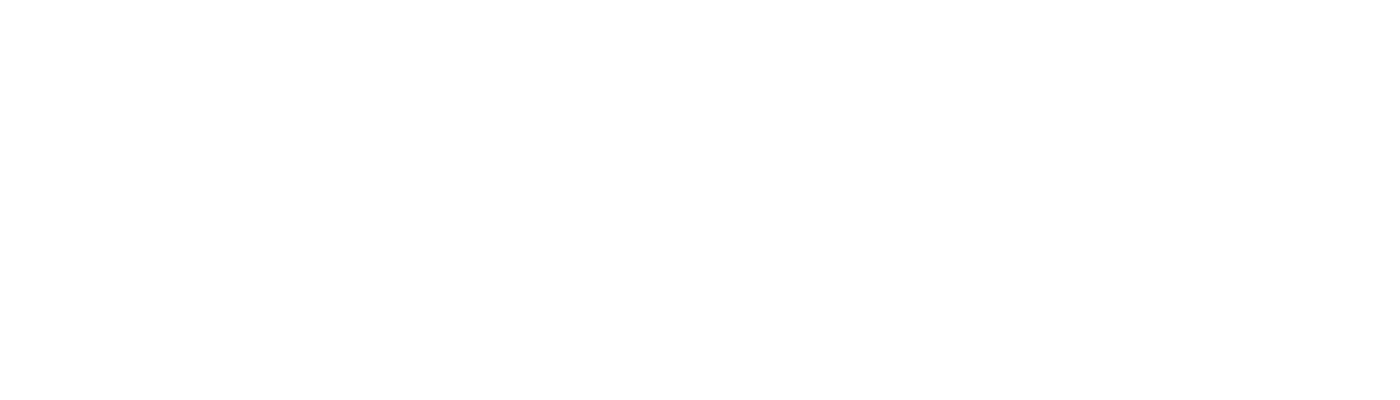

a370_SN_sourceplane/lenstool_files/bin_55.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_35_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


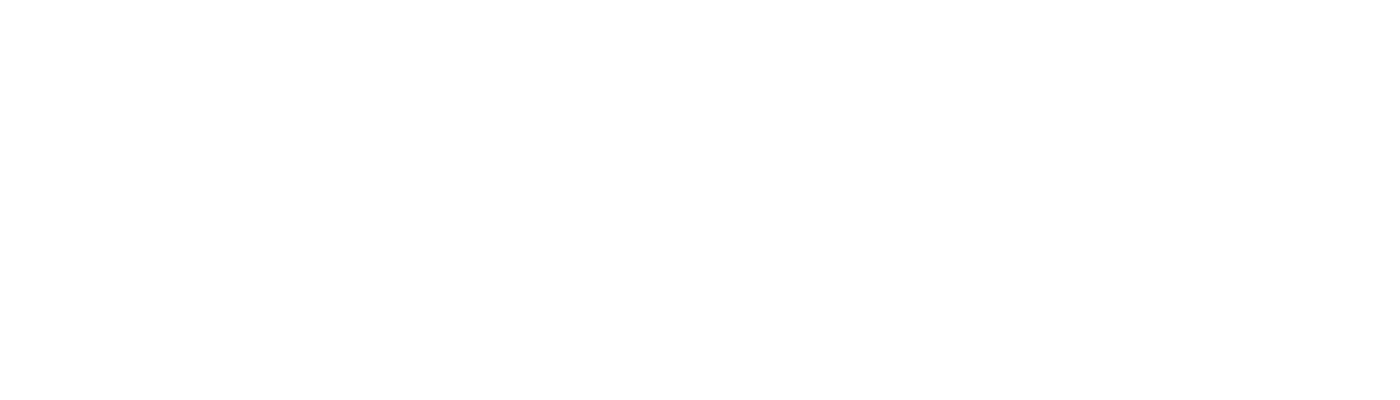

a370_SN_sourceplane/lenstool_files/bin_35.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_70_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


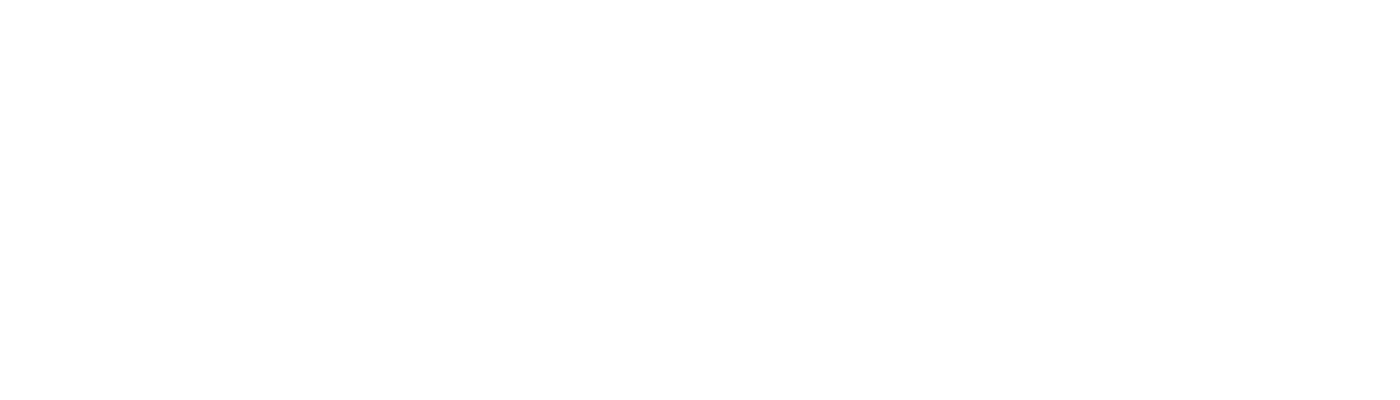

a370_SN_sourceplane/lenstool_files/bin_70.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_44_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


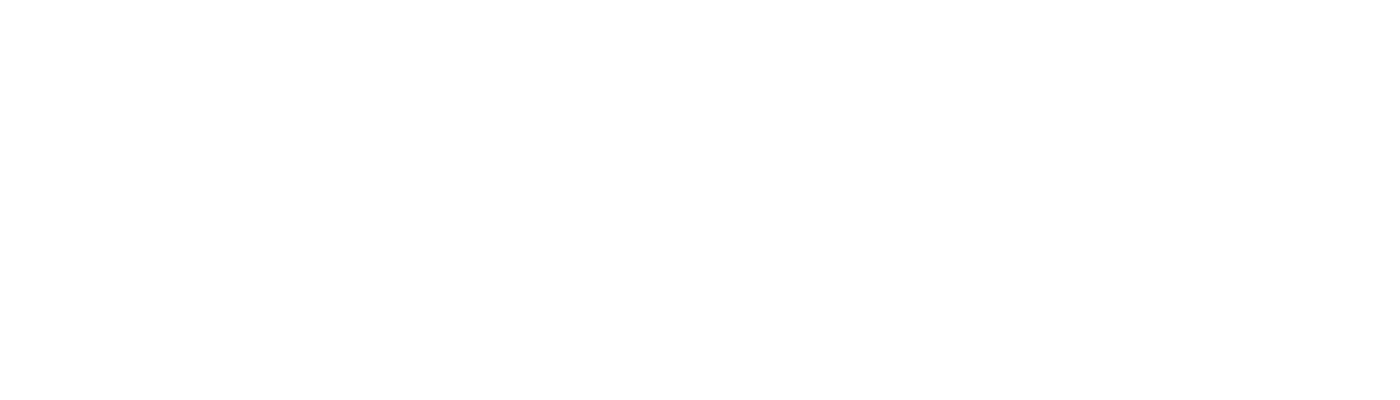

a370_SN_sourceplane/lenstool_files/bin_44.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_2_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


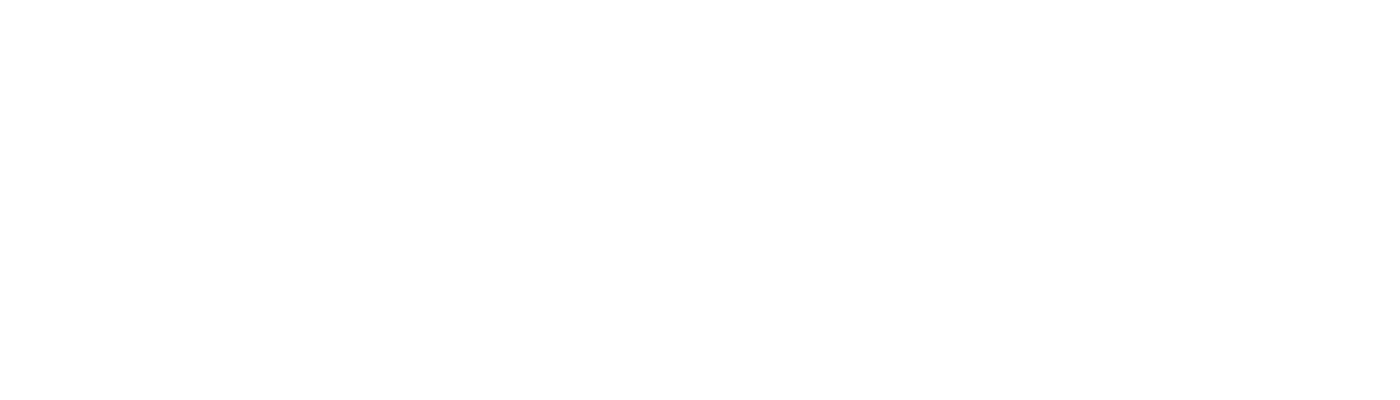

a370_SN_sourceplane/lenstool_files/bin_2.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_61_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


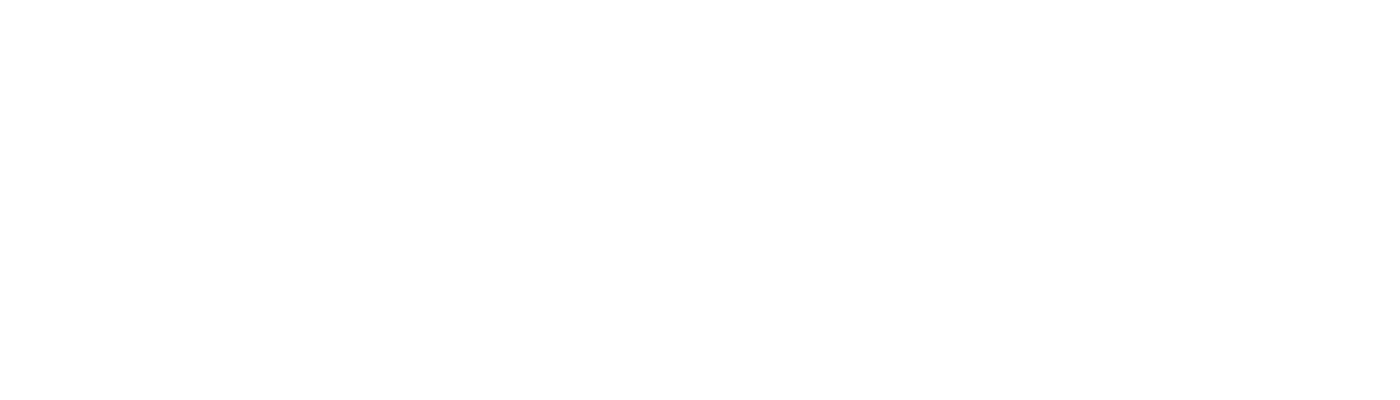

a370_SN_sourceplane/lenstool_files/bin_61.fits
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_24_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


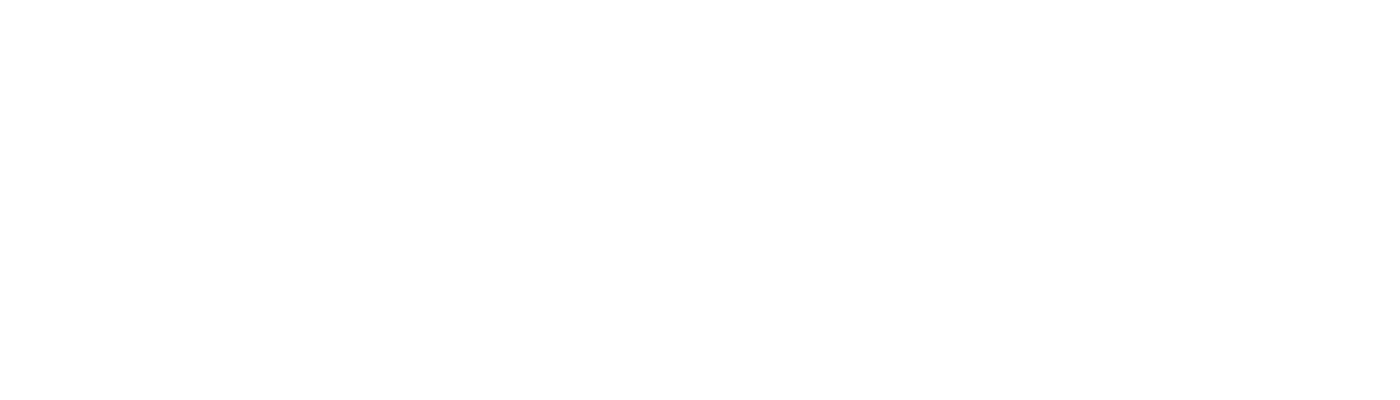

a370_SN_sourceplane/lenstool_files/bin_24.fits


In [21]:
fits_list = glob.glob('a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_*_continuum_subtracted.fits_fit')
muse = fits.open('../../Data/LensingModels/A370/A370_flux_indep_OII3726_ext1.fits')
sp = fits.getdata('a370_SN_sourceplane/lenstool_files/full_bins.fits')

for f in fits_list:
    print f

    fig, ax = plt.subplots(1,3,gridspec_kw={'width_ratios':[3,2,1]},figsize=(14,4))
    fig.subplots_adjust(left=0.05,right=0.95)
    ax1 = ax[0].twinx()

    lbd, data, fit,unc = np.loadtxt(f,unpack=True,usecols=(0,1,2,7))
    im_name = f.replace('alfa_fits/SpectraContSub','ImagePlaneAperture/ImagePlane').replace('continuum_subtracted.fits_fit','convolved.fits')
    im_source_name = f.replace('alfa_fits/SpectraContSub_','lenstool_files/').replace('_continuum_subtracted.fits_fit','.fits')
    print(im_source_name)
    sp_continuum = f.replace('alfa_fits/SpectraContSub','Spectra/Spectra').replace('continuum_subtracted.fits_fit','convolved.fits')
    
    im = fits.getdata(im_name)
    im_source = fits.getdata(im_source_name)
    continuum = fits.getdata(sp_continuum)/1000
    
    
    fig.suptitle(f.replace('a370_grids/alfa_fits/Spectra_grid_A370_','Bin ').replace('_continuum_subtracted.fits_fit',''))
    ax[0].plot(lbd[1200:3200],continuum[1200:3200],color='g',alpha=0.3)
    ax[0].plot(lbd[1200:3200],data[1200:3200],color='k')
    ax[0].plot(lbd[1200:3200],fit[1200:3200],color='r',linestyle='--')
    
    ax[1].imshow(im,origin='lower',cmap=plt.cm.Blues)
    ax[1].axis('off')
    ax[1].contour(muse[0].data,levels=[20])

    ax[2].imshow(sp,origin='lower')
    ax[2].imshow(im_source,origin='lower',cmap=plt.cm.Reds,alpha=0.6)
    ax[2].axis('off')

    fig.savefig(f.replace('.fits_fit','.pdf'),format='pdf')
    plt.close()


# Calculate metallicity from the emission lines

In [26]:
from met_and_ext_mcmc import make_obs_file,fit_metallicity_and_extinction

def prepare_array(f):
    
    lbd, f, err = np.genfromtxt(f,unpack=True,usecols=(1,2,3))
    lbd = list(lbd)

    flx = []
    unc = []

    for l in [3726.03, 3728.82, 4340.47, 4861.33, 4958.91, 5006.84]:
        try:
            flx.append(f[lbd.index(l)])
            unc.append(err[lbd.index(l)])
        except ValueError:
            flx.append(np.nan)
            unc.append(np.nan)
    
    # Put in in the correct order:
             #'[OII]3727',    '[NeIII]','H7',    'Hd',  'Hg',        'Hb',  '[OIII]4959','[OIII]5007','Ha','[NII]6584'
    data = [flx[0]+flx[1], np.nan, np.nan, np.nan, flx[2], flx[3], flx[4],   flx[5], np.nan, np.nan]
    err  = [unc[0]+unc[1], np.nan, np.nan, np.nan, unc[2], unc[3], unc[4],   unc[5], np.nan, np.nan]

    return data, err

In [27]:
## Prepare input files
for f in glob.glob('a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_*_continuum_subtracted.fits_lines'):
    flux, uncertainties = prepare_array(f)
    make_obs_file(flux,uncertainties,f.replace('_continuum_subtracted.fits_lines','.obs'))

In [28]:
from met_and_ext_mcmc import print_ratios_ids
print_ratios_ids()

[0] OIII5007/Hb
[1] OII3727/Hb
[2] OIII5007/OII3727
[3] R23
[4] NeIII3870/OII3727
[5] NII6584/Ha
[6] OIII5007/OIII4949
[7] Hd/H7
[8] Hg/H7
[9] Hg/Hd
[10] Hb/Hd
[11] Hb/Hg
[12] Hb/H7
[13] Ha/Hg
[14] Ha/Hd
[15] Ha/H7


In [29]:
## Run mcmc code
met = []
ext = []
emet = []
eext = []

spectra = []
for f in glob.glob('a370_SN_sourceplane/alfa_fits/*obs'):
    print(f)
    spectra.append(f)
    try:
        mid_m,err_m,mid_t,err_t,samples= fit_metallicity_and_extinction(f,t_range=(0,1.5),m_range=(8.0,9.5),include=[0,1,2,3,6,11],
                                                                             extincion_law='Calzetti',nsteps=100,save=False,plot_title=None)
        
        met.append(mid_m)
        emet.append(err_m)
        ext.append(mid_t)
        eext.append(err_t)
    except ValueError:
        print('Did not fit %s'%f)
        met.append(np.nan)
        ext.append(np.nan)
        emet.append(np.nan)
        eext.append(np.nan)

a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_8.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.93$^{+0.02}_{-0.02}$
Extinction : 0.31$^{+0.06}_{-0.06}$
8.93$\pm$0.02
0.31$\pm$0.06
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_34.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.94$^{+0.02}_{-0.02}$
Extinction : 0.38$^{+0.05}_{-0.05}$
8.94$\pm$0.02
0.38$\pm$0.05
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_20.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.90$^{+0.02}_{-0.02}$
Extinction : 0.35$^{+0.05}_{-0.05}$
8.90$\pm$0.02
0.35$\pm$0.05
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_21.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.87$^{+0.02}_{-0.02}$
Extinction : 0.24$^{+0.05}_{-0.06}$
8.87$\pm$0.02
0.24$\pm$0.05
a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_35.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.96$^{+0.02}_{-0.02}$
Extinction : 0.36$^{+0.05}_{-0.05}$
8.96$\pm$0.02
0.36$\pm$0.05
a370_SN_sourceplane/alfa_fits/SpectraContSub_b

In [30]:
clean_file_name = [z.replace('a370_SN_sourceplane/alfa_fits/SpectraContSub_bin_','').replace('.obs','') for z in spectra]

t = Table(data = (clean_file_name,spectra,met,emet,ext,eext),names=('bin','file','met','met_unc','ext','ext_unc'))
t.sort('bin')
t.write('metallicity_SN_sourceplane.dat',format='ascii.fixed_width_two_line')
t.show_in_notebook()

## Reconstruct images

<IPython.core.display.Javascript object>


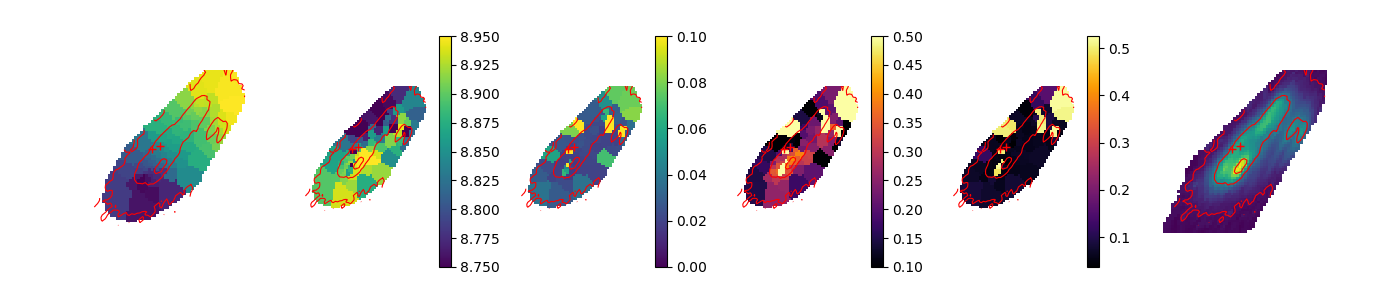

In [7]:
full_grid = fits.getdata('a370_SN_sourceplane/lenstool_files/full_bins.fits')
im = fits.getdata('../../Data/LensingModels/A370/SourcePlane_A370_OII.fits')
header = fits.getheader('../../Data/LensingModels/A370/SourcePlane_A370_F814w.fits')
wcs_im = wcs.WCS(header)
im[np.where(im==0)] = np.nan
cut_im = Cutout2D(data=im, position=(260,265),size=300,wcs=wcs_im)
t = Table.read('metallicity_SN_sourceplane.dat',format='ascii.fixed_width_two_line')

met_map = np.zeros_like(full_grid)
met_unc_map = np.zeros_like(full_grid)
ext_map = np.zeros_like(full_grid)
ext_unc_map = np.zeros_like(full_grid)
met_map[:,:] = np.nan
met_unc_map[:,:] = np.nan
ext_map[:,:] = np.nan
ext_unc_map[:,:] = np.nan

for d in t:
    bins = np.where(full_grid == float(d['bin']))
    met_map[bins]  = d['met']
    met_unc_map[bins] = d['met_unc']
    ext_map[bins]  = d['ext']
    ext_unc_map[bins] = d['ext_unc']

fig, ax = plt.subplots(1,6,figsize=(14,3))
fig.subplots_adjust(left=0.05,right=0.95)
ax[0].imshow(full_grid[37:98,27:94],origin='lower')
cax2 = ax[1].imshow(met_map[37:98,27:94],origin='lower',vmin=8.75,vmax=8.95)
cax3 = ax[2].imshow(met_unc_map[37:98,27:94],origin='lower',vmin=0.0,vmax=0.1)
cax4 = ax[3].imshow(ext_map[37:98,27:94],origin='lower',cmap='inferno',vmin=0.1,vmax=0.5)
cax5 = ax[4].imshow(ext_unc_map[37:98,27:94],origin='lower',cmap='inferno')
ax[5].imshow(im[37:98,27:94],origin='lower')
plt.colorbar(cax2,ax=ax[1])
plt.colorbar(cax3,ax=ax[2])
plt.colorbar(cax4,ax=ax[3])
plt.colorbar(cax5,ax=ax[4])

for x in ax:
    x.axis('off')
    x.contour(im[37:98,27:94],origin='lower',colors='r',levels=[7,50,100],linewidths=0.8)
    x.plot(30,31,marker='+',color='r')
    x.plot(33,32,marker='+',color='r')
    

fits.writeto('Map_metallicity_extract_in_image_plane.fits',met_map,header=header,overwrite='True')
fits.writeto('Map_metallicity_unc_extract_in_image_plane.fits',met_unc_map,header=header,overwrite='True')
fits.writeto('Map_extinction_extract_in_image_plane.fits',ext_map,header=header,overwrite='True')
fits.writeto('Map_extinction_unc_extract_in_image_plane.fits',ext_unc_map,header=header,overwrite='True')

# Repeat but using only the head

<IPython.core.display.Javascript object>


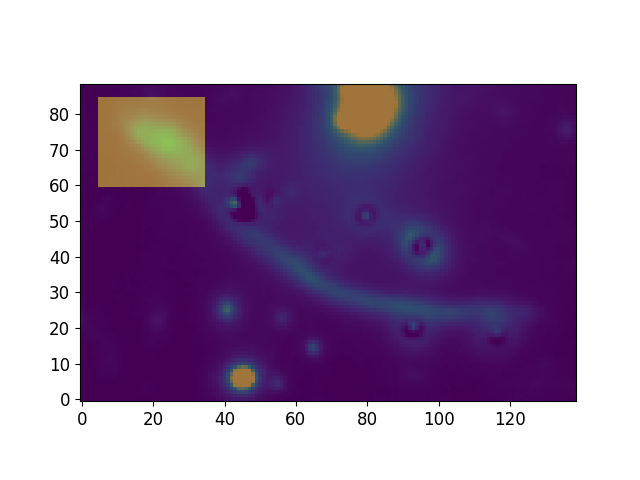

In [41]:
z=0.725
cube = fits.getdata('../../Data/Cubes/SmallCube_A370_mosaic_CMSub.fits')
mask = np.zeros_like(cube[0,:,:])
mask[60:85,5:35] = 1

plt.figure()
plt.imshow(np.mean(cube,axis=0),vmin=0,vmax=10,origin='lower')
plt.imshow(mask,alpha=0.5,origin='lower')

In [42]:
## Extract spectra in the cube
aperture_list = glob.glob("a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_*_convolved.fits")
cube = fits.getdata('../../Data/Cubes/SmallCube_A370_mosaic_CMSub.fits')

for f in aperture_list:
    print(f)
    aperture = fits.getdata(f)
    weighted_cube = cube*aperture*mask
    sp = np.sum(weighted_cube,axis=(1,2))
    fits.writeto(f.replace('ImagePlaneAperture/ImagePlane','Spectra/Spectra_only_head'),data=sp*(z+1),header=prihdr_MUSE,output_verify='fix')

a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_66_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_73_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_17_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_91_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_84_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_74_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_61_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_10_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_18_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_83_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_69_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_82_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_19_convolved.fits
a370_SN_sourceplane/ImagePlaneAperture/ImagePlane_bin_68_convolv

In [43]:
# Prepare spectral libraries
from ppxf import ppxf

star_temp, velscale, goodpixels, lamrange_gal, dv = prepare_stellar_libraries()
FWHM_gal = 2.5/(1+0.725) ## In Angstrom
h1 = fits.getheader('a370_SN_sourceplane/Spectra/Spectra_bin_0_convolved.fits')
wave_origin = np.arange(h1['CRVAL1'],h1['CRVAL1']+h1['CDELT1']*h1['NAXIS1'],h1['CDELT1'])


for s in glob.glob('a370_SN_sourceplane/Spectra/Spectra_only_head_bin_*_convolved.fits'):
    
    print('Fitting: %s'%s)

    # Prepare input spectra
    gal_lin = fits.getdata(s)

    # Put in in logscale
    galaxy, logLam_gal, velscale = ppxf_util.log_rebin(lamrange_gal, gal_lin)
    norm = np.median(galaxy)
    galaxy /= norm # Normalize spectrum to avoid numerical issues
    noise = np.ones_like(galaxy)

    ## Fit
    start = [0,180]
    try:
        pp = ppxf(star_temp, galaxy, noise, velscale, start, goodpixels, vsyst=dv,clean=True,plot=False,quiet=True)
    except ValueError:
        print('Not fitted')
        pass
        
    print('Velocity and dispersion: %s'%pp.sol)
   
    ## Return the solution to the same wavelenght and flux as before
    wave = np.exp(logLam_gal)#This has a different step than the original
    continuum = pp.bestfit*norm
    
    ## Interpolate solution to be able to subtract it to the original spectrum
    continuum_interp = np.interp(wave_origin,wave,continuum,left=0,right=0)
    contsub = gal_lin - continuum_interp

    fits.writeto(s.replace('Spectra','SpectraContSub').replace('convolved','continuum_subtracted'),data=contsub,header = h1)

Fitting: a370_SN_sourceplane/Spectra/Spectra_only_head_bin_2_convolved.fits
Velocity and dispersion: [-27.90130179 439.49202239]
Fitting: a370_SN_sourceplane/Spectra/Spectra_only_head_bin_26_convolved.fits
Velocity and dispersion: [-68.53299914 433.56547803]
Fitting: a370_SN_sourceplane/Spectra/Spectra_only_head_bin_33_convolved.fits
Velocity and dispersion: [-73.63812588 397.55947806]
Fitting: a370_SN_sourceplane/Spectra/Spectra_only_head_bin_42_convolved.fits
Velocity and dispersion: [-88.81199136 337.89214873]
Fitting: a370_SN_sourceplane/Spectra/Spectra_only_head_bin_57_convolved.fits
Velocity and dispersion: [-80.54385263  93.02740045]
Fitting: a370_SN_sourceplane/Spectra/Spectra_only_head_bin_58_convolved.fits
Velocity and dispersion: [-54.46647449  75.04541292]
Fitting: a370_SN_sourceplane/Spectra/Spectra_only_head_bin_5_convolved.fits
Velocity and dispersion: [-112.60058098  292.38688097]
Fitting: a370_SN_sourceplane/Spectra/Spectra_only_head_bin_29_convolved.fits
Velocity and 

fit with alfa

In [44]:
## Prepare input files
for f in glob.glob('a370_SN_sourceplane/alfa_fits/SpectraContSub_only_head_bin_*_continuum_subtracted.fits_lines'):
    flux, uncertainties = prepare_array(f)
    make_obs_file(flux,uncertainties,f.replace('_continuum_subtracted.fits_lines','.obs'))

In [45]:
## Run mcmc code
met = []
ext = []
emet = []
eext = []

spectra = []
for f in glob.glob('a370_SN_sourceplane/alfa_fits/*only_head*obs'):
    print(f)
    spectra.append(f)
    try:
        mid_m,err_m,mid_t,err_t,samples= fit_metallicity_and_extinction(f,t_range=(0,1.5),m_range=(8.0,9.5),include=[0,1,2,3,6,11],
                                                                             extincion_law='Calzetti',nsteps=100,save=False,plot_title=None)
        
        met.append(mid_m)
        emet.append(err_m)
        ext.append(mid_t)
        eext.append(err_t)
    except ValueError:
        print('Did not fit %s'%f)
        met.append(np.nan)
        ext.append(np.nan)
        emet.append(np.nan)
        eext.append(np.nan)

a370_SN_sourceplane/alfa_fits/SpectraContSub_only_head_bin_93.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.91$^{+0.03}_{-0.03}$
Extinction : 0.20$^{+0.07}_{-0.07}$
8.91$\pm$0.03
0.20$\pm$0.07
a370_SN_sourceplane/alfa_fits/SpectraContSub_only_head_bin_87.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.83$^{+0.04}_{-0.04}$
Extinction : 0.32$^{+0.11}_{-0.12}$
8.83$\pm$0.04
0.32$\pm$0.12
a370_SN_sourceplane/alfa_fits/SpectraContSub_only_head_bin_50.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.97$^{+0.02}_{-0.02}$
Extinction : 0.26$^{+0.07}_{-0.07}$
8.97$\pm$0.02
0.26$\pm$0.07
a370_SN_sourceplane/alfa_fits/SpectraContSub_only_head_bin_44.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.89$^{+0.02}_{-0.02}$
Extinction : 0.20$^{+0.06}_{-0.06}$
8.89$\pm$0.02
0.20$\pm$0.06
a370_SN_sourceplane/alfa_fits/SpectraContSub_only_head_bin_78.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.79$^{+0.02}_{-0.02}$
Extinction : 0.25$^{+0.06}_{-0.06}$
8.79$\pm$0.02
0.25$\pm$

In [46]:
from astropy.table import Table

clean_file_name = [z.replace('a370_SN_sourceplane/alfa_fits/SpectraContSub_only_head_bin_','').replace('.obs','') for z in spectra]

t = Table(data = (clean_file_name,spectra,met,emet,ext,eext),names=('bin','file','met','met_unc','ext','ext_unc'))
t.sort('bin')
t.write('metallicity_only_head_SN_sourceplane.dat',format='ascii.fixed_width_two_line')
t.show_in_notebook()

<IPython.core.display.Javascript object>


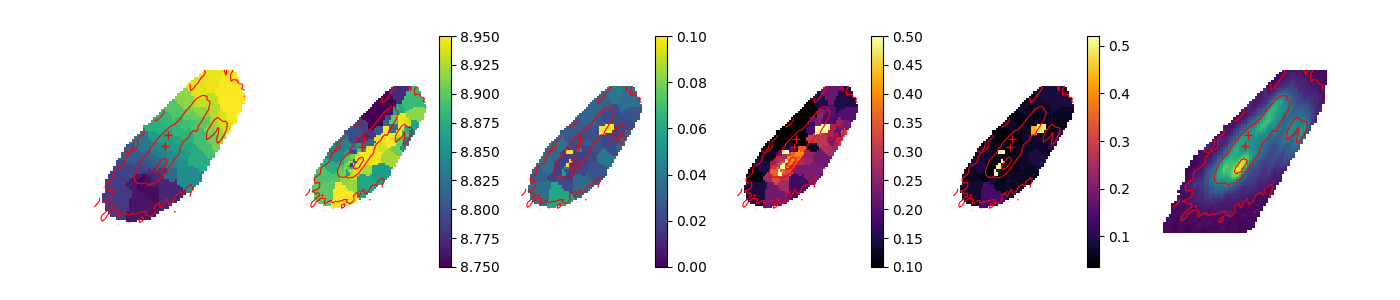

In [5]:
t = Table.read('metallicity_only_head_SN_sourceplane.dat',format='ascii.fixed_width_two_line')
full_grid = fits.getdata('a370_SN_sourceplane/lenstool_files/full_bins.fits')
im = fits.getdata('../../Data/LensingModels/A370/SourcePlane_A370_OII.fits')
header = fits.getheader('../../Data/LensingModels/A370/SourcePlane_A370_F814w.fits')
wcs_im = wcs.WCS(header)
im[np.where(im==0)] = np.nan
cut_im = Cutout2D(data=im, position=(260,265),size=300,wcs=wcs_im)

met_map = np.zeros_like(full_grid)
met_unc_map = np.zeros_like(full_grid)
ext_map = np.zeros_like(full_grid)
ext_unc_map = np.zeros_like(full_grid)
met_map[:,:] = np.nan
met_unc_map[:,:] = np.nan
ext_map[:,:] = np.nan
ext_unc_map[:,:] = np.nan

for d in t:
    bins = np.where(full_grid == float(d['bin']))
    met_map[bins]  = d['met']
    met_unc_map[bins] = d['met_unc']
    ext_map[bins]  = d['ext']
    ext_unc_map[bins] = d['ext_unc']

fig, ax = plt.subplots(1,6,figsize=(14,3))
fig.subplots_adjust(left=0.05,right=0.95)
ax[0].imshow(full_grid[37:98,27:94],origin='lower')
cax2 = ax[1].imshow(met_map[37:98,27:94],origin='lower',vmin=8.75,vmax=8.95)
cax3 = ax[2].imshow(met_unc_map[37:98,27:94],origin='lower',vmin=0.0,vmax=0.1)
cax4 = ax[3].imshow(ext_map[37:98,27:94],origin='lower',cmap='inferno',vmin=0.1,vmax=0.5)
cax5 = ax[4].imshow(ext_unc_map[37:98,27:94],origin='lower',cmap='inferno')
ax[5].imshow(im[37:98,27:94],origin='lower')
plt.colorbar(cax2,ax=ax[1])
plt.colorbar(cax3,ax=ax[2])
plt.colorbar(cax4,ax=ax[3])
plt.colorbar(cax5,ax=ax[4])
for x in ax:
    x.axis('off')
    x.contour(im[37:98,27:94],origin='lower',colors='r',levels=[7,50,100],linewidths=0.8)
    x.plot(35,32,marker='+',color='r')
    x.plot(36,36,marker='+',color='r')
             

fits.writeto('Map_metallicity_only_head_extract_in_image_plane.fits',met_map,header=header,overwrite='True')
fits.writeto('Map_metallicity_unc_only_head_extract_in_image_plane.fits',met_unc_map,header=header,overwrite='True')
fits.writeto('Map_extinction_only_head_extract_in_image_plane.fits',ext_map,header=header,overwrite='True')
fits.writeto('Map_extinction_unc_only_head_extract_in_image_plane.fits',ext_unc_map,header=header,overwrite='True')